4. Kaggle1_BERT_Classification
•	BERT Fine-Tuned on Data1 Toddler 


- Soo Kyung Bae(Scarlett), Ph.D. Student
- Dept. of Integrated Medicine(Major in Digital Healthcare)
- Yonsei University College of Medicine

In [1]:
# 1. 라이브러리 및 데이터 불러오기

In [1]:
# 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import tqdm

from transformers import BertTokenizer
from transformers import BertModel

import torch
from torch import nn
from torch.optim import Adam
from torch.utils.data import Dataset
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_recall_curve
import seaborn as sns

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# 2번코드에서 preprocess한 데이터 불러오기

data_total = pd.read_csv('./output/QCHAT_T_ASD_total_Jan222024.csv') # 2번 코드에서 제작된 데이터셋
data_total=data_total[['Class/ASD Traits ','combined']]
data_total.columns = ['ASD_traits', 'text'] # column 이름 전환
data_total.head()

,ASD_traits,text
0,No,", , , , , ,social interaction impairment in s..."
1,Yes,"attention and concentration deficit ,contacts ..."
2,Yes,"attention and concentration deficit , , , , , ..."
3,Yes,"attention and concentration deficit ,contacts ..."
4,Yes,"attention and concentration deficit ,contacts ..."


In [ ]:
# 2. train-validation-test split(8:1:1)

In [6]:
# train-validation-test split

np.random.seed(112)
df_train, df_val, df_test = np.split(data_total.sample(frac=1, random_state=42), 
                                     [int(.8*len(data_total)), int(.9*len(data_total))])

print(len(df_train),len(df_val), len(df_test))
print('train set label counts: ', df_train['ASD_traits'].value_counts())
print('validation set label counts: ', df_val['ASD_traits'].value_counts())
print('test set label counts: ', df_test['ASD_traits'].value_counts())
df_train.head()

843 105 106
train set label counts:  ASD_traits
Yes    579
No     264
Name: count, dtype: int64
validation set label counts:  ASD_traits
Yes    79
No     26
Name: count, dtype: int64
test set label counts:  ASD_traits
Yes    70
No     36
Name: count, dtype: int64


/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


,ASD_traits,text
260,Yes,"attention and concentration deficit ,contacts ..."
1025,No,", , , , , ,social interaction impairment in s..."
845,No,", , , , , ,social interaction impairment in s..."
1005,Yes,"attention and concentration deficit , ,spontan..."
88,Yes,"attention and concentration deficit , , , ,doe..."


In [ ]:
# 3. Tokenization

In [13]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

# Tokenize a sentence into input_ids, input_type_ids, attention_mask
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
labels = {
        'Yes':0,
        'No':1,
          }

class Dataset(Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['ASD_traits']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
        
    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx) # tokenized text with two columns: input_ids, attention_masks
        batch_y = self.get_batch_labels(idx) # label encoded ASD_traits

        return batch_texts, batch_y

/opt/anaconda3/envs/RoBERTa2/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# 4. Model Building

In [29]:
# on base Bert model, apply dropout layer, linear(densly connected) layer, and relu layer (for classification task)
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 2) # len(labels) =2 ASD YEs or not or 5
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        print("linear_output: ", linear_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [ ]:
"""
BERT model outputs two variables:

The first variable, which we named _ in the code above, 
contains the embedding vectors of all of the tokens in a sequence.
The second variable, which we named pooled_output, contains the embedding vector of [CLS] token. 
For a text classification task, it is enough to use this embedding as an input for our classifier.

"""

In [ ]:
# 5. train

In [21]:
# Model Training

def train(model, train_data, val_data, learning_rate, epochs):

    # 데이터를 tokenization하고, tensor형태로 바꾸어 사용합니다
    train, val = Dataset(train_data), Dataset(val_data)
    
    # train speed 높이기 위해서 batch_size=2를 이용해 parallel train
    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    # use cpu or gpu 
    use_cuda = torch.cuda.is_available()
    device = torch.device("mps")

    criterion = nn.CrossEntropyLoss() # loss function (softmax + NLLLoss)
    optimizer = Adam(model.parameters(), lr= learning_rate) # hyperparater tuning

    # Evaluation
    best_eval_auprc = 0
    best_eval_auroc = 0
    train_auprc_log = []
    eval_auprc_log = []
    train_auroc_log = []
    eval_auroc_log = []
    train_loss_log = []
    eval_loss_log = []
    """
    if use_cuda:

        model = model.cuda()
        criterion = criterion.cuda()
    """
    model = model.to(device)
    criterion = criterion.to(device)

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        preds_train = []
        targets_train = []
        avg_train_loss = 0.

        for train_input, train_label in tqdm.tqdm(train_dataloader):

            train_label = train_label.to(device)

            # separate input_ids and attemtion mask from tokenized train dataset
            mask = train_input['attention_mask'].squeeze(1).to(device) # need to keep shape of (batch_size, seq_length)
            input_id = train_input['input_ids'].squeeze(1).to(device) # need to keep shape of (batch_size, seq_length)

            # Forward Propagation
            output = model(input_id, mask) # train inputs passed through model to get output
            print(output) 

            batch_loss = criterion(output, train_label.long()) # measure loss value from the output
            total_loss_train += batch_loss.item() 
                
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            # Backward Propagation
            model.zero_grad() # back propagation requires this
            batch_loss.backward() # backpropagation
            optimizer.step() # optimize the hyperparameter by using Adam

            avg_train_loss += batch_loss.item() / len(train_dataloader)

            probs_train = output.argmax(dim=1)
            preds_train += list(probs_train.cpu().flatten())
            targets_train += list(train_label.detach().cpu().numpy().flatten())         

        auroc_train = roc_auc_score(targets_train, preds_train) # sklearn auroc matrix 
        auprc_train = average_precision_score(targets_train, preds_train, average='micro') # sklearn auprc matrix       
    
        print('[Train]  loss: {:.3f},  auroc: {:.3f},   auprc: {:.3f}'.format(avg_train_loss, auroc_train, auprc_train))
        train_auprc_log.append(auprc_train)
        train_auroc_log.append(auroc_train)
        train_loss_log.append(avg_train_loss)
            
        total_acc_val = 0
        total_loss_val = 0
        preds_eval = []
        targets_eval = []
        avg_eval_loss = 0.
    
        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].squeeze(1).to(device) # need to keep shape of (batch_size, seq_length)
                input_id = val_input['input_ids'].squeeze(1).to(device) # need to keep shape of (batch_size, seq_length)

                output = model(input_id, mask) # validation inputs passed through the model

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                    
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc

                avg_eval_loss += batch_loss.item() / len(val_dataloader)

                probs_eval  =output.argmax(dim=1)
                #print(f'Prob_T: {probs_test}')
                preds_eval += list(probs_eval.cpu().flatten())
            #print(f'Pred_T: {preds_test}')
                targets_eval += list(val_label.detach().cpu().numpy().flatten())         
            #print(f'Target_T:{targets_test}')
            auroc_eval = roc_auc_score(targets_eval, preds_eval) # sklearn auroc matrix 
            auprc_eval = average_precision_score(targets_eval, preds_eval, average='micro') # sklearn auprc matrix 

        
        print('[Valid]  loss: {:.3f},  auroc: {:.3f},   auprc: {:.3f}'.format(avg_eval_loss, auroc_eval, auprc_eval))
        eval_auprc_log.append(auprc_eval)
        eval_auroc_log.append(auroc_eval)
        eval_loss_log.append(avg_eval_loss)
        
        if best_eval_auprc < auprc_eval:
            best_eval_loss = avg_eval_loss
            best_eval_auroc = auroc_eval
            best_eval_auprc = auprc_eval
        
        print('Training End!')
        print('Best eval auprc ', best_eval_auprc)
        print('Best eval auroc', best_eval_auroc)
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        print(best_eval_loss, best_eval_auroc)

    return best_eval_auprc, best_eval_loss, best_eval_auroc, eval_auprc_log, eval_auroc_log, eval_loss_log


In [22]:
EPOCHS = 5
model = BertClassifier()
LR = 1e-6
              
best_eval_auprc,best_eval_loss, best_eval_auroc, eval_auprc_log, eval_auroc_log, eval_loss_log=train(model, df_train, df_val, LR, EPOCHS)

  0%|          | 0/422 [00:00<?, ?it/s]

linear_output:  tensor([[ 0.4943, -0.5211],
        [ 1.2601,  0.5328]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4943, 0.0000],
        [1.2601, 0.5328]], device='mps:0', grad_fn=<ReluBackward0>)


  0%|          | 1/422 [00:04<28:39,  4.09s/it]

linear_output:  

  0%|          | 2/422 [00:04<13:13,  1.89s/it]

tensor([[ 0.9699,  0.0012],
        [ 0.6121, -1.1789]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9699, 0.0012],
        [0.6121, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6419, -0.7450],
        [ 1.4634, -0.2866]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6419, 0.0000],
        [1.4634, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 4/422 [00:04<05:01,  1.38it/s]

linear_output:  tensor([[ 1.3406, -0.3888],
        [ 1.8531,  0.3942]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3406, 0.0000],
        [1.8531, 0.3942]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0970, -0.5692],
        [ 0.7514, -0.2445]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0970, 0.0000],
        [0.7514, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|▏         | 6/422 [00:05<02:41,  2.57it/s]

linear_output:  tensor([[-0.0618, -0.5130],
        [ 0.4734,  0.1255]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.4734, 0.1255]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9301, -0.3594],
        [ 1.2234, -0.5150]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9301, 0.0000],
        [1.2234, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 8/422 [00:05<01:47,  3.84it/s]

linear_output:  tensor([[ 0.4394, -0.3272],
        [ 0.9606, -0.2050]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4394, 0.0000],
        [0.9606, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9314, -0.6993],
        [ 0.4665, -0.8560]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9314, 0.0000],
        [0.4665, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 10/422 [00:05<01:22,  5.00it/s]

linear_output:  tensor([[0.4122, 0.0169],
        [1.9430, 0.2580]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4122, 0.0169],
        [1.9430, 0.2580]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5872,  0.0313],
        [ 0.2687, -0.4237]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5872, 0.0313],
        [0.2687, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 12/422 [00:05<01:10,  5.79it/s]

linear_output:  tensor([[ 0.2315, -0.4171],
        [ 0.9564,  0.1522]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2315, 0.0000],
        [0.9564, 0.1522]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3277,  0.2935],
        [ 0.2733, -0.0947]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3277, 0.2935],
        [0.2733, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 14/422 [00:06<01:04,  6.28it/s]

linear_output:  tensor([[ 1.3169, -0.2474],
        [ 0.2948, -0.2779]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3169, 0.0000],
        [0.2948, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6573, -0.2590],
        [ 0.8945,  0.1606]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6573, 0.0000],
        [0.8945, 0.1606]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 16/422 [00:06<01:02,  6.54it/s]

linear_output:  tensor([[-0.1778,  0.0657],
        [ 0.5051, -0.1818]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0657],
        [0.5051, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[1.0920, 0.7475],
        [0.5320, 0.2734]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0920, 0.7475],
        [0.5320, 0.2734]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 18/422 [00:06<01:00,  6.68it/s]

linear_output:  tensor([[0.5424, 0.5996],
        [1.2774, 0.3491]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5424, 0.5996],
        [1.2774, 0.3491]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9159, -0.3313],
        [ 0.8936,  0.1509]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9159, 0.0000],
        [0.8936, 0.1509]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 20/422 [00:07<00:59,  6.74it/s]

linear_output:  tensor([[ 1.0407,  0.4570],
        [ 0.3849, -0.0721]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0407, 0.4570],
        [0.3849, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5497,  0.2085],
        [ 0.7693, -0.0150]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5497, 0.2085],
        [0.7693, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 22/422 [00:07<00:58,  6.79it/s]

linear_output:  tensor([[1.2045, 0.1129],
        [0.8721, 0.0340]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2045, 0.1129],
        [0.8721, 0.0340]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.7931, 0.5826],
        [0.9919, 0.3446]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7931, 0.5826],
        [0.9919, 0.3446]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 24/422 [00:07<00:58,  6.81it/s]

linear_output:  tensor([[ 0.8917,  0.1085],
        [ 0.6885, -0.2760]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8917, 0.1085],
        [0.6885, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1450, -0.2992],
        [ 0.8952, -0.2572]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1450, 0.0000],
        [0.8952, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 26/422 [00:07<00:57,  6.84it/s]

linear_output:  tensor([[ 0.8708, -0.0906],
        [ 1.5057, -0.3179]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8708, 0.0000],
        [1.5057, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.8581,  0.5853],
        [ 0.6234, -0.1158]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8581, 0.5853],
        [0.6234, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 28/422 [00:08<00:57,  6.83it/s]

linear_output:  tensor([[ 1.1422, -0.1908],
        [ 1.5997, -0.0989]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1422, 0.0000],
        [1.5997, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3380, -0.1269],
        [ 0.6146,  0.0055]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3380, 0.0000],
        [0.6146, 0.0055]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 30/422 [00:08<00:57,  6.84it/s]

linear_output:  tensor([[ 1.4556, -0.7498],
        [ 0.6353, -0.9315]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4556, 0.0000],
        [0.6353, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1105, -0.5729],
        [ 0.8883, -0.0650]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1105, 0.0000],
        [0.8883, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 32/422 [00:08<00:57,  6.82it/s]

linear_output:  tensor([[ 0.5569, -0.0297],
        [ 1.1223, -0.6853]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5569, 0.0000],
        [1.1223, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6797, -0.2216],
        [ 1.4176, -0.7818]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6797, 0.0000],
        [1.4176, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 34/422 [00:09<00:56,  6.82it/s]

linear_output:  tensor([[ 0.8218, -0.8073],
        [ 1.4696,  0.6207]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8218, 0.0000],
        [1.4696, 0.6207]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0715, -1.0470],
        [ 0.5049,  0.3581]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0715, 0.0000],
        [0.5049, 0.3581]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▊         | 36/422 [00:09<00:56,  6.83it/s]

linear_output:  tensor([[ 1.0546,  0.6645],
        [ 1.0131, -0.0646]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0546, 0.6645],
        [1.0131, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0306, -0.6380],
        [ 1.2821, -0.2241]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0306, 0.0000],
        [1.2821, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 38/422 [00:09<00:56,  6.81it/s]

linear_output:  tensor([[ 1.0740, -0.6677],
        [ 1.0059, -0.6304]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0740, 0.0000],
        [1.0059, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5321, -0.1084],
        [ 1.0993,  0.0327]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5321, 0.0000],
        [1.0993, 0.0327]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 40/422 [00:10<00:56,  6.79it/s]

linear_output:  tensor([[ 1.5970, -0.8083],
        [ 1.3264, -0.0837]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5970, 0.0000],
        [1.3264, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2530, -0.2202],
        [ 0.8788,  0.1576]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2530, 0.0000],
        [0.8788, 0.1576]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 42/422 [00:10<00:55,  6.79it/s]

linear_output:  tensor([[ 0.8901,  0.3109],
        [ 0.7561, -1.2167]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8901, 0.3109],
        [0.7561, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3167, -0.2111],
        [ 0.6278, -0.1505]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3167, 0.0000],
        [0.6278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 44/422 [00:10<00:55,  6.81it/s]

linear_output:  tensor([[ 0.4618, -0.3580],
        [ 0.8758, -0.1835]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4618, 0.0000],
        [0.8758, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9925, -0.2742],
        [ 1.1531,  0.0808]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9925, 0.0000],
        [1.1531, 0.0808]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 46/422 [00:10<00:55,  6.84it/s]

linear_output:  tensor([[ 1.0312, -0.8806],
        [ 0.6955, -0.4058]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0312, 0.0000],
        [0.6955, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5672, -0.0526],
        [ 1.4974, -0.4581]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5672, 0.0000],
        [1.4974, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█▏        | 48/422 [00:11<00:54,  6.85it/s]

linear_output:  tensor([[ 0.9518,  0.0062],
        [ 1.4339, -0.7125]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9518, 0.0062],
        [1.4339, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9658, -0.5749],
        [ 0.9912, -0.5879]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9658, 0.0000],
        [0.9912, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 50/422 [00:11<00:54,  6.84it/s]

linear_output:  tensor([[ 0.3294, -0.7374],
        [ 0.7803, -0.2244]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3294, 0.0000],
        [0.7803, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9563, -0.6199],
        [ 0.8026,  0.3159]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9563, 0.0000],
        [0.8026, 0.3159]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 52/422 [00:11<00:54,  6.81it/s]

linear_output:  tensor([[ 0.9537, -0.3190],
        [ 0.8631,  0.0908]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9537, 0.0000],
        [0.8631, 0.0908]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0647, -0.8784],
        [ 1.1195,  0.0867]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0647, 0.0000],
        [1.1195, 0.0867]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 54/422 [00:12<00:53,  6.84it/s]

linear_output:  tensor([[ 0.6662, -0.4180],
        [ 0.7725, -0.6641]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6662, 0.0000],
        [0.7725, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1682, -0.3111],
        [ 0.7766, -0.1872]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1682, 0.0000],
        [0.7766, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 56/422 [00:12<00:53,  6.85it/s]

linear_output:  tensor([[ 1.6025,  1.1330],
        [ 0.6479, -0.1989]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6025, 1.1330],
        [0.6479, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6982, -0.1535],
        [ 1.2428, -0.1202]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6982, 0.0000],
        [1.2428, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 58/422 [00:12<00:53,  6.86it/s]

linear_output:  tensor([[ 0.9135, -0.3794],
        [ 0.9523,  0.3203]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9135, 0.0000],
        [0.9523, 0.3203]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0285, -0.8437],
        [ 0.6416, -0.0040]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0285, 0.0000],
        [0.6416, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 60/422 [00:12<00:53,  6.83it/s]

linear_output:  tensor([[ 0.6874,  0.4612],
        [ 1.3486, -0.2053]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6874, 0.4612],
        [1.3486, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.8900,  0.1790],
        [ 1.1007, -0.5107]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8900, 0.1790],
        [1.1007, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 62/422 [00:13<00:52,  6.86it/s]

linear_output:  tensor([[ 0.4439, -1.5497],
        [ 1.6557,  0.0061]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4439, 0.0000],
        [1.6557, 0.0061]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1949,  0.3202],
        [ 0.5055, -0.6321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1949, 0.3202],
        [0.5055, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 64/422 [00:13<00:52,  6.85it/s]

linear_output:  tensor([[ 1.4474, -0.3361],
        [ 1.0870, -0.7272]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4474, 0.0000],
        [1.0870, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2649, -0.7008],
        [ 1.1760, -0.3586]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2649, 0.0000],
        [1.1760, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 66/422 [00:13<00:51,  6.85it/s]

linear_output:  tensor([[ 1.5631, -0.1776],
        [ 0.4055,  0.2789]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5631, 0.0000],
        [0.4055, 0.2789]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2630, -0.6618],
        [ 0.7781,  0.9170]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2630, 0.0000],
        [0.7781, 0.9170]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 68/422 [00:14<00:51,  6.86it/s]

linear_output:  tensor([[ 0.4352, -0.2539],
        [ 0.7672,  0.4630]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4352, 0.0000],
        [0.7672, 0.4630]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4488, -0.2908],
        [ 0.8907, -0.1327]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4488, 0.0000],
        [0.8907, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 70/422 [00:14<00:51,  6.86it/s]

linear_output:  tensor([[0.8886, 0.2454],
        [0.9155, 0.2573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8886, 0.2454],
        [0.9155, 0.2573]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0891,  0.3367],
        [-0.2266, -0.8163]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0891, 0.3367],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 71/422 [00:14<00:51,  6.83it/s]

linear_output:  tensor([[ 0.6639, -0.5302],
        [-0.4347, -0.1795]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6639, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 73/422 [00:14<00:57,  6.09it/s]

linear_output:  tensor([[ 0.7018,  0.0820],
        [ 0.8222, -0.3077]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7018, 0.0820],
        [0.8222, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1469, -0.2483],
        [ 0.7255,  0.0526]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1469, 0.0000],
        [0.7255, 0.0526]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 75/422 [00:15<00:53,  6.46it/s]

linear_output:  tensor([[ 0.7287,  0.3341],
        [-0.2984, -0.3439]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7287, 0.3341],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9007, -0.1078],
        [ 0.6718, -0.3660]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9007, 0.0000],
        [0.6718, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 77/422 [00:15<00:51,  6.68it/s]

linear_output:  tensor([[0.9017, 0.4012],
        [0.7661, 0.3456]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9017, 0.4012],
        [0.7661, 0.3456]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.3857,  0.3603],
        [ 0.6903, -0.9009]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3857, 0.3603],
        [0.6903, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▊        | 79/422 [00:15<00:50,  6.78it/s]

linear_output:  tensor([[0.7090, 0.1270],
        [0.3372, 0.7588]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7090, 0.1270],
        [0.3372, 0.7588]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[1.0547, 0.1731],
        [1.0744, 0.5933]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0547, 0.1731],
        [1.0744, 0.5933]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 81/422 [00:16<00:49,  6.83it/s]

linear_output:  tensor([[ 1.5535, -0.3552],
        [ 1.5319, -0.6799]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5535, 0.0000],
        [1.5319, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6808, -0.5476],
        [ 1.0164, -0.8686]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6808, 0.0000],
        [1.0164, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 83/422 [00:16<00:49,  6.82it/s]

linear_output:  tensor([[ 1.3482, -0.2124],
        [ 1.1656, -0.3928]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3482, 0.0000],
        [1.1656, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6916, -0.4109],
        [ 0.4229, -0.0266]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6916, 0.0000],
        [0.4229, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 85/422 [00:16<00:49,  6.84it/s]

linear_output:  tensor([[ 0.7394,  0.4814],
        [ 0.7425, -0.0058]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7394, 0.4814],
        [0.7425, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0705,  0.0793],
        [ 0.5893, -0.3639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0705, 0.0793],
        [0.5893, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 87/422 [00:16<00:48,  6.86it/s]

linear_output:  tensor([[ 1.2782, -0.3200],
        [ 0.9429, -0.2900]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2782, 0.0000],
        [0.9429, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1654, -0.5320],
        [ 1.7049,  0.0210]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1654, 0.0000],
        [1.7049, 0.0210]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 89/422 [00:17<00:48,  6.85it/s]

linear_output:  tensor([[ 1.2520, -0.0875],
        [ 0.1390,  0.2627]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2520, 0.0000],
        [0.1390, 0.2627]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5889, -0.8198],
        [ 0.1490,  0.1391]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5889, 0.0000],
        [0.1490, 0.1391]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 91/422 [00:17<00:48,  6.83it/s]

linear_output:  tensor([[ 0.0568, -0.7222],
        [ 1.1200, -0.2327]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0568, 0.0000],
        [1.1200, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0616, -0.3849],
        [ 0.3301, -0.4738]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0616, 0.0000],
        [0.3301, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 93/422 [00:17<00:48,  6.82it/s]

linear_output:  tensor([[0.4076, 0.0663],
        [1.0304, 0.1075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4076, 0.0663],
        [1.0304, 0.1075]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9116,  0.0133],
        [ 0.7593, -0.5340]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9116, 0.0133],
        [0.7593, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 95/422 [00:18<00:47,  6.84it/s]

linear_output:  tensor([[ 1.6013,  0.1550],
        [ 0.3598, -0.4064]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6013, 0.1550],
        [0.3598, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2346, -0.1806],
        [ 0.1315, -0.3253]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2346, 0.0000],
        [0.1315, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 97/422 [00:18<00:47,  6.87it/s]

linear_output:  tensor([[ 1.4987, -0.2292],
        [ 0.9714, -0.8071]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4987, 0.0000],
        [0.9714, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5645, -0.4222],
        [ 0.9070, -0.8546]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5645, 0.0000],
        [0.9070, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 99/422 [00:18<00:47,  6.86it/s]

linear_output:  tensor([[-0.3560, -0.1446],
        [ 1.3586, -0.9644]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.3586, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8425, -0.1465],
        [ 1.1959, -0.0680]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8425, 0.0000],
        [1.1959, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 101/422 [00:19<00:46,  6.88it/s]

linear_output:  tensor([[ 0.9279, -0.9654],
        [ 0.4191, -0.2105]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9279, 0.0000],
        [0.4191, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3887, -0.5899],
        [ 0.3665, -1.3359]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3887, 0.0000],
        [0.3665, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 103/422 [00:19<00:46,  6.86it/s]

linear_output:  tensor([[ 1.5117, -0.5269],
        [ 0.9783,  0.3722]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5117, 0.0000],
        [0.9783, 0.3722]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1941, -0.1249],
        [ 0.9752, -0.3856]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1941, 0.0000],
        [0.9752, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 105/422 [00:19<00:46,  6.85it/s]

linear_output:  tensor([[ 0.7843, -0.6287],
        [ 0.6663, -0.3463]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7843, 0.0000],
        [0.6663, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.7016, -0.1909],
        [ 0.6186, -0.2221]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7016, 0.0000],
        [0.6186, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 107/422 [00:19<00:45,  6.86it/s]

linear_output:  tensor([[ 0.4873, -0.3121],
        [ 1.5628, -0.3547]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4873, 0.0000],
        [1.5628, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6233, -0.1585],
        [ 1.2708, -0.5854]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6233, 0.0000],
        [1.2708, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 109/422 [00:20<00:45,  6.87it/s]

linear_output:  tensor([[1.0075, 0.0368],
        [0.6370, 0.0387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0075, 0.0368],
        [0.6370, 0.0387]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.1932, -0.2767],
        [ 0.8487, -0.5324]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1932, 0.0000],
        [0.8487, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▋       | 111/422 [00:20<00:45,  6.87it/s]

linear_output:  tensor([[ 0.4121, -0.7015],
        [ 1.1102, -0.4773]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4121, 0.0000],
        [1.1102, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.2637, -0.6850],
        [ 0.7301, -0.6323]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2637, 0.0000],
        [0.7301, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 113/422 [00:20<00:45,  6.86it/s]

linear_output:  tensor([[ 1.1149,  0.3357],
        [-0.1399, -0.1072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1149, 0.3357],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0806, -0.3383],
        [ 0.9398, -0.0198]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0806, 0.0000],
        [0.9398, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 115/422 [00:21<00:44,  6.85it/s]

linear_output:  tensor([[ 0.3778, -0.1989],
        [ 1.2393,  0.3483]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3778, 0.0000],
        [1.2393, 0.3483]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.1980, 0.0319],
        [1.9511, 0.0790]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1980, 0.0319],
        [1.9511, 0.0790]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 117/422 [00:21<00:44,  6.88it/s]

linear_output:  tensor([[ 1.4102, -0.1521],
        [ 0.8865, -0.6030]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4102, 0.0000],
        [0.8865, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.3634, -0.2594],
        [ 0.4415,  0.0257]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3634, 0.0000],
        [0.4415, 0.0257]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 119/422 [00:21<00:44,  6.87it/s]

linear_output:  tensor([[ 0.0688, -0.1370],
        [ 1.6256, -0.6334]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0688, 0.0000],
        [1.6256, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8905, -0.0368],
        [-0.3671,  0.1258]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8905, 0.0000],
        [0.0000, 0.1258]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▊       | 121/422 [00:21<00:43,  6.86it/s]

linear_output:  tensor([[ 1.4674, -0.5459],
        [ 0.6748, -0.3271]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4674, 0.0000],
        [0.6748, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9264, -0.1440],
        [ 0.0924,  0.1694]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9264, 0.0000],
        [0.0924, 0.1694]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 123/422 [00:22<00:43,  6.87it/s]

linear_output:  tensor([[ 0.8894, -0.5199],
        [ 2.2732,  0.3238]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8894, 0.0000],
        [2.2732, 0.3238]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.1621, -0.0323],
        [ 1.4278, -0.3823]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1621, 0.0000],
        [1.4278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 125/422 [00:22<00:43,  6.87it/s]

linear_output:  tensor([[ 0.5008, -0.0981],
        [ 0.8287, -0.1846]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5008, 0.0000],
        [0.8287, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5121, -0.0455],
        [ 1.9644,  0.1704]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5121, 0.0000],
        [1.9644, 0.1704]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|███       | 127/422 [00:22<00:42,  6.86it/s]

linear_output:  tensor([[ 1.8848, -0.7709],
        [ 1.9367, -0.9864]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8848, 0.0000],
        [1.9367, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5331, -0.5231],
        [ 1.3567, -0.2929]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5331, 0.0000],
        [1.3567, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 129/422 [00:23<00:42,  6.86it/s]

linear_output:  tensor([[ 1.8338, -0.4098],
        [ 1.4811, -0.2309]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8338, 0.0000],
        [1.4811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9053,  0.1501],
        [ 1.4822, -0.0441]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9053, 0.1501],
        [1.4822, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 131/422 [00:23<00:42,  6.84it/s]

linear_output:  tensor([[1.5207, 0.0695],
        [0.6074, 0.0787]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5207, 0.0695],
        [0.6074, 0.0787]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6251, -0.1531],
        [ 1.2988, -0.0549]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6251, 0.0000],
        [1.2988, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 133/422 [00:23<00:42,  6.81it/s]

linear_output:  tensor([[ 1.1995, -0.9994],
        [ 0.3956, -0.5240]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1995, 0.0000],
        [0.3956, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0379, -0.0597],
        [ 0.7720,  0.7175]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0379, 0.0000],
        [0.7720, 0.7175]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 135/422 [00:23<00:42,  6.83it/s]

linear_output:  tensor([[ 0.9693, -0.5257],
        [ 1.6166, -0.7220]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9693, 0.0000],
        [1.6166, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5653, -0.1676],
        [ 0.1495, -0.3949]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5653, 0.0000],
        [0.1495, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 137/422 [00:24<00:41,  6.85it/s]

linear_output:  tensor([[1.1316, 0.3194],
        [1.2548, 0.5752]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1316, 0.3194],
        [1.2548, 0.5752]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2985, -0.5621],
        [ 0.5588, -0.3720]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2985, 0.0000],
        [0.5588, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 139/422 [00:24<00:41,  6.84it/s]

linear_output:  tensor([[ 1.3049, -0.1284],
        [ 1.5051, -0.5095]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3049, 0.0000],
        [1.5051, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.5274, 0.0455],
        [0.4886, 0.1518]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5274, 0.0455],
        [0.4886, 0.1518]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 141/422 [00:24<00:40,  6.85it/s]

linear_output:  tensor([[ 0.1008,  0.3114],
        [ 1.5888, -0.5238]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1008, 0.3114],
        [1.5888, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4646, -0.5099],
        [ 0.8841, -0.4749]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4646, 0.0000],
        [0.8841, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 143/422 [00:25<00:40,  6.87it/s]

linear_output:  tensor([[ 0.8618,  0.2387],
        [ 1.3272, -0.0402]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8618, 0.2387],
        [1.3272, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.7389,  0.0637],
        [ 1.4348, -0.4369]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7389, 0.0637],
        [1.4348, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 145/422 [00:25<00:40,  6.87it/s]

linear_output:  tensor([[ 1.1106, -0.7321],
        [ 0.0588,  0.1781]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1106, 0.0000],
        [0.0588, 0.1781]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9808, -0.2696],
        [ 1.4154, -0.2178]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9808, 0.0000],
        [1.4154, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▍      | 147/422 [00:25<00:40,  6.86it/s]

linear_output:  tensor([[ 0.0743, -0.0634],
        [ 1.5967, -0.6981]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0743, 0.0000],
        [1.5967, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0527, -0.5966],
        [ 0.2932, -0.3323]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.2932, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 149/422 [00:26<00:39,  6.84it/s]

linear_output:  tensor([[-0.2248,  0.3974],
        [ 1.6215, -0.6340]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3974],
        [1.6215, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.5749, -0.6147],
        [ 1.3779, -0.0172]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5749, 0.0000],
        [1.3779, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 151/422 [00:26<00:39,  6.85it/s]

linear_output:  tensor([[ 0.5079,  0.0872],
        [-0.1382, -0.7474]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5079, 0.0872],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0298,  0.1235],
        [ 1.1402, -0.2603]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1235],
        [1.1402, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▋      | 153/422 [00:26<00:39,  6.84it/s]

linear_output:  tensor([[ 0.6139, -0.1435],
        [ 1.6320,  0.1413]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6139, 0.0000],
        [1.6320, 0.1413]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0723, -0.6958],
        [ 1.1174, -0.3866]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.1174, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 155/422 [00:26<00:39,  6.82it/s]

linear_output:  tensor([[ 0.9749, -0.1199],
        [ 1.7900,  0.1009]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9749, 0.0000],
        [1.7900, 0.1009]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.7884, -0.3549],
        [ 2.1782, -1.0463]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7884, 0.0000],
        [2.1782, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 157/422 [00:27<00:38,  6.83it/s]

linear_output:  tensor([[ 0.1501,  0.3724],
        [ 1.8325, -0.0186]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1501, 0.3724],
        [1.8325, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5641, -0.0171],
        [ 0.5584,  0.6534]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5641, 0.0000],
        [0.5584, 0.6534]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 159/422 [00:27<00:38,  6.85it/s]

linear_output:  tensor([[-0.6239,  0.1708],
        [ 1.6062, -0.7591]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1708],
        [1.6062, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0831,  0.1138],
        [ 1.0820,  0.0969]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1138],
        [1.0820, 0.0969]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 161/422 [00:27<00:38,  6.85it/s]

linear_output:  tensor([[ 0.5546, -0.3729],
        [ 1.5193, -0.3295]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5546, 0.0000],
        [1.5193, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2307, -0.5488],
        [ 1.1774,  0.1262]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2307, 0.0000],
        [1.1774, 0.1262]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▊      | 163/422 [00:28<00:37,  6.83it/s]

linear_output:  tensor([[ 1.6886,  0.1038],
        [-0.0366,  0.2471]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6886, 0.1038],
        [0.0000, 0.2471]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7873, -0.2199],
        [ 1.0943, -0.0339]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7873, 0.0000],
        [1.0943, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 165/422 [00:28<00:37,  6.85it/s]

linear_output:  tensor([[ 0.0889, -0.0847],
        [ 1.4619, -0.8500]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0889, 0.0000],
        [1.4619, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5095,  0.0371],
        [ 0.5274, -0.7732]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5095, 0.0371],
        [0.5274, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 167/422 [00:28<00:37,  6.87it/s]

linear_output:  tensor([[ 1.2353, -0.4629],
        [ 1.9740, -0.9200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2353, 0.0000],
        [1.9740, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.4601,  0.0978],
        [ 1.4529, -0.0496]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4601, 0.0978],
        [1.4529, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|████      | 169/422 [00:28<00:36,  6.86it/s]

linear_output:  tensor([[ 1.0837, -0.2439],
        [-0.4071,  1.2313]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0837, 0.0000],
        [0.0000, 1.2313]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0799, -0.2502],
        [ 0.7596, -0.0664]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0799, 0.0000],
        [0.7596, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 171/422 [00:29<00:36,  6.86it/s]

linear_output:  tensor([[ 1.6366, -0.9534],
        [-0.6759,  0.5964]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6366, 0.0000],
        [0.0000, 0.5964]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4323, -0.1067],
        [ 1.1918,  0.0639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4323, 0.0000],
        [1.1918, 0.0639]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 173/422 [00:29<00:36,  6.83it/s]

linear_output:  tensor([[ 2.0382,  0.6411],
        [-0.1285, -0.0287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0382, 0.6411],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.8594, -0.0371],
        [ 1.6916, -0.2430]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8594, 0.0000],
        [1.6916, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████▏     | 175/422 [00:29<00:36,  6.84it/s]

linear_output:  tensor([[ 1.4789, -0.1225],
        [-0.2803,  0.2178]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4789, 0.0000],
        [0.0000, 0.2178]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6916, -0.0185],
        [ 1.9116, -0.0384]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6916, 0.0000],
        [1.9116, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 177/422 [00:30<00:35,  6.82it/s]

linear_output:  tensor([[ 1.1175, -0.7877],
        [ 1.4271, -1.0512]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1175, 0.0000],
        [1.4271, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7110,  0.8814],
        [ 0.6070, -0.2528]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7110, 0.8814],
        [0.6070, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 179/422 [00:30<00:35,  6.84it/s]

linear_output:  tensor([[ 1.3593, -0.2994],
        [-0.4618,  0.0874]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3593, 0.0000],
        [0.0000, 0.0874]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.8638, -0.6591],
        [ 1.3481, -0.9155]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.8638, 0.0000],
        [1.3481, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 181/422 [00:30<00:35,  6.85it/s]

linear_output:  tensor([[-0.5126,  0.7888],
        [ 0.1298,  0.1450]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7888],
        [0.1298, 0.1450]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5778,  0.6172],
        [ 1.0986,  0.1476]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6172],
        [1.0986, 0.1476]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 183/422 [00:30<00:34,  6.85it/s]

linear_output:  tensor([[ 1.3519,  0.1234],
        [-0.2537, -0.2009]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3519, 0.1234],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0152,  0.4582],
        [ 0.6937,  0.2531]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4582],
        [0.6937, 0.2531]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 185/422 [00:31<00:34,  6.86it/s]

linear_output:  tensor([[-1.0872,  0.9155],
        [ 1.7991,  0.0158]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9155],
        [1.7991, 0.0158]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5673,  0.3380],
        [-0.0318, -0.1091]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5673, 0.3380],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 187/422 [00:31<00:34,  6.88it/s]

linear_output:  tensor([[ 0.0099, -0.4914],
        [-1.3081, -0.4982]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0099, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7122, -0.5499],
        [ 1.0941,  0.0683]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7122, 0.0000],
        [1.0941, 0.0683]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 189/422 [00:31<00:34,  6.84it/s]

linear_output:  tensor([[ 0.9807, -0.5579],
        [ 1.0367, -0.4078]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9807, 0.0000],
        [1.0367, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5394, -1.2716],
        [-0.5464,  0.7926]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5394, 0.0000],
        [0.0000, 0.7926]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 191/422 [00:32<00:33,  6.82it/s]

linear_output:  tensor([[ 0.7303, -0.6603],
        [ 1.2687, -0.4657]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7303, 0.0000],
        [1.2687, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0348, -0.4628],
        [-0.8174, -0.1230]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0348, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 193/422 [00:32<00:33,  6.82it/s]

linear_output:  tensor([[ 1.4338, -0.5709],
        [ 1.4743, -0.3336]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4338, 0.0000],
        [1.4743, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6401,  0.3096],
        [ 1.2113, -0.0950]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6401, 0.3096],
        [1.2113, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 195/422 [00:32<00:33,  6.83it/s]

linear_output:  tensor([[ 1.2780, -0.1086],
        [ 2.0021,  0.1996]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2780, 0.0000],
        [2.0021, 0.1996]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8295, -0.3388],
        [ 0.0621, -0.0418]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8295, 0.0000],
        [0.0621, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 197/422 [00:33<00:33,  6.81it/s]

linear_output:  tensor([[ 1.3810, -0.4195],
        [ 0.1466, -0.1680]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3810, 0.0000],
        [0.1466, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8425,  0.9843],
        [ 0.8749,  0.4576]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9843],
        [0.8749, 0.4576]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 199/422 [00:33<00:32,  6.83it/s]

linear_output:  tensor([[-1.6997,  0.0154],
        [-0.3978,  0.7826]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0154],
        [0.0000, 0.7826]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.0042, -0.1415],
        [ 1.3225, -0.4041]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0042, 0.0000],
        [1.3225, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 201/422 [00:33<00:32,  6.86it/s]

linear_output:  tensor([[ 0.0986,  0.1857],
        [ 1.5891, -0.6181]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0986, 0.1857],
        [1.5891, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3826, -0.2761],
        [ 2.3238, -0.7315]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3826, 0.0000],
        [2.3238, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 203/422 [00:33<00:32,  6.81it/s]

linear_output:  tensor([[ 1.3544, -0.2943],
        [ 1.8792, -0.1077]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3544, 0.0000],
        [1.8792, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0488,  0.0762],
        [ 1.6653, -0.5847]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0488, 0.0762],
        [1.6653, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▊     | 205/422 [00:34<00:31,  6.83it/s]

linear_output:  tensor([[ 1.4397,  0.2149],
        [ 1.3216, -0.0201]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4397, 0.2149],
        [1.3216, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.2212, -0.0874],
        [ 0.0490, -0.3406]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2212, 0.0000],
        [0.0490, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 207/422 [00:34<00:31,  6.86it/s]

linear_output:  tensor([[-0.4778, -0.1592],
        [ 1.0369, -0.5012]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.0369, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5166, -0.5465],
        [ 2.3262, -0.5220]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5166, 0.0000],
        [2.3262, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|████▉     | 209/422 [00:34<00:31,  6.87it/s]

linear_output:  tensor([[1.2380, 0.7960],
        [1.0669, 0.2231]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2380, 0.7960],
        [1.0669, 0.2231]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5401,  0.1132],
        [ 1.3145, -1.4597]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5401, 0.1132],
        [1.3145, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 211/422 [00:35<00:30,  6.86it/s]

linear_output:  tensor([[ 1.8969, -0.1371],
        [ 2.3340, -1.5350]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8969, 0.0000],
        [2.3340, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.7992, -0.3758],
        [ 2.2169, -0.3661]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7992, 0.0000],
        [2.2169, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 213/422 [00:35<00:30,  6.85it/s]

linear_output:  tensor([[-0.4302,  0.6051],
        [ 2.0046, -0.0084]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6051],
        [2.0046, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7067, -0.8724],
        [ 1.5661,  0.0203]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7067, 0.0000],
        [1.5661, 0.0203]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 215/422 [00:35<00:30,  6.85it/s]

linear_output:  tensor([[-0.0057,  0.2205],
        [ 2.2379, -0.4508]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2205],
        [2.2379, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4788, -0.7917],
        [ 1.5480, -0.4533]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4788, 0.0000],
        [1.5480, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████▏    | 217/422 [00:35<00:29,  6.85it/s]

linear_output:  tensor([[ 1.7849, -0.0259],
        [ 1.3098,  0.3693]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7849, 0.0000],
        [1.3098, 0.3693]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4317,  0.2785],
        [ 1.9840, -0.1848]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4317, 0.2785],
        [1.9840, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 219/422 [00:36<00:29,  6.87it/s]

linear_output:  tensor([[-0.9091,  0.1529],
        [ 0.8566,  0.1201]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1529],
        [0.8566, 0.1201]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[2.4721, 0.3834],
        [1.8386, 0.2259]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4721, 0.3834],
        [1.8386, 0.2259]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 221/422 [00:36<00:29,  6.85it/s]

linear_output:  tensor([[ 2.5669,  0.3385],
        [-0.9778,  0.8404]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5669, 0.3385],
        [0.0000, 0.8404]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4388, -0.9684],
        [ 0.9163, -0.5227]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4388, 0.0000],
        [0.9163, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 223/422 [00:36<00:29,  6.85it/s]

linear_output:  tensor([[ 2.0776, -0.8678],
        [ 1.8961, -0.6738]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0776, 0.0000],
        [1.8961, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4994, -0.7455],
        [ 1.3888, -0.7677]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4994, 0.0000],
        [1.3888, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 225/422 [00:37<00:28,  6.85it/s]

linear_output:  tensor([[ 0.3057, -0.1236],
        [ 0.7591, -0.7243]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3057, 0.0000],
        [0.7591, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5435, -1.0229],
        [ 1.9371,  0.0387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5435, 0.0000],
        [1.9371, 0.0387]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 227/422 [00:37<00:28,  6.86it/s]

linear_output:  tensor([[ 1.1765, -0.9968],
        [ 1.6463,  0.1292]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1765, 0.0000],
        [1.6463, 0.1292]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0052, -0.3094],
        [ 1.8243, -0.4770]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.8243, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 229/422 [00:37<00:28,  6.84it/s]

linear_output:  tensor([[ 2.1456, -0.9404],
        [ 0.0426,  0.5475]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1456, 0.0000],
        [0.0426, 0.5475]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.2836, -0.3947],
        [ 1.1881, -1.1319]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2836, 0.0000],
        [1.1881, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 231/422 [00:37<00:27,  6.85it/s]

linear_output:  tensor([[-1.1690,  0.9319],
        [ 0.4799, -0.4915]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9319],
        [0.4799, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.3981,  0.4099],
        [-0.5057, -0.2765]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3981, 0.4099],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 233/422 [00:38<00:27,  6.86it/s]

linear_output:  tensor([[1.3079, 0.1397],
        [2.2742, 0.0463]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3079, 0.1397],
        [2.2742, 0.0463]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7973, -0.6045],
        [ 2.4995, -0.0280]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7973, 0.0000],
        [2.4995, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 235/422 [00:38<00:27,  6.84it/s]

linear_output:  tensor([[1.6239, 0.7355],
        [2.0416, 0.3027]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6239, 0.7355],
        [2.0416, 0.3027]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9804, -0.4804],
        [ 1.4928, -0.2309]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9804, 0.0000],
        [1.4928, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 237/422 [00:38<00:27,  6.83it/s]

linear_output:  tensor([[0.9818, 0.1026],
        [0.4447, 0.1354]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9818, 0.1026],
        [0.4447, 0.1354]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3701, -0.6684],
        [-1.5370,  0.8422]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3701, 0.0000],
        [0.0000, 0.8422]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 239/422 [00:39<00:26,  6.84it/s]

linear_output:  tensor([[ 0.3798,  0.3155],
        [-1.0620, -0.3841]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3798, 0.3155],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4970,  0.4025],
        [ 1.9012, -0.4214]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4025],
        [1.9012, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 241/422 [00:39<00:26,  6.83it/s]

linear_output:  tensor([[-1.5401,  0.7245],
        [ 1.5680, -0.1928]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7245],
        [1.5680, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4519,  0.1852],
        [-0.4092,  0.2364]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4519, 0.1852],
        [0.0000, 0.2364]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 243/422 [00:39<00:26,  6.83it/s]

linear_output:  tensor([[ 2.6361, -0.9764],
        [-0.4913,  0.3943]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6361, 0.0000],
        [0.0000, 0.3943]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.8281,  0.0372],
        [ 0.9457, -0.1128]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0372],
        [0.9457, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 245/422 [00:40<00:25,  6.82it/s]

linear_output:  tensor([[-1.7812,  0.0496],
        [-0.3073,  0.2998]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0496],
        [0.0000, 0.2998]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9367, -0.2986],
        [ 2.6874, -0.8205]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9367, 0.0000],
        [2.6874, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▊    | 247/422 [00:40<00:25,  6.83it/s]

linear_output:  tensor([[ 1.7794, -0.5784],
        [ 0.9616,  0.1842]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7794, 0.0000],
        [0.9616, 0.1842]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5475, -0.6121],
        [ 1.5575, -0.7859]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5475, 0.0000],
        [1.5575, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 249/422 [00:40<00:25,  6.85it/s]

linear_output:  tensor([[ 1.1391, -0.0896],
        [-0.2248, -0.0632]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1391, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3981, -0.1238],
        [ 1.7048,  0.1200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.7048, 0.1200]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 251/422 [00:40<00:24,  6.86it/s]

linear_output:  tensor([[ 1.6537, -1.4505],
        [ 1.2158, -0.0644]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6537, 0.0000],
        [1.2158, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6346, -0.8237],
        [ 1.9238, -0.1139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6346, 0.0000],
        [1.9238, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 253/422 [00:41<00:24,  6.86it/s]

linear_output:  tensor([[-0.8999, -0.3668],
        [-0.9751,  0.2972]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.0000, 0.2972]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8011, -0.9670],
        [ 1.4588, -0.1941]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8011, 0.0000],
        [1.4588, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 255/422 [00:41<00:24,  6.86it/s]

linear_output:  tensor([[ 1.4602, -0.4943],
        [-0.8927,  0.5565]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4602, 0.0000],
        [0.0000, 0.5565]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.8486,  0.4803],
        [ 1.5985, -1.1396]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4803],
        [1.5985, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 257/422 [00:41<00:24,  6.84it/s]

linear_output:  tensor([[ 1.1213, -0.1033],
        [ 1.7551, -0.8742]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1213, 0.0000],
        [1.7551, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5499, -0.7069],
        [ 1.8246, -0.3593]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5499, 0.0000],
        [1.8246, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████▏   | 259/422 [00:42<00:23,  6.83it/s]

linear_output:  tensor([[-0.5542,  0.1473],
        [ 1.8770, -0.6966]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1473],
        [1.8770, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.5939,  0.4931],
        [-0.6039,  0.0752]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4931],
        [0.0000, 0.0752]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 261/422 [00:42<00:23,  6.84it/s]

linear_output:  tensor([[ 2.0774,  0.0890],
        [ 0.4228, -0.0951]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0774, 0.0890],
        [0.4228, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8075,  1.0179],
        [ 0.4071,  0.0059]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0179],
        [0.4071, 0.0059]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 263/422 [00:42<00:23,  6.87it/s]

linear_output:  tensor([[1.9732, 0.2914],
        [0.7535, 0.1290]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9732, 0.2914],
        [0.7535, 0.1290]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6252, -0.3844],
        [ 2.1281, -0.1476]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6252, 0.0000],
        [2.1281, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 265/422 [00:42<00:22,  6.86it/s]

linear_output:  tensor([[-0.6412,  0.0632],
        [ 2.1616, -0.3884]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0632],
        [2.1616, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.0285, 0.0961],
        [1.4008, 0.4219]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0285, 0.0961],
        [1.4008, 0.4219]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 267/422 [00:43<00:22,  6.84it/s]

linear_output:  tensor([[ 2.4033, -0.0187],
        [ 1.2862,  0.2385]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4033, 0.0000],
        [1.2862, 0.2385]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2271, -0.8900],
        [ 2.1226,  0.1145]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2271, 0.0000],
        [2.1226, 0.1145]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▎   | 269/422 [00:43<00:22,  6.85it/s]

linear_output:  tensor([[ 0.7268, -0.6348],
        [ 0.3199,  0.3692]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.7268, 0.0000],
        [0.3199, 0.3692]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9261, -0.8960],
        [ 1.3054,  0.2433]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9261, 0.0000],
        [1.3054, 0.2433]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 271/422 [00:43<00:22,  6.85it/s]

linear_output:  tensor([[-1.3089,  0.3356],
        [ 2.2895, -0.3356]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3356],
        [2.2895, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5485, -0.4339],
        [-0.8984, -0.1854]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5485, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▍   | 273/422 [00:44<00:21,  6.85it/s]

linear_output:  tensor([[ 2.2562, -0.6013],
        [ 2.1215, -0.0235]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2562, 0.0000],
        [2.1215, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5768, -0.5314],
        [ 1.6076, -0.2139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5768, 0.0000],
        [1.6076, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▌   | 275/422 [00:44<00:21,  6.80it/s]

linear_output:  tensor([[1.8723, 0.0518],
        [1.4012, 0.0788]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8723, 0.0518],
        [1.4012, 0.0788]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7744,  0.2047],
        [ 1.9585, -0.5607]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7744, 0.2047],
        [1.9585, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 277/422 [00:44<00:21,  6.80it/s]

linear_output:  tensor([[ 1.7336, -0.3244],
        [ 2.2625, -0.2573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7336, 0.0000],
        [2.2625, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6716, -0.3388],
        [-0.5328,  0.7497]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6716, 0.0000],
        [0.0000, 0.7497]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 279/422 [00:44<00:21,  6.81it/s]

linear_output:  tensor([[ 0.0275,  0.8986],
        [ 2.4325, -0.2743]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0275, 0.8986],
        [2.4325, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4559, -0.5688],
        [-0.6502,  0.0975]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4559, 0.0000],
        [0.0000, 0.0975]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 281/422 [00:45<00:20,  6.84it/s]

linear_output:  tensor([[ 1.5598, -0.3528],
        [ 1.4393,  0.7120]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5598, 0.0000],
        [1.4393, 0.7120]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6877, -0.0943],
        [ 2.2741, -1.4453]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6877, 0.0000],
        [2.2741, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 283/422 [00:45<00:20,  6.87it/s]

linear_output:  tensor([[-0.5715, -0.4635],
        [ 2.2559, -1.7768]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.2559, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7245, -0.8601],
        [-0.8586,  0.5803]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7245, 0.0000],
        [0.0000, 0.5803]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 285/422 [00:45<00:19,  6.87it/s]

linear_output:  tensor([[ 2.3286,  0.4142],
        [ 2.1132, -0.4184]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3286, 0.4142],
        [2.1132, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.4900,  0.2156],
        [ 1.3341, -0.2835]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4900, 0.2156],
        [1.3341, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 287/422 [00:46<00:19,  6.86it/s]

linear_output:  tensor([[ 1.6427, -1.9325],
        [ 1.9379, -0.8846]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6427, 0.0000],
        [1.9379, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4605, -0.3101],
        [ 0.2751, -0.0560]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4605, 0.0000],
        [0.2751, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 289/422 [00:46<00:19,  6.85it/s]

linear_output:  tensor([[ 1.9192,  0.0276],
        [ 1.7729, -1.0789]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9192, 0.0276],
        [1.7729, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0780, -0.1323],
        [ 2.2225, -0.6573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0780, 0.0000],
        [2.2225, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 291/422 [00:46<00:19,  6.86it/s]

linear_output:  tensor([[-1.8794,  0.3815],
        [ 2.5700,  0.3361]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3815],
        [2.5700, 0.3361]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.6939, -0.3606],
        [ 1.3891, -0.3760]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6939, 0.0000],
        [1.3891, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 293/422 [00:47<00:18,  6.83it/s]

linear_output:  tensor([[ 2.5902, -0.5105],
        [-1.1375, -0.1161]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5902, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0216, -0.6116],
        [ 0.7138, -0.5620]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.7138, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|██████▉   | 295/422 [00:47<00:18,  6.83it/s]

linear_output:  tensor([[ 2.4566,  0.3915],
        [ 2.4559, -0.4559]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4566, 0.3915],
        [2.4559, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5536, -0.3261],
        [ 1.7346, -0.7378]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5536, 0.0000],
        [1.7346, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|███████   | 297/422 [00:47<00:18,  6.86it/s]

linear_output:  tensor([[ 1.9662, -0.8448],
        [-1.7942,  1.2668]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9662, 0.0000],
        [0.0000, 1.2668]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2615, -0.6088],
        [-0.1380,  0.5289]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2615, 0.0000],
        [0.0000, 0.5289]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 299/422 [00:47<00:17,  6.87it/s]

linear_output:  tensor([[-1.1772,  0.2023],
        [-0.0695, -0.3501]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2023],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4653, -1.1999],
        [-0.0143,  0.2157]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4653, 0.0000],
        [0.0000, 0.2157]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████▏  | 301/422 [00:48<00:17,  6.88it/s]

linear_output:  tensor([[ 1.3510, -0.6941],
        [ 1.3011,  0.2098]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3510, 0.0000],
        [1.3011, 0.2098]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6502, -0.4100],
        [-1.2740,  0.2908]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6502, 0.0000],
        [0.0000, 0.2908]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 303/422 [00:48<00:17,  6.86it/s]

linear_output:  tensor([[ 1.9034, -0.3653],
        [ 1.8999, -0.2734]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9034, 0.0000],
        [1.8999, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7265, -0.6840],
        [ 2.4355, -0.3250]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7265, 0.0000],
        [2.4355, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 305/422 [00:48<00:17,  6.86it/s]

linear_output:  tensor([[ 2.5600, -0.2098],
        [ 1.3947,  0.1577]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5600, 0.0000],
        [1.3947, 0.1577]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6546, -0.7675],
        [ 1.3974, -0.0794]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6546, 0.0000],
        [1.3974, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 307/422 [00:49<00:16,  6.87it/s]

linear_output:  tensor([[ 1.7255, -1.1708],
        [-1.4460,  0.8369]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7255, 0.0000],
        [0.0000, 0.8369]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3307, -0.8944],
        [ 2.3798, -0.1853]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3307, 0.0000],
        [2.3798, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 309/422 [00:49<00:16,  6.88it/s]

linear_output:  tensor([[ 2.8524, -0.9128],
        [ 1.9203, -1.1924]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8524, 0.0000],
        [1.9203, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5361,  0.0588],
        [ 0.3003, -0.3213]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0588],
        [0.3003, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▎  | 311/422 [00:49<00:16,  6.84it/s]

linear_output:  tensor([[-1.3179, -0.1532],
        [ 1.4144, -0.0361]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.4144, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4857, -1.0028],
        [ 2.0345, -0.1354]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4857, 0.0000],
        [2.0345, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 313/422 [00:49<00:15,  6.84it/s]

linear_output:  tensor([[ 2.7947, -0.6868],
        [ 2.2188, -0.8972]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7947, 0.0000],
        [2.2188, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.3939, -1.2023],
        [ 0.7969, -0.0271]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3939, 0.0000],
        [0.7969, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▍  | 315/422 [00:50<00:15,  6.85it/s]

linear_output:  tensor([[ 2.5419, -0.8745],
        [ 1.8367, -0.0576]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5419, 0.0000],
        [1.8367, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6334, -0.2902],
        [ 2.3828, -0.3348]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6334, 0.0000],
        [2.3828, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▌  | 317/422 [00:50<00:15,  6.83it/s]

linear_output:  tensor([[ 2.5233, -0.5359],
        [ 2.0810, -0.8920]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5233, 0.0000],
        [2.0810, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.1901, -1.1410],
        [ 1.4636, -0.6392]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1901, 0.0000],
        [1.4636, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 319/422 [00:50<00:15,  6.84it/s]

linear_output:  tensor([[ 1.4426, -0.9688],
        [ 2.2487, -0.6963]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4426, 0.0000],
        [2.2487, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9505, -0.0233],
        [ 1.9578, -0.9403]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9505, 0.0000],
        [1.9578, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 321/422 [00:51<00:14,  6.85it/s]

linear_output:  tensor([[-1.5095,  0.6740],
        [ 2.7206, -0.5602]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6740],
        [2.7206, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5815, -0.8181],
        [ 1.6329, -0.6306]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5815, 0.0000],
        [1.6329, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 323/422 [00:51<00:14,  6.84it/s]

linear_output:  tensor([[-1.7617,  0.4677],
        [ 3.0856, -0.5072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4677],
        [3.0856, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1710,  0.0645],
        [ 1.9852, -0.8232]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1710, 0.0645],
        [1.9852, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 325/422 [00:51<00:14,  6.84it/s]

linear_output:  tensor([[ 1.7849, -1.1762],
        [ 2.3991, -0.7456]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7849, 0.0000],
        [2.3991, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8587, -0.4113],
        [ 2.1702, -0.5307]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8587, 0.0000],
        [2.1702, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 327/422 [00:51<00:13,  6.85it/s]

linear_output:  tensor([[ 0.4049,  0.1454],
        [ 2.9490, -0.4380]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4049, 0.1454],
        [2.9490, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4738, -1.0115],
        [ 2.4196, -0.3080]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4738, 0.0000],
        [2.4196, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 329/422 [00:52<00:13,  6.77it/s]

linear_output:  tensor([[ 0.3166,  0.5843],
        [-1.8125,  1.4497]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3166, 0.5843],
        [0.0000, 1.4497]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9295, -1.0800],
        [ 2.7861, -0.3841]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9295, 0.0000],
        [2.7861, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 331/422 [00:52<00:13,  6.81it/s]

linear_output:  tensor([[ 1.7946, -0.5791],
        [ 0.6136,  0.3033]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7946, 0.0000],
        [0.6136, 0.3033]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6620, -0.0624],
        [ 0.1781,  0.1404]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6620, 0.0000],
        [0.1781, 0.1404]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 333/422 [00:52<00:13,  6.84it/s]

linear_output:  tensor([[-1.3880, -0.2592],
        [ 2.2580, -0.3331]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.2580, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4366, -0.8269],
        [ 0.9528, -0.5849]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4366, 0.0000],
        [0.9528, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 335/422 [00:53<00:12,  6.86it/s]

linear_output:  tensor([[ 2.8957, -1.1353],
        [-0.5288, -0.2064]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8957, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9185, -0.3253],
        [-1.0166,  0.0985]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9185, 0.0000],
        [0.0000, 0.0985]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|███████▉  | 337/422 [00:53<00:12,  6.84it/s]

linear_output:  tensor([[-0.9140,  0.8750],
        [-0.8729,  0.5379]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8750],
        [0.0000, 0.5379]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9479, -0.5371],
        [ 0.0428,  0.0804]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9479, 0.0000],
        [0.0428, 0.0804]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|████████  | 339/422 [00:53<00:12,  6.83it/s]

linear_output:  tensor([[-0.6624,  0.6014],
        [ 1.8392, -0.4139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6014],
        [1.8392, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1507,  0.7287],
        [ 1.9492,  0.0392]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7287],
        [1.9492, 0.0392]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 341/422 [00:54<00:11,  6.84it/s]

linear_output:  tensor([[ 2.0725, -0.5080],
        [ 2.1325, -0.0155]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0725, 0.0000],
        [2.1325, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3985,  0.3206],
        [-1.3202, -0.3711]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3206],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████▏ | 343/422 [00:54<00:11,  6.87it/s]

linear_output:  tensor([[ 2.0705e+00, -7.3410e-01],
        [-2.0596e+00, -5.6445e-04]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0705, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2996, -0.4929],
        [ 2.2961,  0.2927]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2996, 0.0000],
        [2.2961, 0.2927]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 345/422 [00:54<00:11,  6.83it/s]

linear_output:  tensor([[ 1.7194, -0.9517],
        [ 2.3576, -0.9597]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7194, 0.0000],
        [2.3576, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.4400,  0.2649],
        [ 1.7519, -0.9846]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2649],
        [1.7519, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 347/422 [00:54<00:10,  6.85it/s]

linear_output:  tensor([[ 2.3995, -0.3910],
        [ 2.1937, -0.5934]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3995, 0.0000],
        [2.1937, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.3022,  0.3044],
        [ 2.8482, -0.8200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3022, 0.3044],
        [2.8482, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 349/422 [00:55<00:10,  6.87it/s]

linear_output:  tensor([[-1.0205,  0.5409],
        [-1.1353,  0.0514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5409],
        [0.0000, 0.0514]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4101, -0.1381],
        [ 2.3493, -0.4561]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4101, 0.0000],
        [2.3493, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 351/422 [00:55<00:10,  6.87it/s]

linear_output:  tensor([[ 2.4725, -0.1807],
        [ 2.4396, -0.7444]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4725, 0.0000],
        [2.4396, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2159, -0.3682],
        [-1.0184,  0.9313]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2159, 0.0000],
        [0.0000, 0.9313]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▎ | 353/422 [00:55<00:10,  6.83it/s]

linear_output:  tensor([[ 2.2133, -0.2376],
        [ 1.9341, -0.2229]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2133, 0.0000],
        [1.9341, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6544, -0.2804],
        [-0.2297, -0.2692]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6544, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 355/422 [00:56<00:09,  6.85it/s]

linear_output:  tensor([[-0.3754,  0.0585],
        [ 3.1261, -0.5049]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0585],
        [3.1261, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2995,  0.7179],
        [ 2.4266, -0.5786]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7179],
        [2.4266, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▍ | 357/422 [00:56<00:09,  6.84it/s]

linear_output:  tensor([[ 1.1369, -0.2102],
        [-0.4434,  0.2013]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.1369, 0.0000],
        [0.0000, 0.2013]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5064, -0.8573],
        [ 2.2381,  0.3600]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5064, 0.0000],
        [2.2381, 0.3600]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▌ | 359/422 [00:56<00:09,  6.84it/s]

linear_output:  tensor([[ 2.2402, -0.5383],
        [ 2.2417, -0.3333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2402, 0.0000],
        [2.2417, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.6544,  0.2639],
        [ 1.4568, -0.5960]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2639],
        [1.4568, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 361/422 [00:56<00:08,  6.83it/s]

linear_output:  tensor([[ 2.3694, -0.4570],
        [ 3.1070, -0.6426]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3694, 0.0000],
        [3.1070, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7075, -0.0694],
        [ 2.9104, -0.8617]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.9104, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 363/422 [00:57<00:08,  6.77it/s]

linear_output:  tensor([[ 2.4633, -0.8220],
        [ 2.1096, -0.6464]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4633, 0.0000],
        [2.1096, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0776, -1.1518],
        [-0.1906, -0.1449]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0776, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▋ | 365/422 [00:57<00:08,  6.80it/s]

linear_output:  tensor([[ 2.0608, -0.0478],
        [ 2.4667, -0.5026]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0608, 0.0000],
        [2.4667, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8093, -0.4108],
        [ 2.2242,  0.1300]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8093, 0.0000],
        [2.2242, 0.1300]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 367/422 [00:57<00:08,  6.82it/s]

linear_output:  tensor([[ 2.8978, -0.5920],
        [ 2.3000, -0.3870]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8978, 0.0000],
        [2.3000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2321, -0.6127],
        [ 2.2705, -0.2899]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2321, 0.0000],
        [2.2705, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 369/422 [00:58<00:07,  6.82it/s]

linear_output:  tensor([[ 2.2066, -0.6645],
        [ 2.5068, -0.5150]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2066, 0.0000],
        [2.5068, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7695,  0.0739],
        [-0.8351,  0.7405]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0739],
        [0.0000, 0.7405]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 371/422 [00:58<00:07,  6.86it/s]

linear_output:  tensor([[-0.7216, -0.5296],
        [ 1.7656, -0.0529]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.7656, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2823, -0.2795],
        [ 3.9748, -0.5797]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [3.9748, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 373/422 [00:58<00:07,  6.86it/s]

linear_output:  tensor([[-0.8734, -0.2665],
        [ 2.6839, -0.7193]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.6839, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4798, -0.0597],
        [ 2.2795, -0.5712]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4798, 0.0000],
        [2.2795, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 375/422 [00:59<00:06,  6.86it/s]

linear_output:  tensor([[ 2.7075, -0.0828],
        [ 2.7345, -0.3290]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7075, 0.0000],
        [2.7345, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9240, -0.8133],
        [ 2.3075,  0.1194]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9240, 0.0000],
        [2.3075, 0.1194]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 377/422 [00:59<00:06,  6.84it/s]

linear_output:  tensor([[ 2.0502,  0.4305],
        [ 2.0863, -0.0490]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0502, 0.4305],
        [2.0863, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2932,  0.6778],
        [-1.1523,  1.1287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6778],
        [0.0000, 1.1287]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 379/422 [00:59<00:06,  6.81it/s]

linear_output:  tensor([[ 2.2830, -1.0095],
        [-1.2019,  0.1602]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2830, 0.0000],
        [0.0000, 0.1602]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1068, -0.4236],
        [ 2.7624, -0.6054]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1068, 0.0000],
        [2.7624, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 381/422 [00:59<00:06,  6.76it/s]

linear_output:  tensor([[ 2.5546,  0.5497],
        [ 1.9377, -1.6579]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5546, 0.5497],
        [1.9377, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.1494, -0.4159],
        [-2.0273,  0.2645]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1494, 0.0000],
        [0.0000, 0.2645]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 383/422 [01:00<00:05,  6.78it/s]

linear_output:  tensor([[-1.1941,  1.0076],
        [-1.1951,  0.5691]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0076],
        [0.0000, 0.5691]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5441, -0.2231],
        [-0.6851,  0.7009]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5441, 0.0000],
        [0.0000, 0.7009]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 385/422 [01:00<00:05,  6.80it/s]

linear_output:  tensor([[ 2.2031, -0.1424],
        [-1.0197, -0.2671]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2031, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5215,  0.7907],
        [-1.3004, -0.3207]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7907],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 387/422 [01:00<00:05,  6.80it/s]

linear_output:  tensor([[ 2.3800, -0.0051],
        [ 2.2610,  0.1440]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3800, 0.0000],
        [2.2610, 0.1440]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2750, -0.2315],
        [ 2.2423, -0.2001]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2750, 0.0000],
        [2.2423, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 389/422 [01:01<00:04,  6.82it/s]

linear_output:  tensor([[ 2.1241, -0.6464],
        [ 2.7186, -0.3355]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1241, 0.0000],
        [2.7186, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9388,  0.0451],
        [ 0.4034, -1.3088]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9388, 0.0451],
        [0.4034, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 391/422 [01:01<00:04,  6.84it/s]

linear_output:  tensor([[-1.2839, -0.0657],
        [ 0.3023, -0.5413]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.3023, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7344, -0.7615],
        [-0.8304,  0.6404]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7344, 0.0000],
        [0.0000, 0.6404]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 393/422 [01:01<00:04,  6.85it/s]

linear_output:  tensor([[ 2.9209, -0.3231],
        [-0.8326,  0.3461]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9209, 0.0000],
        [0.0000, 0.3461]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4344, -0.9618],
        [ 1.9347, -0.2034]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4344, 0.0000],
        [1.9347, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▎| 395/422 [01:01<00:03,  6.84it/s]

linear_output:  tensor([[ 2.0067, -0.9690],
        [ 3.1422, -1.0960]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0067, 0.0000],
        [3.1422, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.5587, -0.9557],
        [ 2.9686, -0.7503]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5587, 0.0000],
        [2.9686, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 397/422 [01:02<00:03,  6.81it/s]

linear_output:  tensor([[ 0.1430,  0.2918],
        [ 2.5075, -1.0543]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1430, 0.2918],
        [2.5075, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6636, -0.3033],
        [-1.0359,  0.6078]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6636, 0.0000],
        [0.0000, 0.6078]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 399/422 [01:02<00:03,  6.82it/s]

linear_output:  tensor([[ 2.5006, -0.6992],
        [ 1.6806, -0.2823]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5006, 0.0000],
        [1.6806, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9548, -0.4085],
        [-0.7469,  0.3492]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9548, 0.0000],
        [0.0000, 0.3492]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 401/422 [01:02<00:03,  6.84it/s]

linear_output:  tensor([[ 2.0152, -0.9200],
        [-0.3569, -0.1010]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0152, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6719, -1.1497],
        [ 3.1025, -1.1285]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6719, 0.0000],
        [3.1025, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 403/422 [01:03<00:02,  6.85it/s]

linear_output:  tensor([[ 1.3991,  0.0639],
        [ 2.2132, -0.8235]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.3991, 0.0639],
        [2.2132, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1184, -0.8396],
        [ 1.8795, -0.4611]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1184, 0.0000],
        [1.8795, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 405/422 [01:03<00:02,  6.83it/s]

linear_output:  tensor([[-0.8107,  0.3252],
        [ 2.9814, -0.6949]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3252],
        [2.9814, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4985,  0.4873],
        [ 2.6530, -0.8318]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4985, 0.4873],
        [2.6530, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▋| 407/422 [01:03<00:02,  6.82it/s]

linear_output:  tensor([[ 1.4506, -0.0600],
        [ 2.2278,  0.0568]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4506, 0.0000],
        [2.2278, 0.0568]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6838,  0.5811],
        [ 2.2604, -0.5650]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6838, 0.5811],
        [2.2604, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 409/422 [01:04<00:01,  6.81it/s]

linear_output:  tensor([[-1.4682,  0.7310],
        [ 2.2004, -0.5436]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7310],
        [2.2004, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2398, -0.2783],
        [ 2.1689, -0.5823]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.1689, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 411/422 [01:04<00:01,  6.81it/s]

linear_output:  tensor([[ 2.8364, -0.0386],
        [-0.1606, -0.2072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8364, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9633, -0.1220],
        [ 2.5593, -0.3142]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9633, 0.0000],
        [2.5593, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 413/422 [01:04<00:01,  6.80it/s]

linear_output:  tensor([[-0.8620,  0.2148],
        [-0.8054,  0.8706]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2148],
        [0.0000, 0.8706]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9203,  0.9633],
        [ 2.4106, -0.7401]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9633],
        [2.4106, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 415/422 [01:04<00:01,  6.82it/s]

linear_output:  tensor([[ 2.3941, -0.7153],
        [-0.8832,  0.1514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3941, 0.0000],
        [0.0000, 0.1514]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9415, -0.4828],
        [ 3.0768, -0.4690]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9415, 0.0000],
        [3.0768, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 417/422 [01:05<00:00,  6.84it/s]

linear_output:  tensor([[-0.7978,  0.4555],
        [-1.3541,  0.2972]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4555],
        [0.0000, 0.2972]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6515,  0.1162],
        [ 2.9026, -0.3847]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6515, 0.1162],
        [2.9026, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 419/422 [01:05<00:00,  6.83it/s]

linear_output:  tensor([[ 2.4494, -1.2898],
        [ 2.2927, -0.5988]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4494, 0.0000],
        [2.2927, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.5800,  1.2667],
        [ 2.2943, -0.3549]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.2667],
        [2.2943, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


100%|█████████▉| 421/422 [01:05<00:00,  6.84it/s]

linear_output:  tensor([[ 2.0802, -0.3828],
        [-1.1061,  0.6012]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0802, 0.0000],
        [0.0000, 0.6012]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6220, -0.7267]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6220, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


100%|██████████| 422/422 [01:09<00:00,  6.09it/s]


[Train]  loss: 0.406,  auroc: 0.696,   auprc: 0.563
linear_output:  tensor([[-1.2344, -0.6782],
        [ 3.0758, -0.3593]], device='mps:0')
linear_output:  tensor([[ 1.0801, -0.3822],
        [ 2.7999, -0.7685]], device='mps:0')
linear_output:  tensor([[ 2.3516, -0.2121],
        [ 2.5393, -0.2590]], device='mps:0')
linear_output:  tensor([[ 3.1722, -1.3253],
        [ 1.5689,  0.0411]], device='mps:0')
linear_output:  tensor([[ 2.7499, -0.1741],
        [ 3.3458, -1.0521]], device='mps:0')
linear_output:  tensor([[ 2.4783, -0.1297],
        [-1.0383,  0.5320]], device='mps:0')
linear_output:  tensor([[ 2.4935, -0.7015],
        [-0.5495, -0.2045]], device='mps:0')
linear_output:  tensor([[ 1.4479,  0.2319],
        [-1.5268,  0.0878]], device='mps:0')
linear_output:  tensor([[ 2.1945, -0.0030],
        [ 1.5154, -0.2974]], device='mps:0')
linear_output:  tensor([[ 2.9457, -0.1395],
        [-2.2286,  0.2130]], device='mps:0')
linear_output:  tensor([[-0.7869, -0.0987],
        [ 2.19

  0%|          | 0/422 [00:00<?, ?it/s]

linear_output:  

  0%|          | 1/422 [00:00<01:07,  6.22it/s]

tensor([[ 2.5512,  0.5507],
        [ 2.8037, -0.5682]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5512, 0.5507],
        [2.8037, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2644,  0.1119],
        [ 3.2921, -0.6103]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1119],
        [3.2921, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 3/422 [00:00<01:02,  6.67it/s]

linear_output:  tensor([[ 2.2238, -0.7399],
        [ 3.0086, -0.5306]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2238, 0.0000],
        [3.0086, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0101, -0.3233],
        [-0.8919,  0.1278]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0101, 0.0000],
        [0.0000, 0.1278]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 5/422 [00:00<01:02,  6.70it/s]

linear_output:  tensor([[ 2.2239, -0.4772],
        [-0.9907,  0.4778]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2239, 0.0000],
        [0.0000, 0.4778]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8163,  0.8538],
        [ 2.5613, -0.5595]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8538],
        [2.5613, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 7/422 [00:01<01:01,  6.75it/s]

linear_output:  tensor([[ 2.0413, -0.4680],
        [ 2.1677, -0.3913]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0413, 0.0000],
        [2.1677, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.4564, -0.0223],
        [-0.9250,  0.1595]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.4564, 0.0000],
        [0.0000, 0.1595]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 9/422 [00:01<01:01,  6.76it/s]

linear_output:  tensor([[ 3.5566, -0.5287],
        [ 0.8682,  0.0673]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5566, 0.0000],
        [0.8682, 0.0673]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1672,  0.8902],
        [ 2.6220, -0.7470]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8902],
        [2.6220, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 11/422 [00:01<01:00,  6.80it/s]

linear_output:  tensor([[-0.9646,  0.6138],
        [ 3.0646, -1.1127]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6138],
        [3.0646, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7937,  1.1895],
        [-0.3360,  0.3966]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1895],
        [0.0000, 0.3966]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 13/422 [00:01<01:00,  6.75it/s]

linear_output:  tensor([[ 2.4207, -0.1207],
        [ 1.6887,  0.3136]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4207, 0.0000],
        [1.6887, 0.3136]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.8451, -0.0813],
        [ 2.6393, -0.8328]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8451, 0.0000],
        [2.6393, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▎         | 15/422 [00:02<01:00,  6.77it/s]

linear_output:  tensor([[ 2.7013, -0.3254],
        [ 0.2313,  0.3333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7013, 0.0000],
        [0.2313, 0.3333]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7129,  1.8798],
        [-1.4078, -0.0310]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8798],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 17/422 [00:02<00:59,  6.77it/s]

linear_output:  tensor([[-1.2107, -0.2009],
        [ 1.8574, -0.1145]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [1.8574, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.1148, -0.1899],
        [ 2.6150, -0.6921]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1148, 0.0000],
        [2.6150, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 19/422 [00:02<00:59,  6.81it/s]

linear_output:  tensor([[ 2.1266,  0.1741],
        [-1.0629,  0.6573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1266, 0.1741],
        [0.0000, 0.6573]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0320, -0.4495],
        [-1.2602,  0.7028]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0320, 0.0000],
        [0.0000, 0.7028]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 21/422 [00:03<00:58,  6.80it/s]

linear_output:  tensor([[ 3.5166, -0.8575],
        [-0.8419,  0.0704]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5166, 0.0000],
        [0.0000, 0.0704]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7174, -1.1920],
        [-1.3914, -0.5119]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7174, 0.0000],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 23/422 [00:03<00:58,  6.82it/s]

linear_output:  tensor([[ 2.7031, -0.5092],
        [ 3.3833, -0.2164]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7031, 0.0000],
        [3.3833, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3987, -0.1409],
        [ 0.5875, -0.0562]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.5875, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 25/422 [00:03<00:58,  6.83it/s]

linear_output:  tensor([[-1.2235,  0.3713],
        [-1.0243,  0.4836]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3713],
        [0.0000, 0.4836]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8698, -0.5408],
        [ 2.9740, -1.2405]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8698, 0.0000],
        [2.9740, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▋         | 27/422 [00:03<00:57,  6.81it/s]

linear_output:  tensor([[ 2.6623, -1.6420],
        [ 2.7584, -0.2739]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6623, 0.0000],
        [2.7584, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3898, -0.4486],
        [-0.9058,  0.6482]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3898, 0.0000],
        [0.0000, 0.6482]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 29/422 [00:04<00:58,  6.76it/s]

linear_output:  tensor([[-2.0781,  0.6304],
        [ 3.8745,  0.0580]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6304],
        [3.8745, 0.0580]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0934, -0.3046],
        [ 2.1737, -0.4005]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0934, 0.0000],
        [2.1737, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 31/422 [00:04<00:57,  6.77it/s]

linear_output:  tensor([[-1.5611, -0.9442],
        [-1.2500,  0.9627]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [0.0000, 0.9627]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3646, -1.0107],
        [ 2.7396,  0.0579]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3646, 0.0000],
        [2.7396, 0.0579]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 33/422 [00:04<00:57,  6.78it/s]

linear_output:  tensor([[-0.7935,  0.7414],
        [ 2.9233,  0.0812]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7414],
        [2.9233, 0.0812]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9510,  0.4349],
        [ 2.7447, -0.9841]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4349],
        [2.7447, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 35/422 [00:05<00:57,  6.79it/s]

linear_output:  tensor([[ 2.5688, -1.0263],
        [ 2.7450, -1.0074]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5688, 0.0000],
        [2.7450, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2195,  0.4734],
        [-1.5804,  0.6109]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4734],
        [0.0000, 0.6109]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 37/422 [00:05<00:56,  6.79it/s]

linear_output:  tensor([[ 1.9099, -1.1654],
        [ 3.2003, -0.7492]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9099, 0.0000],
        [3.2003, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2434, -0.5980],
        [ 3.1449, -0.5072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2434, 0.0000],
        [3.1449, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 39/422 [00:05<00:56,  6.80it/s]

linear_output:  tensor([[ 3.1460, -0.6795],
        [ 2.6079, -1.1479]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1460, 0.0000],
        [2.6079, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8597, -0.4903],
        [-0.2917,  0.7553]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8597, 0.0000],
        [0.0000, 0.7553]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 41/422 [00:06<00:55,  6.82it/s]

linear_output:  tensor([[ 2.5287,  0.5062],
        [ 2.0413, -0.0066]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5287, 0.5062],
        [2.0413, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-2.3032,  0.5173],
        [-1.1901,  0.7518]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5173],
        [0.0000, 0.7518]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 43/422 [00:06<00:55,  6.82it/s]

linear_output:  tensor([[ 1.6150,  0.1360],
        [ 3.2905, -0.4985]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6150, 0.1360],
        [3.2905, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2299, -0.4188],
        [ 2.9006, -0.6294]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2299, 0.0000],
        [2.9006, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 45/422 [00:06<00:55,  6.83it/s]

linear_output:  tensor([[ 3.2767, -0.7222],
        [ 2.8388, -0.9880]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2767, 0.0000],
        [2.8388, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2658, -0.9606],
        [-0.8153,  0.0685]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2658, 0.0000],
        [0.0000, 0.0685]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 47/422 [00:06<00:55,  6.77it/s]

linear_output:  tensor([[ 2.4643, -1.0164],
        [ 2.0013, -0.1307]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4643, 0.0000],
        [2.0013, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3208, -0.2740],
        [ 3.3131, -0.4656]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3208, 0.0000],
        [3.3131, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 49/422 [00:07<00:55,  6.77it/s]

linear_output:  tensor([[ 3.1155, -0.0434],
        [ 2.0209, -1.1064]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1155, 0.0000],
        [2.0209, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8043, -0.5104],
        [ 2.5400, -0.1569]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8043, 0.0000],
        [2.5400, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 51/422 [00:07<00:54,  6.78it/s]

linear_output:  tensor([[-0.4969,  0.5573],
        [-1.8001,  0.9288]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5573],
        [0.0000, 0.9288]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7679, -0.0544],
        [ 2.0193, -0.3542]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [2.0193, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 53/422 [00:07<00:54,  6.76it/s]

linear_output:  tensor([[ 3.1306,  0.0611],
        [-1.7490,  0.2451]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1306, 0.0611],
        [0.0000, 0.2451]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8499, -0.5443],
        [ 3.0258, -1.0479]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8499, 0.0000],
        [3.0258, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 55/422 [00:08<00:55,  6.65it/s]

linear_output:  tensor([[-1.0908,  0.4103],
        [-1.2486,  0.7007]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4103],
        [0.0000, 0.7007]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.9184, -0.6668],
        [ 1.8098, -1.0134]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.9184, 0.0000],
        [1.8098, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 57/422 [00:08<00:55,  6.55it/s]

linear_output:  tensor([[ 3.1297,  0.1908],
        [-1.3010, -0.2451]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1297, 0.1908],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6422,  0.9659],
        [ 3.1448, -0.4386]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9659],
        [3.1448, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 59/422 [00:08<00:55,  6.58it/s]

linear_output:  tensor([[ 2.6981, -0.8016],
        [ 2.5610, -0.1034]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6981, 0.0000],
        [2.5610, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6305,  0.2435],
        [ 3.1992, -0.5193]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2435],
        [3.1992, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 61/422 [00:09<00:54,  6.64it/s]

linear_output:  tensor([[ 2.3160, -0.8999],
        [ 2.8355, -0.4860]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3160, 0.0000],
        [2.8355, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8647,  0.6566],
        [ 2.2019, -0.1444]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6566],
        [2.2019, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 63/422 [00:09<00:54,  6.60it/s]

linear_output:  tensor([[ 2.6336, -0.4659],
        [-1.8945,  0.5270]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6336, 0.0000],
        [0.0000, 0.5270]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2211, -0.4970],
        [-0.6352,  0.2991]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2211, 0.0000],
        [0.0000, 0.2991]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 65/422 [00:09<00:53,  6.66it/s]

linear_output:  tensor([[ 2.2891,  0.1570],
        [-1.3459,  1.0584]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2891, 0.1570],
        [0.0000, 1.0584]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3086, -0.9008],
        [ 3.3926, -0.7521]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3086, 0.0000],
        [3.3926, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 67/422 [00:09<00:53,  6.66it/s]

linear_output:  tensor([[ 2.8887, -0.3924],
        [ 2.2864, -0.0304]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8887, 0.0000],
        [2.2864, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5731, -0.5279],
        [-1.4783,  0.7406]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5731, 0.0000],
        [0.0000, 0.7406]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▋        | 69/422 [00:10<00:52,  6.68it/s]

linear_output:  tensor([[-1.6046,  0.7855],
        [ 3.3147, -0.3513]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7855],
        [3.3147, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.4304,  0.8868],
        [ 2.6348, -0.8637]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8868],
        [2.6348, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 71/422 [00:10<00:52,  6.75it/s]

linear_output:  tensor([[ 2.4466, -1.4057],
        [ 2.9754,  0.4088]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4466, 0.0000],
        [2.9754, 0.4088]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9531, -0.1074],
        [ 2.8358,  0.0498]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9531, 0.0000],
        [2.8358, 0.0498]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 73/422 [00:10<00:51,  6.77it/s]

linear_output:  tensor([[ 2.6411, -0.7217],
        [ 2.7330, -0.1992]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6411, 0.0000],
        [2.7330, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1463, -0.6551],
        [ 2.2131, -0.4118]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1463, 0.0000],
        [2.2131, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 75/422 [00:11<00:51,  6.79it/s]

linear_output:  tensor([[ 3.0448, -0.4079],
        [ 2.6184, -0.4322]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0448, 0.0000],
        [2.6184, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0776,  0.9656],
        [-1.4107,  0.4142]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9656],
        [0.0000, 0.4142]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 77/422 [00:11<00:50,  6.80it/s]

linear_output:  tensor([[-1.7890,  0.3581],
        [ 2.3715, -0.7112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3581],
        [2.3715, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7629, -0.5483],
        [-0.4599,  1.8671]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7629, 0.0000],
        [0.0000, 1.8671]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▊        | 79/422 [00:11<00:50,  6.81it/s]

linear_output:  tensor([[ 2.8417, -0.6547],
        [ 2.8823, -0.8293]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8417, 0.0000],
        [2.8823, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5852,  0.4367],
        [ 2.5187, -0.9613]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4367],
        [2.5187, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 81/422 [00:12<00:50,  6.76it/s]

linear_output:  tensor([[-1.6688,  0.2136],
        [ 2.4792, -0.2768]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2136],
        [2.4792, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0004, -0.2192],
        [ 1.0254,  0.2116]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0004, 0.0000],
        [1.0254, 0.2116]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 83/422 [00:12<00:50,  6.76it/s]

linear_output:  tensor([[-0.4723,  0.7935],
        [-0.8403,  0.4231]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7935],
        [0.0000, 0.4231]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7999,  0.6061],
        [ 2.7062, -1.1659]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6061],
        [2.7062, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 85/422 [00:12<00:49,  6.77it/s]

linear_output:  tensor([[ 2.7148, -0.1561],
        [-0.9449,  1.2034]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7148, 0.0000],
        [0.0000, 1.2034]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7059, -0.2101],
        [ 3.2984,  0.2754]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7059, 0.0000],
        [3.2984, 0.2754]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 87/422 [00:12<00:49,  6.78it/s]

linear_output:  tensor([[ 2.8222, -0.9550],
        [ 0.0078,  0.5102]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8222, 0.0000],
        [0.0078, 0.5102]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6532, -0.5651],
        [ 2.9617, -1.4866]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6532, 0.0000],
        [2.9617, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 89/422 [00:13<00:49,  6.77it/s]

linear_output:  tensor([[ 3.0358, -1.1957],
        [-1.2733,  0.8247]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0358, 0.0000],
        [0.0000, 0.8247]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4349,  0.2316],
        [ 2.8383, -0.1535]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4349, 0.2316],
        [2.8383, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 91/422 [00:13<00:48,  6.77it/s]

linear_output:  tensor([[ 3.6458, -1.1747],
        [ 2.9428,  0.2229]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6458, 0.0000],
        [2.9428, 0.2229]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9347, -0.5774],
        [ 2.7686, -0.2155]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9347, 0.0000],
        [2.7686, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 93/422 [00:13<00:48,  6.76it/s]

linear_output:  tensor([[ 3.0897, -1.0740],
        [-1.6570,  0.1643]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0897, 0.0000],
        [0.0000, 0.1643]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3933,  0.5691],
        [-1.5069,  0.5448]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5691],
        [0.0000, 0.5448]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 95/422 [00:14<00:48,  6.74it/s]

linear_output:  tensor([[ 2.6428, -0.9817],
        [ 3.0291,  0.0503]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6428, 0.0000],
        [3.0291, 0.0503]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5855,  0.2995],
        [ 3.1547, -0.6179]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5855, 0.2995],
        [3.1547, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 97/422 [00:14<00:48,  6.75it/s]

linear_output:  tensor([[-0.9958,  0.5286],
        [ 3.1058, -0.3519]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5286],
        [3.1058, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2720, -0.7680],
        [ 2.7991, -0.3689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2720, 0.0000],
        [2.7991, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 99/422 [00:14<00:47,  6.78it/s]

linear_output:  tensor([[ 2.3535, -0.9458],
        [-0.2211,  0.7291]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3535, 0.0000],
        [0.0000, 0.7291]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8938, -0.0695],
        [-1.4638,  1.4873]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8938, 0.0000],
        [0.0000, 1.4873]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 101/422 [00:14<00:47,  6.79it/s]

linear_output:  tensor([[ 3.2515, -0.5949],
        [ 2.0413, -0.1910]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2515, 0.0000],
        [2.0413, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5368,  0.1685],
        [ 3.4225, -0.2378]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1685],
        [3.4225, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 103/422 [00:15<00:46,  6.79it/s]

linear_output:  tensor([[ 2.9559, -0.5929],
        [ 3.5807, -1.1081]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9559, 0.0000],
        [3.5807, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7531,  1.7296],
        [ 2.6924, -1.6917]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7296],
        [2.6924, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 105/422 [00:15<00:46,  6.80it/s]

linear_output:  tensor([[-1.1442,  0.9631],
        [ 2.6771, -0.5498]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9631],
        [2.6771, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4727, -1.0889],
        [ 3.8189, -0.2801]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4727, 0.0000],
        [3.8189, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 107/422 [00:15<00:46,  6.82it/s]

linear_output:  tensor([[ 2.5148, -0.4057],
        [-0.7917,  0.2338]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5148, 0.0000],
        [0.0000, 0.2338]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1032, -0.3560],
        [ 3.3693, -0.0212]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [3.3693, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 109/422 [00:16<00:46,  6.80it/s]

linear_output:  tensor([[ 3.5231, -0.4168],
        [ 2.8517, -0.3228]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5231, 0.0000],
        [2.8517, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3302,  0.0080],
        [ 3.1734, -1.0726]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3302, 0.0080],
        [3.1734, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▋       | 111/422 [00:16<00:45,  6.76it/s]

linear_output:  tensor([[ 2.9771, -0.0747],
        [-0.0178,  0.8918]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9771, 0.0000],
        [0.0000, 0.8918]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6494, -0.2820],
        [-1.2801,  0.5578]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6494, 0.0000],
        [0.0000, 0.5578]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 113/422 [00:16<00:45,  6.79it/s]

linear_output:  tensor([[ 2.3852, -1.0738],
        [ 2.7589, -0.2251]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3852, 0.0000],
        [2.7589, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.1679,  1.4556],
        [ 3.2735, -0.9900]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1679, 1.4556],
        [3.2735, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 115/422 [00:17<00:45,  6.75it/s]

linear_output:  tensor([[-0.7355,  0.9606],
        [ 2.9190, -0.2371]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9606],
        [2.9190, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5951,  0.1034],
        [ 3.5351, -0.3726]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5951, 0.1034],
        [3.5351, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 117/422 [00:17<00:45,  6.77it/s]

linear_output:  tensor([[ 2.9764, -0.7821],
        [-0.2393,  1.1161]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9764, 0.0000],
        [0.0000, 1.1161]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9975, -0.9295],
        [-1.6021,  1.0424]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9975, 0.0000],
        [0.0000, 1.0424]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 119/422 [00:17<00:44,  6.79it/s]

linear_output:  tensor([[ 1.5215,  0.1085],
        [-1.6354, -0.0725]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.5215, 0.1085],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8114, -0.4172],
        [ 3.1332, -0.2004]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8114, 0.0000],
        [3.1332, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▊       | 121/422 [00:17<00:44,  6.79it/s]

linear_output:  tensor([[-1.4984,  0.7083],
        [ 1.9196,  0.1471]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7083],
        [1.9196, 0.1471]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8652,  0.4465],
        [ 2.7758, -0.1561]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8652, 0.4465],
        [2.7758, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 123/422 [00:18<00:43,  6.81it/s]

linear_output:  tensor([[ 2.5755, -0.5479],
        [ 2.7625, -0.4767]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5755, 0.0000],
        [2.7625, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0769, -0.5558],
        [ 3.2585, -0.4771]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0769, 0.0000],
        [3.2585, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 125/422 [00:18<00:43,  6.83it/s]

linear_output:  tensor([[ 2.4065, -0.7850],
        [ 2.4737, -0.4114]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4065, 0.0000],
        [2.4737, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0846,  0.7251],
        [ 3.0336, -0.8767]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7251],
        [3.0336, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|███       | 127/422 [00:18<00:43,  6.81it/s]

linear_output:  tensor([[ 3.1807, -0.6694],
        [ 3.1081, -0.4114]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1807, 0.0000],
        [3.1081, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.4337,  0.9887],
        [-1.5679,  1.0224]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9887],
        [0.0000, 1.0224]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 129/422 [00:19<00:43,  6.80it/s]

linear_output:  tensor([[-1.0188,  0.3693],
        [-1.2131,  0.4840]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3693],
        [0.0000, 0.4840]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0518, -0.9984],
        [ 3.9586, -0.0604]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0518, 0.0000],
        [3.9586, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 131/422 [00:19<00:42,  6.78it/s]

linear_output:  tensor([[ 3.6442, -0.6506],
        [ 3.0587, -0.1101]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6442, 0.0000],
        [3.0587, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.2439, -0.3201],
        [ 2.2642, -0.6810]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2439, 0.0000],
        [2.2642, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 133/422 [00:19<00:42,  6.78it/s]

linear_output:  tensor([[ 3.2818, -0.4800],
        [ 3.3811, -0.5435]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2818, 0.0000],
        [3.3811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9853, -0.6542],
        [ 2.9988, -0.3870]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9853, 0.0000],
        [2.9988, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 135/422 [00:19<00:42,  6.78it/s]

linear_output:  tensor([[-0.5684,  1.1649],
        [ 2.3992, -0.6165]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1649],
        [2.3992, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.2960, -0.1485],
        [ 2.9921, -0.3833]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2960, 0.0000],
        [2.9921, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 137/422 [00:20<00:42,  6.78it/s]

linear_output:  tensor([[-1.8460,  0.3336],
        [ 1.0431, -0.1521]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3336],
        [1.0431, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6676,  0.5095],
        [-1.7547,  0.4756]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5095],
        [0.0000, 0.4756]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 139/422 [00:20<00:41,  6.80it/s]

linear_output:  tensor([[ 2.9265, -0.1224],
        [-1.0527,  1.1337]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9265, 0.0000],
        [0.0000, 1.1337]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9684,  0.1477],
        [-1.2575,  0.2613]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9684, 0.1477],
        [0.0000, 0.2613]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 141/422 [00:20<00:41,  6.81it/s]

linear_output:  tensor([[-1.5741,  0.3087],
        [-1.2955,  0.2781]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3087],
        [0.0000, 0.2781]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6072, -0.6586],
        [-0.7506,  0.4968]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6072, 0.0000],
        [0.0000, 0.4968]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 143/422 [00:21<00:40,  6.81it/s]

linear_output:  tensor([[ 2.0936, -1.5320],
        [ 3.1001, -0.4534]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0936, 0.0000],
        [3.1001, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8681, -0.4958],
        [-1.0070,  0.5176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8681, 0.0000],
        [0.0000, 0.5176]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 145/422 [00:21<00:40,  6.83it/s]

linear_output:  tensor([[ 2.0005, -0.7866],
        [ 2.8000, -1.0308]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0005, 0.0000],
        [2.8000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6850, -0.5936],
        [ 2.7176, -0.6353]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6850, 0.0000],
        [2.7176, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▍      | 147/422 [00:21<00:40,  6.81it/s]

linear_output:  tensor([[ 3.4360, -0.4921],
        [-0.8450,  0.0177]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4360, 0.0000],
        [0.0000, 0.0177]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.2833, -1.0224],
        [ 3.6398, -0.2439]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2833, 0.0000],
        [3.6398, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 149/422 [00:22<00:40,  6.72it/s]

linear_output:  tensor([[ 1.2146, -0.1083],
        [-0.2226,  0.2708]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2146, 0.0000],
        [0.0000, 0.2708]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8087,  0.0055],
        [ 3.1492, -0.2362]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8087, 0.0055],
        [3.1492, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 151/422 [00:22<00:40,  6.77it/s]

linear_output:  tensor([[ 2.7402,  0.2901],
        [-1.1299, -0.0063]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7402, 0.2901],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7848,  0.3851],
        [ 3.1165, -0.3542]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7848, 0.3851],
        [3.1165, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▋      | 153/422 [00:22<00:39,  6.80it/s]

linear_output:  tensor([[ 3.1452, -0.3042],
        [ 2.9831, -0.1457]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1452, 0.0000],
        [2.9831, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0686, -0.3036],
        [ 3.1959, -0.7469]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.0000],
        [3.1959, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 155/422 [00:22<00:39,  6.81it/s]

linear_output:  tensor([[-1.2505,  1.0568],
        [ 3.9965, -0.1059]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0568],
        [3.9965, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8272,  0.2919],
        [ 2.9349, -0.5608]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8272, 0.2919],
        [2.9349, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 157/422 [00:23<00:38,  6.82it/s]

linear_output:  tensor([[ 2.9169, -1.2000],
        [-0.6981,  1.0297]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9169, 0.0000],
        [0.0000, 1.0297]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1712e+00,  1.5211e-03],
        [-1.5288e+00, -3.2953e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1712e+00, 1.5211e-03],
        [0.0000e+00, 0.0000e+00]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 159/422 [00:23<00:38,  6.83it/s]

linear_output:  tensor([[-0.3967,  0.9722],
        [ 3.0312, -0.0840]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9722],
        [3.0312, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.4332, 0.4541],
        [0.6080, 0.5057]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4332, 0.4541],
        [0.6080, 0.5057]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 161/422 [00:23<00:38,  6.83it/s]

linear_output:  tensor([[ 0.0122, -0.8782],
        [ 2.6427, -1.1144]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0122, 0.0000],
        [2.6427, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7637, -1.4591],
        [-0.3614,  0.6732]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7637, 0.0000],
        [0.0000, 0.6732]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▊      | 163/422 [00:24<00:38,  6.78it/s]

linear_output:  tensor([[ 3.5173, -0.3366],
        [ 2.1427, -0.1154]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5173, 0.0000],
        [2.1427, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5643,  0.1735],
        [-0.5883,  1.1704]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5643, 0.1735],
        [0.0000, 1.1704]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 165/422 [00:24<00:37,  6.82it/s]

linear_output:  tensor([[ 3.1142, -0.5931],
        [-0.7927,  0.6624]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1142, 0.0000],
        [0.0000, 0.6624]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8957, -0.9205],
        [-0.9925,  1.0852]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8957, 0.0000],
        [0.0000, 1.0852]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 167/422 [00:24<00:37,  6.86it/s]

linear_output:  tensor([[-0.7914,  1.2546],
        [ 2.2481, -0.0353]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.2546],
        [2.2481, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3323, -0.5007],
        [ 2.7462, -0.4220]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3323, 0.0000],
        [2.7462, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|████      | 169/422 [00:24<00:36,  6.87it/s]

linear_output:  tensor([[-1.3047,  0.6785],
        [-0.9491,  0.3209]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6785],
        [0.0000, 0.3209]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2870, -0.6502],
        [ 2.4094, -0.1116]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2870, 0.0000],
        [2.4094, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 171/422 [00:25<00:36,  6.86it/s]

linear_output:  tensor([[ 2.9270, -0.6500],
        [-0.6794,  0.9290]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9270, 0.0000],
        [0.0000, 0.9290]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8084, -0.4048],
        [ 3.1646, -0.9826]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8084, 0.0000],
        [3.1646, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 173/422 [00:25<00:36,  6.87it/s]

linear_output:  tensor([[ 3.5643, -0.5865],
        [ 3.7088, -0.0461]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5643, 0.0000],
        [3.7088, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0044, -0.4389],
        [ 3.0683, -0.7206]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0044, 0.0000],
        [3.0683, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████▏     | 175/422 [00:25<00:36,  6.85it/s]

linear_output:  tensor([[ 3.1381, -0.7206],
        [ 2.9255,  0.1140]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1381, 0.0000],
        [2.9255, 0.1140]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3369, -0.4196],
        [ 3.6032, -0.6616]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3369, 0.0000],
        [3.6032, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 177/422 [00:26<00:35,  6.85it/s]

linear_output:  tensor([[-0.8397,  1.2260],
        [ 3.6937, -0.1597]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.2260],
        [3.6937, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8889, -0.6350],
        [-1.4818,  0.7391]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8889, 0.0000],
        [0.0000, 0.7391]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 179/422 [00:26<00:35,  6.85it/s]

linear_output:  tensor([[-1.1784,  0.4656],
        [ 2.8497, -0.0182]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4656],
        [2.8497, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0273, -0.5699],
        [-0.8593, -0.0772]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0., 0.],
        [0., 0.]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 181/422 [00:26<00:35,  6.85it/s]

linear_output:  tensor([[ 2.3976, -0.7132],
        [ 2.7800, -0.4572]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3976, 0.0000],
        [2.7800, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1094,  0.5784],
        [ 3.3781,  0.4934]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5784],
        [3.3781, 0.4934]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 183/422 [00:26<00:34,  6.84it/s]

linear_output:  tensor([[ 2.3056,  0.1562],
        [-0.5764, -0.9595]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3056, 0.1562],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4167,  0.3843],
        [ 3.4698, -0.9142]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4167, 0.3843],
        [3.4698, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 185/422 [00:27<00:34,  6.84it/s]

linear_output:  tensor([[ 1.8443,  0.0960],
        [-0.4586, -0.3644]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8443, 0.0960],
        [0.0000, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9368, -0.6634],
        [-0.8642,  0.5351]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9368, 0.0000],
        [0.0000, 0.5351]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 187/422 [00:27<00:34,  6.85it/s]

linear_output:  tensor([[ 2.8507, -1.3029],
        [ 2.7824,  0.0435]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8507, 0.0000],
        [2.7824, 0.0435]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5154,  0.1781],
        [-0.1625,  0.2646]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5154, 0.1781],
        [0.0000, 0.2646]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 189/422 [00:27<00:34,  6.83it/s]

linear_output:  tensor([[ 3.2125, -0.6178],
        [-0.8230,  1.1499]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2125, 0.0000],
        [0.0000, 1.1499]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2590,  0.4660],
        [ 3.2477, -0.5303]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4660],
        [3.2477, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 191/422 [00:28<00:33,  6.82it/s]

linear_output:  tensor([[-2.0781,  0.1766],
        [ 0.2173,  0.2233]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.1766],
        [0.2173, 0.2233]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6888,  0.3548],
        [ 2.0852, -0.1098]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3548],
        [2.0852, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 193/422 [00:28<00:33,  6.78it/s]

linear_output:  tensor([[ 2.5131, -0.0467],
        [ 2.9331, -1.2276]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5131, 0.0000],
        [2.9331, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2169, -0.7052],
        [ 3.8036, -0.0499]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2169, 0.0000],
        [3.8036, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 195/422 [00:28<00:33,  6.78it/s]

linear_output:  tensor([[ 0.4563, -0.2059],
        [ 3.3726, -0.7366]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4563, 0.0000],
        [3.3726, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5942, -0.2977],
        [ 0.4026,  0.8883]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5942, 0.0000],
        [0.4026, 0.8883]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 197/422 [00:29<00:33,  6.69it/s]

linear_output:  tensor([[ 3.0582, -0.3626],
        [ 1.0660,  0.4534]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0582, 0.0000],
        [1.0660, 0.4534]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7923, -0.0039],
        [-1.8702,  0.1769]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7923, 0.0000],
        [0.0000, 0.1769]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 199/422 [00:29<00:32,  6.76it/s]

linear_output:  tensor([[ 3.8329, -0.7939],
        [ 3.7710, -0.2383]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8329, 0.0000],
        [3.7710, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4531,  0.7920],
        [ 3.2146, -0.7291]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7920],
        [3.2146, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 201/422 [00:29<00:32,  6.78it/s]

linear_output:  tensor([[-0.5406,  0.2122],
        [ 3.2169, -0.4726]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2122],
        [3.2169, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4290, -0.4332],
        [ 2.1571, -1.1070]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4290, 0.0000],
        [2.1571, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 203/422 [00:29<00:32,  6.81it/s]

linear_output:  tensor([[-0.9539,  0.6762],
        [ 3.9763, -0.6408]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6762],
        [3.9763, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3012, -0.8381],
        [ 3.3540, -0.5038]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3012, 0.0000],
        [3.3540, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▊     | 205/422 [00:30<00:31,  6.81it/s]

linear_output:  tensor([[-1.4792,  0.9009],
        [ 2.8848, -0.2476]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9009],
        [2.8848, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.5707,  0.7590],
        [ 2.8133, -0.3653]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7590],
        [2.8133, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 207/422 [00:30<00:31,  6.79it/s]

linear_output:  tensor([[ 3.1428, -0.5867],
        [ 2.0198, -0.3950]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1428, 0.0000],
        [2.0198, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3455, -0.2377],
        [ 2.9850, -0.2169]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3455, 0.0000],
        [2.9850, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|████▉     | 209/422 [00:30<00:31,  6.75it/s]

linear_output:  tensor([[ 0.2691,  0.8059],
        [ 3.3251, -1.0634]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2691, 0.8059],
        [3.3251, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7094, -0.2655],
        [ 2.6810, -0.5492]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7094, 0.0000],
        [2.6810, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 211/422 [00:31<00:31,  6.68it/s]

linear_output:  tensor([[ 2.9133, -0.2032],
        [-1.2766,  0.1411]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9133, 0.0000],
        [0.0000, 0.1411]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.6659,  1.1894],
        [ 3.5723, -0.8306]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1894],
        [3.5723, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 213/422 [00:31<00:31,  6.73it/s]

linear_output:  tensor([[-0.4393,  0.2962],
        [ 2.9122, -0.7211]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.2962],
        [2.9122, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5744, -1.0940],
        [ 3.0957, -0.4736]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5744, 0.0000],
        [3.0957, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 215/422 [00:31<00:30,  6.76it/s]

linear_output:  tensor([[ 2.6833, -0.1205],
        [-1.1624,  0.7464]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6833, 0.0000],
        [0.0000, 0.7464]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9346, -0.6454],
        [ 3.2972, -0.2113]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9346, 0.0000],
        [3.2972, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████▏    | 217/422 [00:32<00:30,  6.74it/s]

linear_output:  tensor([[ 1.6989,  0.0938],
        [ 3.1306, -0.5241]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6989, 0.0938],
        [3.1306, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0953, -0.5974],
        [ 3.2681, -0.3478]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0953, 0.0000],
        [3.2681, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 219/422 [00:32<00:30,  6.73it/s]

linear_output:  tensor([[-0.9615,  1.5149],
        [ 3.5331, -1.1236]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5149],
        [3.5331, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9371,  0.9211],
        [ 2.8718, -0.1845]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9211],
        [2.8718, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 221/422 [00:32<00:29,  6.75it/s]

linear_output:  tensor([[ 3.5957, -0.8044],
        [ 3.4533, -0.1476]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5957, 0.0000],
        [3.4533, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6306, -0.5335],
        [ 3.3226, -0.9809]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6306, 0.0000],
        [3.3226, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 223/422 [00:32<00:29,  6.76it/s]

linear_output:  tensor([[ 3.4822, -0.0855],
        [-0.8509,  0.3696]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4822, 0.0000],
        [0.0000, 0.3696]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7028, -0.4008],
        [ 2.8896, -0.5212]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7028, 0.0000],
        [2.8896, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 225/422 [00:33<00:29,  6.69it/s]

linear_output:  tensor([[ 2.4826, -0.5168],
        [-1.1524,  1.4933]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4826, 0.0000],
        [0.0000, 1.4933]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1187, -0.3839],
        [ 3.8297, -0.1737]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1187, 0.0000],
        [3.8297, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 227/422 [00:33<00:29,  6.67it/s]

linear_output:  tensor([[0.2678, 0.1258],
        [0.5360, 0.8787]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2678, 0.1258],
        [0.5360, 0.8787]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4085,  0.2449],
        [ 3.9174, -0.4677]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4085, 0.2449],
        [3.9174, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 229/422 [00:33<00:28,  6.72it/s]

linear_output:  tensor([[-0.5971,  0.8673],
        [ 3.4970,  0.0861]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8673],
        [3.4970, 0.0861]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6770,  0.2216],
        [ 2.9355, -0.4714]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6770, 0.2216],
        [2.9355, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 231/422 [00:34<00:28,  6.75it/s]

linear_output:  tensor([[-0.7563,  0.4603],
        [ 3.2243, -0.6224]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4603],
        [3.2243, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0550, -0.7055],
        [ 1.9780, -0.2978]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0550, 0.0000],
        [1.9780, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 233/422 [00:34<00:27,  6.82it/s]

linear_output:  tensor([[ 3.9163, -0.5171],
        [-0.5110,  0.6736]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9163, 0.0000],
        [0.0000, 0.6736]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3322, -1.2643],
        [ 3.5593, -0.4760]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3322, 0.0000],
        [3.5593, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 235/422 [00:34<00:27,  6.76it/s]

linear_output:  tensor([[ 2.6875, -0.7620],
        [-1.3804,  0.3773]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6875, 0.0000],
        [0.0000, 0.3773]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3055,  0.9503],
        [ 3.3378, -0.3975]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9503],
        [3.3378, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 237/422 [00:34<00:27,  6.80it/s]

linear_output:  tensor([[ 2.5789, -0.4990],
        [ 3.0759, -0.3941]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5789, 0.0000],
        [3.0759, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4722, -0.3917],
        [ 2.2290, -0.5404]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4722, 0.0000],
        [2.2290, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 239/422 [00:35<00:26,  6.79it/s]

linear_output:  tensor([[ 2.9488, -0.9359],
        [ 2.7693, -0.2804]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9488, 0.0000],
        [2.7693, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9767, -0.6372],
        [ 3.4944,  0.1916]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9767, 0.0000],
        [3.4944, 0.1916]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 241/422 [00:35<00:26,  6.78it/s]

linear_output:  tensor([[-1.2146,  1.3035],
        [ 4.1260, -0.2208]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3035],
        [4.1260, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6518, -0.6269],
        [ 3.5134, -0.2573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6518, 0.0000],
        [3.5134, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 243/422 [00:35<00:26,  6.81it/s]

linear_output:  tensor([[ 3.0315, -0.9033],
        [-0.8671,  0.8497]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0315, 0.0000],
        [0.0000, 0.8497]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.0996, -0.3889],
        [ 3.1321, -0.2828]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0996, 0.0000],
        [3.1321, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 245/422 [00:36<00:25,  6.83it/s]

linear_output:  tensor([[-1.1814,  1.6226],
        [ 3.4560, -0.3153]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6226],
        [3.4560, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9629,  1.3193],
        [ 3.3934, -0.1877]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3193],
        [3.3934, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▊    | 247/422 [00:36<00:25,  6.81it/s]

linear_output:  tensor([[-1.8379,  0.5651],
        [ 3.3192, -0.4494]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.5651],
        [3.3192, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4802, -0.4005],
        [ 2.8271, -0.7492]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4802, 0.0000],
        [2.8271, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 249/422 [00:36<00:25,  6.82it/s]

linear_output:  tensor([[-1.4719,  0.4388],
        [ 2.6436, -0.6707]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4388],
        [2.6436, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9298,  0.6051],
        [ 2.5827, -0.2838]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.6051],
        [2.5827, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 251/422 [00:37<00:25,  6.80it/s]

linear_output:  tensor([[ 3.1643,  0.6333],
        [ 3.7894, -0.6663]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1643, 0.6333],
        [3.7894, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4077, -0.2710],
        [ 3.7268, -0.5558]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4077, 0.0000],
        [3.7268, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 253/422 [00:37<00:24,  6.81it/s]

linear_output:  tensor([[ 3.8670, -0.1093],
        [-1.4380,  0.3922]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8670, 0.0000],
        [0.0000, 0.3922]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9906, -0.9003],
        [ 3.5809, -0.0366]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9906, 0.0000],
        [3.5809, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 255/422 [00:37<00:24,  6.82it/s]

linear_output:  tensor([[ 3.3418, -0.4224],
        [ 3.4100,  0.0772]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3418, 0.0000],
        [3.4100, 0.0772]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8155,  0.4935],
        [ 3.5422, -0.4288]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4935],
        [3.5422, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 257/422 [00:37<00:24,  6.75it/s]

linear_output:  tensor([[ 3.0967, -0.0410],
        [ 3.4771,  0.0675]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0967, 0.0000],
        [3.4771, 0.0675]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.2500,  1.0684],
        [ 3.4902, -0.9111]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2500, 1.0684],
        [3.4902, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████▏   | 259/422 [00:38<00:23,  6.81it/s]

linear_output:  tensor([[ 2.6675, -1.1915],
        [ 3.9575, -0.3961]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6675, 0.0000],
        [3.9575, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.4718,  0.9969],
        [ 3.7103, -0.0689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9969],
        [3.7103, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 261/422 [00:38<00:23,  6.79it/s]

linear_output:  tensor([[-0.6001,  0.8424],
        [ 3.6959,  0.1848]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8424],
        [3.6959, 0.1848]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2853, -0.3712],
        [ 2.5168, -0.2120]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2853, 0.0000],
        [2.5168, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 263/422 [00:38<00:23,  6.73it/s]

linear_output:  tensor([[ 3.0669, -0.5976],
        [ 3.3047, -0.0095]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0669, 0.0000],
        [3.3047, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2376,  0.8013],
        [ 3.4972, -1.1502]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8013],
        [3.4972, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 265/422 [00:39<00:23,  6.78it/s]

linear_output:  tensor([[-0.2738,  1.1956],
        [ 0.1890,  0.9733]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1956],
        [0.1890, 0.9733]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8197, -0.4905],
        [-0.8116,  0.9842]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8197, 0.0000],
        [0.0000, 0.9842]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 267/422 [00:39<00:22,  6.78it/s]

linear_output:  tensor([[-0.0958,  1.3724],
        [-1.4078,  0.8268]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3724],
        [0.0000, 0.8268]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2313, -0.8955],
        [ 3.4584, -0.7723]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2313, 0.0000],
        [3.4584, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▎   | 269/422 [00:39<00:22,  6.80it/s]

linear_output:  tensor([[ 3.0182, -0.3181],
        [ 4.1062, -0.9458]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0182, 0.0000],
        [4.1062, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0684, -0.6503],
        [-0.7876,  0.7763]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0684, 0.0000],
        [0.0000, 0.7763]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 271/422 [00:39<00:22,  6.82it/s]

linear_output:  tensor([[ 3.7665, -0.9804],
        [-1.2425,  0.8512]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7665, 0.0000],
        [0.0000, 0.8512]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0469, -0.5677],
        [ 3.0082, -0.1293]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0469, 0.0000],
        [3.0082, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▍   | 273/422 [00:40<00:21,  6.80it/s]

linear_output:  tensor([[ 3.6040, -0.7289],
        [ 3.8502,  0.0494]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6040, 0.0000],
        [3.8502, 0.0494]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7825, -0.3961],
        [-0.4516,  0.8746]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7825, 0.0000],
        [0.0000, 0.8746]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▌   | 275/422 [00:40<00:21,  6.83it/s]

linear_output:  tensor([[ 3.6274, -0.7928],
        [ 2.9132, -0.3689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6274, 0.0000],
        [2.9132, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8794,  0.4345],
        [ 3.8017, -0.6020]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.4345],
        [3.8017, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 277/422 [00:40<00:21,  6.83it/s]

linear_output:  tensor([[ 3.1248, -0.5135],
        [ 2.9570,  0.0681]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1248, 0.0000],
        [2.9570, 0.0681]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.7301, -0.7186],
        [ 2.6779, -0.9796]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7301, 0.0000],
        [2.6779, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 279/422 [00:41<00:20,  6.82it/s]

linear_output:  tensor([[ 3.4397, -1.0930],
        [ 3.7057, -0.1624]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4397, 0.0000],
        [3.7057, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8363,  0.9192],
        [-0.1381,  0.6756]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9192],
        [0.0000, 0.6756]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 281/422 [00:41<00:20,  6.78it/s]

linear_output:  tensor([[ 3.9253, -0.8582],
        [ 3.5085, -0.3755]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9253, 0.0000],
        [3.5085, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8214, -0.0218],
        [-0.9854,  1.0063]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8214, 0.0000],
        [0.0000, 1.0063]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 283/422 [00:41<00:20,  6.78it/s]

linear_output:  tensor([[ 3.9489, -0.5675],
        [-1.2964,  0.2168]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9489, 0.0000],
        [0.0000, 0.2168]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1686, -0.4037],
        [-1.1465,  1.0525]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1686, 0.0000],
        [0.0000, 1.0525]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 285/422 [00:42<00:20,  6.79it/s]

linear_output:  tensor([[ 2.6588, -0.5865],
        [ 2.6375,  0.1334]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6588, 0.0000],
        [2.6375, 0.1334]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6369, -0.5022],
        [-0.8891,  0.9636]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6369, 0.0000],
        [0.0000, 0.9636]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 287/422 [00:42<00:19,  6.80it/s]

linear_output:  tensor([[ 3.3885, -0.4307],
        [ 3.4981, -0.5378]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3885, 0.0000],
        [3.4981, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1351,  1.0223],
        [ 3.2769, -0.1213]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0223],
        [3.2769, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 289/422 [00:42<00:19,  6.81it/s]

linear_output:  tensor([[ 2.7184, -1.0320],
        [ 2.8330, -0.5667]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7184, 0.0000],
        [2.8330, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3066, -0.0992],
        [ 2.6137, -0.6763]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3066, 0.0000],
        [2.6137, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 291/422 [00:42<00:19,  6.81it/s]

linear_output:  tensor([[-0.2078,  1.2059],
        [-0.3125,  1.3858]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.2059],
        [0.0000, 1.3858]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4874, -0.3553],
        [ 4.3595, -0.2572]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4874, 0.0000],
        [4.3595, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 293/422 [00:43<00:18,  6.84it/s]

linear_output:  tensor([[ 4.0489, -0.2989],
        [-0.5392,  0.9120]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0489, 0.0000],
        [0.0000, 0.9120]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.7387,  0.4523],
        [ 3.5703, -0.7288]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.7387, 0.4523],
        [3.5703, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|██████▉   | 295/422 [00:43<00:18,  6.84it/s]

linear_output:  tensor([[-0.5859,  0.9782],
        [ 3.0607, -0.3511]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9782],
        [3.0607, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0831,  1.3990],
        [-0.5636,  1.1557]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3990],
        [0.0000, 1.1557]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|███████   | 297/422 [00:43<00:18,  6.81it/s]

linear_output:  tensor([[ 3.8086, -0.2999],
        [ 3.5785,  0.0491]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8086, 0.0000],
        [3.5785, 0.0491]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6055,  0.3466],
        [ 4.1822, -0.2691]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3466],
        [4.1822, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 299/422 [00:44<00:18,  6.81it/s]

linear_output:  tensor([[ 3.3981, -1.3125],
        [-0.6821,  1.6289]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3981, 0.0000],
        [0.0000, 1.6289]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.1385,  0.9134],
        [-0.1438,  1.3805]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1385, 0.9134],
        [0.0000, 1.3805]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████▏  | 301/422 [00:44<00:17,  6.80it/s]

linear_output:  tensor([[ 3.4388,  0.3091],
        [-0.8900,  1.7421]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4388, 0.3091],
        [0.0000, 1.7421]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2361, -0.3450],
        [-0.3555,  1.4458]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2361, 0.0000],
        [0.0000, 1.4458]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 303/422 [00:44<00:17,  6.82it/s]

linear_output:  tensor([[ 3.2803, -0.6844],
        [ 2.9773, -0.4036]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2803, 0.0000],
        [2.9773, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1757, -0.8263],
        [ 3.3727, -0.6109]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1757, 0.0000],
        [3.3727, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 305/422 [00:44<00:17,  6.83it/s]

linear_output:  tensor([[ 3.6662, -0.5303],
        [-0.8056,  0.7534]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6662, 0.0000],
        [0.0000, 0.7534]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.4068,  0.1148],
        [ 2.5224, -0.3951]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4068, 0.1148],
        [2.5224, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 307/422 [00:45<00:16,  6.83it/s]

linear_output:  tensor([[ 4.1714, -0.4271],
        [ 3.5179, -0.5481]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1714, 0.0000],
        [3.5179, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6423,  1.0209],
        [-0.5645,  1.4909]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0209],
        [0.0000, 1.4909]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 309/422 [00:45<00:16,  6.85it/s]

linear_output:  tensor([[ 3.8744, -1.3988],
        [ 3.0898, -0.1881]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8744, 0.0000],
        [3.0898, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4311,  1.5740],
        [ 3.7191, -0.0726]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5740],
        [3.7191, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▎  | 311/422 [00:45<00:16,  6.87it/s]

linear_output:  tensor([[ 3.3365, -0.3021],
        [ 2.9739, -0.3977]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3365, 0.0000],
        [2.9739, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7683, -1.0641],
        [-0.1059,  0.5199]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7683, 0.0000],
        [0.0000, 0.5199]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 313/422 [00:46<00:16,  6.80it/s]

linear_output:  tensor([[-0.1666,  0.9824],
        [ 2.3483, -1.0044]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9824],
        [2.3483, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2867, -0.6912],
        [ 3.6708, -0.9909]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2867, 0.0000],
        [3.6708, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▍  | 315/422 [00:46<00:15,  6.83it/s]

linear_output:  tensor([[ 3.2287, -0.7284],
        [ 2.7520, -0.5798]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2287, 0.0000],
        [2.7520, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1831,  1.4497],
        [ 3.2826, -1.2963]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4497],
        [3.2826, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▌  | 317/422 [00:46<00:15,  6.82it/s]

linear_output:  tensor([[ 3.2995, -0.5311],
        [ 3.2524, -0.3868]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2995, 0.0000],
        [3.2524, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4913,  1.9041],
        [ 4.0354, -0.2814]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9041],
        [4.0354, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 319/422 [00:47<00:15,  6.81it/s]

linear_output:  tensor([[-0.8672,  0.7858],
        [-1.2544,  1.2458]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.7858],
        [0.0000, 1.2458]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9820, -0.8714],
        [ 2.9981,  0.2321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9820, 0.0000],
        [2.9981, 0.2321]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 321/422 [00:47<00:14,  6.81it/s]

linear_output:  tensor([[ 2.1698, -0.3380],
        [-0.5755,  1.3439]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1698, 0.0000],
        [0.0000, 1.3439]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4121,  1.5269],
        [ 2.8677, -0.0899]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5269],
        [2.8677, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 323/422 [00:47<00:14,  6.80it/s]

linear_output:  tensor([[ 3.7815,  0.0201],
        [ 3.6114, -0.3141]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7815, 0.0201],
        [3.6114, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3405, -0.1058],
        [-0.4569,  0.0840]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3405, 0.0000],
        [0.0000, 0.0840]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 325/422 [00:47<00:14,  6.80it/s]

linear_output:  tensor([[ 3.1475, -0.6906],
        [ 3.3905, -0.6644]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1475, 0.0000],
        [3.3905, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.1361,  1.6495],
        [ 3.9042, -1.4689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1361, 1.6495],
        [3.9042, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 327/422 [00:48<00:14,  6.78it/s]

linear_output:  tensor([[ 2.7295, -0.9648],
        [ 3.7430, -0.6498]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7295, 0.0000],
        [3.7430, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3157,  1.1756],
        [ 0.3080,  0.6306]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1756],
        [0.3080, 0.6306]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 329/422 [00:48<00:13,  6.81it/s]

linear_output:  tensor([[-0.4789,  0.3824],
        [ 4.0030, -0.4056]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.3824],
        [4.0030, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3331, -0.6281],
        [ 3.0345, -0.4317]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3331, 0.0000],
        [3.0345, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 331/422 [00:48<00:13,  6.83it/s]

linear_output:  tensor([[-0.6435,  1.4238],
        [-0.9907,  1.5075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4238],
        [0.0000, 1.5075]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7900, -0.4475],
        [ 3.2627, -0.7626]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7900, 0.0000],
        [3.2627, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 333/422 [00:49<00:13,  6.83it/s]

linear_output:  tensor([[ 3.2725, -0.8149],
        [-0.7690,  1.1063]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2725, 0.0000],
        [0.0000, 1.1063]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0327,  1.8599],
        [-0.7701,  1.0827]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8599],
        [0.0000, 1.0827]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 335/422 [00:49<00:12,  6.85it/s]

linear_output:  tensor([[ 3.7587, -0.1610],
        [ 3.8299, -0.4799]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7587, 0.0000],
        [3.8299, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0282,  1.4024],
        [ 3.4792, -0.2298]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0282, 1.4024],
        [3.4792, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|███████▉  | 337/422 [00:49<00:12,  6.84it/s]

linear_output:  tensor([[ 3.5693, -0.4254],
        [-0.9203,  1.8435]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5693, 0.0000],
        [0.0000, 1.8435]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6759, -0.5539],
        [ 4.0898, -0.3993]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6759, 0.0000],
        [4.0898, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|████████  | 339/422 [00:49<00:12,  6.84it/s]

linear_output:  tensor([[ 3.0779, -0.8615],
        [ 3.6265, -0.6811]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0779, 0.0000],
        [3.6265, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1624,  0.9194],
        [ 4.5061, -0.5495]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9194],
        [4.5061, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 341/422 [00:50<00:11,  6.84it/s]

linear_output:  tensor([[ 1.0486,  1.4697],
        [ 3.7056, -1.0519]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0486, 1.4697],
        [3.7056, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3280, -0.6793],
        [-0.3492,  1.3222]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3280, 0.0000],
        [0.0000, 1.3222]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████▏ | 343/422 [00:50<00:11,  6.85it/s]

linear_output:  tensor([[ 2.7975, -0.5313],
        [-0.1150,  1.9464]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7975, 0.0000],
        [0.0000, 1.9464]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6354,  2.1817],
        [-0.3768,  0.5230]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1817],
        [0.0000, 0.5230]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 345/422 [00:50<00:11,  6.86it/s]

linear_output:  tensor([[-0.5807,  1.5717],
        [ 2.9529, -0.8067]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5717],
        [2.9529, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2898,  1.5582],
        [ 3.4044, -0.6393]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5582],
        [3.4044, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 347/422 [00:51<00:10,  6.87it/s]

linear_output:  tensor([[ 3.2487, -0.7599],
        [ 3.3833, -0.5425]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2487, 0.0000],
        [3.3833, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1648, -0.4103],
        [-0.7589,  1.8201]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1648, 0.0000],
        [0.0000, 1.8201]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 349/422 [00:51<00:10,  6.87it/s]

linear_output:  tensor([[-0.3748,  1.5194],
        [ 0.0894,  1.9765]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5194],
        [0.0894, 1.9765]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9964, -0.0405],
        [ 3.7763, -0.1509]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9964, 0.0000],
        [3.7763, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 351/422 [00:51<00:10,  6.86it/s]

linear_output:  tensor([[ 3.2966, -0.4849],
        [ 2.8423, -0.6387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2966, 0.0000],
        [2.8423, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5539, -0.1188],
        [ 3.2474,  0.2111]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5539, 0.0000],
        [3.2474, 0.2111]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▎ | 353/422 [00:51<00:10,  6.85it/s]

linear_output:  tensor([[ 3.7534, -0.5919],
        [ 0.0723,  1.5232]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7534, 0.0000],
        [0.0723, 1.5232]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2392,  2.2591],
        [ 3.4323, -0.1795]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2591],
        [3.4323, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 355/422 [00:52<00:09,  6.79it/s]

linear_output:  tensor([[ 4.1793,  0.0195],
        [-0.4105,  0.3402]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1793, 0.0195],
        [0.0000, 0.3402]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1193, -0.4397],
        [ 3.4492, -0.0749]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1193, 0.0000],
        [3.4492, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▍ | 357/422 [00:52<00:09,  6.82it/s]

linear_output:  tensor([[ 3.2469, -0.7811],
        [ 3.8852, -0.8727]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2469, 0.0000],
        [3.8852, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7343, -0.0991],
        [-0.8306,  1.2579]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7343, 0.0000],
        [0.0000, 1.2579]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▌ | 359/422 [00:52<00:09,  6.85it/s]

linear_output:  tensor([[-0.0670,  0.9260],
        [ 3.8034,  0.0645]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9260],
        [3.8034, 0.0645]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0944,  0.0060],
        [ 2.9095, -0.3842]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0944, 0.0060],
        [2.9095, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 361/422 [00:53<00:08,  6.86it/s]

linear_output:  tensor([[ 2.8851, -0.7252],
        [ 3.1744, -0.3868]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8851, 0.0000],
        [3.1744, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6239, -0.1730],
        [ 3.0761, -0.7527]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6239, 0.0000],
        [3.0761, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 363/422 [00:53<00:08,  6.88it/s]

linear_output:  tensor([[-0.5270,  1.4792],
        [-0.7473,  1.1624]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4792],
        [0.0000, 1.1624]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6089, -0.5308],
        [ 2.9803, -0.5882]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6089, 0.0000],
        [2.9803, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▋ | 365/422 [00:53<00:08,  6.88it/s]

linear_output:  tensor([[ 3.9376,  0.3643],
        [ 3.3217, -0.9705]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9376, 0.3643],
        [3.3217, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7585, -0.9571],
        [ 3.0212, -0.3421]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7585, 0.0000],
        [3.0212, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 367/422 [00:54<00:08,  6.87it/s]

linear_output:  tensor([[ 1.0539,  0.0439],
        [ 3.3066, -0.5214]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.0539, 0.0439],
        [3.3066, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0483, -0.5300],
        [ 0.4739,  0.7470]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0483, 0.0000],
        [0.4739, 0.7470]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 369/422 [00:54<00:07,  6.86it/s]

linear_output:  tensor([[3.3891, 0.2517],
        [0.5089, 1.0381]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3891, 0.2517],
        [0.5089, 1.0381]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4832, -0.4463],
        [-0.0193,  1.3407]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4832, 0.0000],
        [0.0000, 1.3407]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 371/422 [00:54<00:07,  6.87it/s]

linear_output:  tensor([[-0.2885,  1.7195],
        [ 2.9993, -1.0008]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7195],
        [2.9993, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3930, -0.7950],
        [ 2.8555, -0.4348]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3930, 0.0000],
        [2.8555, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 373/422 [00:54<00:07,  6.87it/s]

linear_output:  tensor([[-0.5386,  1.7473],
        [-0.4577,  1.3229]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7473],
        [0.0000, 1.3229]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2442, -0.1002],
        [ 3.3365, -0.1687]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2442, 0.0000],
        [3.3365, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 375/422 [00:55<00:06,  6.87it/s]

linear_output:  tensor([[-0.1820,  2.2062],
        [ 2.5671,  0.2156]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2062],
        [2.5671, 0.2156]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6550, -0.4642],
        [ 3.5690, -0.4044]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6550, 0.0000],
        [3.5690, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 377/422 [00:55<00:06,  6.87it/s]

linear_output:  tensor([[-0.1055,  1.0795],
        [ 3.2424, -0.9264]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0795],
        [3.2424, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6383,  1.6882],
        [-0.7261,  1.3413]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6882],
        [0.0000, 1.3413]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 379/422 [00:55<00:06,  6.86it/s]

linear_output:  tensor([[ 3.9779, -0.4516],
        [ 4.1373,  0.1123]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9779, 0.0000],
        [4.1373, 0.1123]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9278,  0.4403],
        [ 3.3230, -1.0706]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9278, 0.4403],
        [3.3230, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 381/422 [00:56<00:05,  6.84it/s]

linear_output:  tensor([[-0.4223,  1.5329],
        [ 3.6960, -0.7832]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5329],
        [3.6960, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8777, -0.0225],
        [ 2.7777, -0.6746]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8777, 0.0000],
        [2.7777, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 383/422 [00:56<00:05,  6.86it/s]

linear_output:  tensor([[-0.9982,  1.5501],
        [ 3.2768, -0.2814]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5501],
        [3.2768, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7056,  0.9335],
        [-1.5942,  1.7557]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.9335],
        [0.0000, 1.7557]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 385/422 [00:56<00:05,  6.84it/s]

linear_output:  tensor([[ 4.0874, -1.3726],
        [ 3.0279, -0.1832]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0874, 0.0000],
        [3.0279, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9442, -0.7569],
        [ 4.1614, -0.2140]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9442, 0.0000],
        [4.1614, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 387/422 [00:56<00:05,  6.84it/s]

linear_output:  tensor([[-0.3557,  1.6971],
        [ 3.4066, -0.3274]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6971],
        [3.4066, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8957, -0.5454],
        [ 4.4822, -1.2123]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8957, 0.0000],
        [4.4822, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 389/422 [00:57<00:04,  6.85it/s]

linear_output:  tensor([[ 3.2240, -0.5632],
        [ 3.4735, -0.6725]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2240, 0.0000],
        [3.4735, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3030, -0.0975],
        [ 3.5900, -0.5188]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3030, 0.0000],
        [3.5900, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 391/422 [00:57<00:04,  6.86it/s]

linear_output:  tensor([[-0.5671,  2.2965],
        [-1.7804,  0.9402]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2965],
        [0.0000, 0.9402]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5254, -0.5363],
        [ 3.7781, -0.6312]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5254, 0.0000],
        [3.7781, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 393/422 [00:57<00:04,  6.80it/s]

linear_output:  tensor([[ 3.2548, -1.3365],
        [-0.2180,  2.4809]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2548, 0.0000],
        [0.0000, 2.4809]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5653, -0.5762],
        [ 4.0870, -0.2201]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5653, 0.0000],
        [4.0870, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▎| 395/422 [00:58<00:03,  6.77it/s]

linear_output:  tensor([[ 3.4948, -0.2055],
        [ 2.7638, -0.3393]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4948, 0.0000],
        [2.7638, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9866, -0.2506],
        [ 3.7846, -0.2128]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9866, 0.0000],
        [3.7846, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 397/422 [00:58<00:03,  6.82it/s]

linear_output:  tensor([[ 4.8601, -0.6902],
        [ 2.8734,  0.0692]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8601, 0.0000],
        [2.8734, 0.0692]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1822,  0.0476],
        [ 3.5266, -0.3025]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1822, 0.0476],
        [3.5266, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 399/422 [00:58<00:03,  6.81it/s]

linear_output:  tensor([[ 3.4435, -0.3974],
        [ 3.2577, -1.0171]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4435, 0.0000],
        [3.2577, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9437, -0.0439],
        [ 3.8864, -0.6171]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9437, 0.0000],
        [3.8864, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 401/422 [00:59<00:03,  6.79it/s]

linear_output:  tensor([[-0.6852,  1.6199],
        [ 3.6641, -0.4530]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6199],
        [3.6641, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3794, -0.6186],
        [ 4.1822, -0.8873]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3794, 0.0000],
        [4.1822, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 403/422 [00:59<00:02,  6.83it/s]

linear_output:  tensor([[ 3.7744, -0.3233],
        [ 3.6459, -0.3654]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7744, 0.0000],
        [3.6459, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5797,  1.8305],
        [ 3.5369, -0.3739]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8305],
        [3.5369, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 405/422 [00:59<00:02,  6.85it/s]

linear_output:  tensor([[ 3.9300, -0.6532],
        [ 2.8740,  0.0633]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9300, 0.0000],
        [2.8740, 0.0633]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9928, -0.4278],
        [ 2.5060,  0.4678]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9928, 0.0000],
        [2.5060, 0.4678]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▋| 407/422 [00:59<00:02,  6.82it/s]

linear_output:  tensor([[ 3.6044, -0.2212],
        [ 3.7518, -0.6251]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6044, 0.0000],
        [3.7518, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1324, -0.1591],
        [ 3.7927, -0.1371]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1324, 0.0000],
        [3.7927, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 409/422 [01:00<00:01,  6.85it/s]

linear_output:  tensor([[-0.3902,  1.5176],
        [ 4.2256, -0.3306]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5176],
        [4.2256, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4207, -0.6772],
        [ 3.4821, -1.1343]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4207, 0.0000],
        [3.4821, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 411/422 [01:00<00:01,  6.77it/s]

linear_output:  tensor([[-0.7746,  2.4721],
        [ 3.9717, -0.2281]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4721],
        [3.9717, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3634, -0.6786],
        [ 0.1776,  1.7433]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3634, 0.0000],
        [0.1776, 1.7433]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 413/422 [01:00<00:01,  6.82it/s]

linear_output:  tensor([[ 3.5365, -0.8252],
        [-0.8146,  2.3143]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5365, 0.0000],
        [0.0000, 2.3143]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0640, -0.4041],
        [ 3.6514, -0.4282]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0640, 0.0000],
        [3.6514, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 415/422 [01:01<00:01,  6.85it/s]

linear_output:  tensor([[3.4852, 0.5377],
        [0.1852, 2.5360]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4852, 0.5377],
        [0.1852, 2.5360]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3196, -1.0351],
        [ 3.9294, -0.2558]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3196, 0.0000],
        [3.9294, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 417/422 [01:01<00:00,  6.86it/s]

linear_output:  tensor([[-0.1876,  2.2998],
        [ 3.7422,  0.0147]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2998],
        [3.7422, 0.0147]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0112,  1.4795],
        [ 0.3921,  0.6204]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4795],
        [0.3921, 0.6204]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 419/422 [01:01<00:00,  6.83it/s]

linear_output:  tensor([[ 4.0917, -0.2680],
        [ 3.7617, -0.4514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0917, 0.0000],
        [3.7617, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5779, -0.6348],
        [-0.1103,  1.7256]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5779, 0.0000],
        [0.0000, 1.7256]], device='mps:0', grad_fn=<ReluBackward0>)


100%|█████████▉| 421/422 [01:01<00:00,  6.85it/s]

linear_output:  tensor([[ 3.0282,  0.6532],
        [ 3.3410, -1.0890]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0282, 0.6532],
        [3.3410, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6539, -0.4639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6539, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


100%|██████████| 422/422 [01:02<00:00,  6.80it/s]


[Train]  loss: 0.166,  auroc: 0.959,   auprc: 0.942
linear_output:  tensor([[-0.6736,  1.6415],
        [ 3.6995, -0.4330]], device='mps:0')
linear_output:  tensor([[ 2.2526, -0.0527],
        [ 3.8302, -0.6284]], device='mps:0')
linear_output:  tensor([[ 3.7286, -0.3239],
        [ 3.5496,  0.0084]], device='mps:0')
linear_output:  tensor([[3.5840, 0.1060],
        [1.5648, 1.1379]], device='mps:0')
linear_output:  tensor([[3.3336, 0.0314],
        [3.9852, 0.0041]], device='mps:0')
linear_output:  tensor([[ 3.6381, -0.3324],
        [-0.4545,  1.2338]], device='mps:0')
linear_output:  tensor([[ 4.0053, -0.1474],
        [-0.8787,  1.5513]], device='mps:0')
linear_output:  tensor([[ 1.9395, -0.3019],
        [-0.7708,  1.8224]], device='mps:0')
linear_output:  tensor([[ 3.9560, -0.3691],
        [ 2.2924,  0.0560]], device='mps:0')
linear_output:  tensor([[ 3.1021, -0.3348],
        [-0.3172,  2.0058]], device='mps:0')
linear_output:  tensor([[-0.3471,  1.4604],
        [ 3.9378, -0.6

  0%|          | 0/422 [00:00<?, ?it/s]

linear_output:  

  0%|          | 1/422 [00:00<01:04,  6.51it/s]

tensor([[ 3.5297, -0.7224],
        [-0.7722,  1.5110]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5297, 0.0000],
        [0.0000, 1.5110]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8683,  1.5521],
        [ 3.3804, -0.3756]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5521],
        [3.3804, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 3/422 [00:00<01:01,  6.79it/s]

linear_output:  tensor([[-0.8375,  1.7473],
        [ 2.5664, -0.0112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7473],
        [2.5664, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8385,  2.2746],
        [ 3.2473, -0.3825]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2746],
        [3.2473, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 5/422 [00:00<01:01,  6.80it/s]

linear_output:  tensor([[-0.5451,  1.5842],
        [ 3.8626, -0.4003]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5842],
        [3.8626, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7895,  1.6194],
        [ 3.9211, -1.3689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6194],
        [3.9211, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 7/422 [00:01<01:00,  6.84it/s]

linear_output:  tensor([[ 3.0874, -0.1327],
        [ 3.1155, -0.1030]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0874, 0.0000],
        [3.1155, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2447, -0.3444],
        [ 3.9358, -0.4322]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2447, 0.0000],
        [3.9358, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 9/422 [00:01<01:00,  6.85it/s]

linear_output:  tensor([[ 0.0492,  2.4269],
        [-1.7286,  1.4886]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0492, 2.4269],
        [0.0000, 1.4886]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1243, -0.4761],
        [ 4.4278, -0.1634]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1243, 0.0000],
        [4.4278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 11/422 [00:01<00:59,  6.85it/s]

linear_output:  tensor([[-1.0072,  1.5659],
        [-0.7382,  1.4400]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5659],
        [0.0000, 1.4400]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4365, -0.1879],
        [ 3.5593, -0.7823]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4365, 0.0000],
        [3.5593, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 13/422 [00:01<00:59,  6.85it/s]

linear_output:  tensor([[ 3.7958, -0.3184],
        [-0.5619,  2.1570]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7958, 0.0000],
        [0.0000, 2.1570]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4275, -0.3388],
        [ 2.9879, -0.2699]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4275, 0.0000],
        [2.9879, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▎         | 15/422 [00:02<00:59,  6.85it/s]

linear_output:  tensor([[ 3.0678,  0.4212],
        [ 3.7086, -0.8303]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0678, 0.4212],
        [3.7086, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4507, -0.0178],
        [ 1.8927, -0.0493]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4507, 0.0000],
        [1.8927, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 17/422 [00:02<00:59,  6.86it/s]

linear_output:  tensor([[-1.0824,  2.1539],
        [-0.3961,  2.3277]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1539],
        [0.0000, 2.3277]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0548,  1.4925],
        [-0.6841,  1.9085]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4925],
        [0.0000, 1.9085]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 19/422 [00:02<00:58,  6.85it/s]

linear_output:  tensor([[ 4.1442, -0.1491],
        [-0.8002,  2.0952]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1442, 0.0000],
        [0.0000, 2.0952]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9104, -0.2597],
        [ 4.0680, -0.7238]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9104, 0.0000],
        [4.0680, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 21/422 [00:03<00:58,  6.85it/s]

linear_output:  tensor([[ 3.3871, -0.1152],
        [ 3.6446,  0.2360]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3871, 0.0000],
        [3.6446, 0.2360]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.6965, -0.8752],
        [-1.4032,  1.0168]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6965, 0.0000],
        [0.0000, 1.0168]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 23/422 [00:03<00:58,  6.85it/s]

linear_output:  tensor([[-0.6297,  1.7756],
        [ 3.4587, -0.8917]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7756],
        [3.4587, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8280, -0.7599],
        [ 4.1037, -0.6657]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8280, 0.0000],
        [4.1037, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 25/422 [00:03<00:58,  6.76it/s]

linear_output:  tensor([[ 3.3293,  0.0111],
        [ 4.3316, -0.3587]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3293, 0.0111],
        [4.3316, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9462, -0.6592],
        [ 3.8728, -0.3456]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9462, 0.0000],
        [3.8728, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▋         | 27/422 [00:03<00:57,  6.81it/s]

linear_output:  tensor([[-0.6040,  1.8460],
        [ 3.5182, -0.5831]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8460],
        [3.5182, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0010, -0.3826],
        [ 4.1213,  0.0552]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0010, 0.0000],
        [4.1213, 0.0552]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 29/422 [00:04<00:57,  6.81it/s]

linear_output:  tensor([[-0.7225,  1.7065],
        [-0.6578,  1.1903]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7065],
        [0.0000, 1.1903]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9234,  1.9026],
        [ 3.8358, -0.7336]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9026],
        [3.8358, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 31/422 [00:04<00:57,  6.78it/s]

linear_output:  tensor([[ 3.9635, -0.6788],
        [ 3.2706,  0.0522]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9635, 0.0000],
        [3.2706, 0.0522]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7321, -0.5060],
        [-0.3855,  1.3002]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7321, 0.0000],
        [0.0000, 1.3002]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 33/422 [00:04<00:57,  6.82it/s]

linear_output:  tensor([[ 3.4323, -0.1873],
        [ 3.5317, -0.2214]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4323, 0.0000],
        [3.5317, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3813, -0.3485],
        [ 3.6364,  0.1259]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3813, 0.0000],
        [3.6364, 0.1259]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 35/422 [00:05<00:57,  6.75it/s]

linear_output:  tensor([[ 3.3637, -0.1506],
        [ 4.0315, -0.8278]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3637, 0.0000],
        [4.0315, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0392, -0.6054],
        [-0.2130,  1.1338]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0392, 0.0000],
        [0.0000, 1.1338]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 37/422 [00:05<00:56,  6.81it/s]

linear_output:  tensor([[ 3.2808, -0.3324],
        [ 3.4171, -0.2580]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2808, 0.0000],
        [3.4171, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8631,  0.4083],
        [-0.2705,  2.1977]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8631, 0.4083],
        [0.0000, 2.1977]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 39/422 [00:05<00:56,  6.84it/s]

linear_output:  tensor([[-0.3236,  1.5036],
        [ 4.2943,  0.1264]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5036],
        [4.2943, 0.1264]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7537,  0.1025],
        [ 4.1604, -0.5731]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7537, 0.1025],
        [4.1604, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 41/422 [00:06<00:55,  6.85it/s]

linear_output:  tensor([[ 3.8577, -0.6617],
        [-0.4089,  1.9104]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8577, 0.0000],
        [0.0000, 1.9104]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4541, -0.2669],
        [ 4.1982, -0.2906]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4541, 0.0000],
        [4.1982, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 43/422 [00:06<00:55,  6.81it/s]

linear_output:  tensor([[ 3.4114, -0.9717],
        [ 3.8855, -1.1258]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4114, 0.0000],
        [3.8855, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5377, -1.2353],
        [-0.7531,  1.8633]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5377, 0.0000],
        [0.0000, 1.8633]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 45/422 [00:06<00:55,  6.81it/s]

linear_output:  tensor([[ 3.7292, -1.0237],
        [-0.1761,  1.2023]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7292, 0.0000],
        [0.0000, 1.2023]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8435,  1.8047],
        [ 4.0867,  0.0638]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8047],
        [4.0867, 0.0638]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 47/422 [00:06<00:54,  6.84it/s]

linear_output:  tensor([[ 4.0939, -0.3316],
        [ 3.5498, -0.8511]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0939, 0.0000],
        [3.5498, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2520,  2.1430],
        [ 4.2255, -0.6993]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1430],
        [4.2255, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 49/422 [00:07<00:54,  6.83it/s]

linear_output:  tensor([[ 3.3532, -0.1924],
        [ 3.5924, -0.1629]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3532, 0.0000],
        [3.5924, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6572, -0.2844],
        [ 3.3788, -0.6608]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6572, 0.0000],
        [3.3788, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 51/422 [00:07<00:54,  6.82it/s]

linear_output:  tensor([[ 3.5486, -0.6606],
        [-0.5015,  1.8081]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5486, 0.0000],
        [0.0000, 1.8081]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2721,  2.9472],
        [ 3.9168, -0.8132]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9472],
        [3.9168, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 53/422 [00:07<00:53,  6.84it/s]

linear_output:  tensor([[ 3.5665, -0.6722],
        [ 0.0596,  1.7411]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5665, 0.0000],
        [0.0596, 1.7411]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2786, -0.0647],
        [-0.2670,  2.5011]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2786, 0.0000],
        [0.0000, 2.5011]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 55/422 [00:08<00:53,  6.84it/s]

linear_output:  tensor([[-0.9669,  1.5365],
        [-0.3952,  2.6256]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5365],
        [0.0000, 2.6256]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4099, -0.6249],
        [ 2.9082,  0.5329]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4099, 0.0000],
        [2.9082, 0.5329]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 57/422 [00:08<00:53,  6.84it/s]

linear_output:  tensor([[2.6151, 0.3995],
        [3.7223, 0.0268]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6151, 0.3995],
        [3.7223, 0.0268]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.3009, -0.1006],
        [ 3.2816, -0.6225]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.3009, 0.0000],
        [3.2816, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 59/422 [00:08<00:52,  6.86it/s]

linear_output:  tensor([[ 4.0643, -1.0660],
        [-0.6420,  2.3232]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0643, 0.0000],
        [0.0000, 2.3232]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5662, -0.7140],
        [-0.6909,  1.0537]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5662, 0.0000],
        [0.0000, 1.0537]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 61/422 [00:08<00:52,  6.84it/s]

linear_output:  tensor([[ 3.4310, -0.4243],
        [ 3.7646, -0.5080]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4310, 0.0000],
        [3.7646, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9089, -0.9382],
        [-1.0514,  2.0972]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9089, 0.0000],
        [0.0000, 2.0972]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 63/422 [00:09<00:52,  6.85it/s]

linear_output:  tensor([[ 3.7568, -0.8935],
        [ 3.3632, -0.3100]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7568, 0.0000],
        [3.3632, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4885, -0.7465],
        [ 4.3781, -0.4225]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4885, 0.0000],
        [4.3781, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 65/422 [00:09<00:52,  6.85it/s]

linear_output:  tensor([[ 3.8995, -0.5679],
        [ 4.0431, -0.7247]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8995, 0.0000],
        [4.0431, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7153, -0.4337],
        [-0.7660,  2.4656]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7153, 0.0000],
        [0.0000, 2.4656]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 67/422 [00:09<00:51,  6.85it/s]

linear_output:  tensor([[ 3.0167, -0.7155],
        [-0.5553,  1.8965]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0167, 0.0000],
        [0.0000, 1.8965]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0639, -0.6236],
        [ 4.5993, -0.4116]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0639, 0.0000],
        [4.5993, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▋        | 69/422 [00:10<00:51,  6.86it/s]

linear_output:  tensor([[ 3.2256, -0.7556],
        [-0.3267,  1.7656]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2256, 0.0000],
        [0.0000, 1.7656]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6656, -0.5499],
        [ 3.6577,  0.5326]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6656, 0.0000],
        [3.6577, 0.5326]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 71/422 [00:10<00:51,  6.86it/s]

linear_output:  tensor([[ 4.3956, -0.7435],
        [-0.0735,  1.8449]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3956, 0.0000],
        [0.0000, 1.8449]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7456,  1.6822],
        [-0.8415,  2.1013]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6822],
        [0.0000, 2.1013]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 73/422 [00:10<00:50,  6.86it/s]

linear_output:  tensor([[ 4.0562, -0.5453],
        [ 3.4544, -0.2484]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0562, 0.0000],
        [3.4544, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6324, -0.3693],
        [ 0.0999,  2.5504]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6324, 0.0000],
        [0.0999, 2.5504]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 75/422 [00:10<00:50,  6.86it/s]

linear_output:  tensor([[ 3.8525, -0.2530],
        [-0.0151,  2.1780]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8525, 0.0000],
        [0.0000, 2.1780]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7676,  1.6138],
        [ 3.0202,  0.2035]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6138],
        [3.0202, 0.2035]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 77/422 [00:11<00:50,  6.86it/s]

linear_output:  tensor([[ 2.8819, -0.6401],
        [ 4.1129, -0.2719]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8819, 0.0000],
        [4.1129, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9123, -0.4784],
        [ 4.2990, -0.1185]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9123, 0.0000],
        [4.2990, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▊        | 79/422 [00:11<00:50,  6.82it/s]

linear_output:  tensor([[ 2.5224, -1.1674],
        [ 3.8154, -0.6605]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5224, 0.0000],
        [3.8154, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5316,  0.1788],
        [ 3.8089, -0.5036]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5316, 0.1788],
        [3.8089, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 81/422 [00:11<00:49,  6.84it/s]

linear_output:  tensor([[ 4.1946,  0.0315],
        [ 3.4643, -0.9124]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1946, 0.0315],
        [3.4643, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3380,  2.4119],
        [ 3.3430, -0.4711]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4119],
        [3.3430, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 83/422 [00:12<00:49,  6.84it/s]

linear_output:  tensor([[ 4.1617, -1.0381],
        [ 3.7449, -0.1415]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1617, 0.0000],
        [3.7449, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2693, -1.2632],
        [ 4.0223, -0.0144]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2693, 0.0000],
        [4.0223, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 85/422 [00:12<00:49,  6.85it/s]

linear_output:  tensor([[ 3.5720, -0.8959],
        [ 0.9328,  1.1839]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5720, 0.0000],
        [0.9328, 1.1839]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6716,  0.3433],
        [-0.2113,  1.9176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6716, 0.3433],
        [0.0000, 1.9176]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 87/422 [00:12<00:49,  6.84it/s]

linear_output:  tensor([[ 0.2579,  0.9908],
        [ 4.0452, -0.0343]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2579, 0.9908],
        [4.0452, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4672,  1.9932],
        [-0.5439,  2.4781]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9932],
        [0.0000, 2.4781]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 89/422 [00:13<00:48,  6.85it/s]

linear_output:  tensor([[-1.3492,  2.4072],
        [ 3.5084, -0.6131]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4072],
        [3.5084, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7354, -0.1392],
        [-1.2279,  2.0989]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7354, 0.0000],
        [0.0000, 2.0989]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 91/422 [00:13<00:48,  6.83it/s]

linear_output:  tensor([[-0.8768,  2.0887],
        [ 4.0910,  0.2869]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0887],
        [4.0910, 0.2869]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7161,  1.3751],
        [ 2.8584,  0.4323]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3751],
        [2.8584, 0.4323]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 93/422 [00:13<00:48,  6.85it/s]

linear_output:  tensor([[ 5.0104, -0.3610],
        [ 2.7544, -0.2109]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0104, 0.0000],
        [2.7544, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5221, -1.0071],
        [-0.5492,  2.5003]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5221, 0.0000],
        [0.0000, 2.5003]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 95/422 [00:13<00:47,  6.85it/s]

linear_output:  tensor([[ 3.5759, -0.6209],
        [ 3.3837,  0.0382]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5759, 0.0000],
        [3.3837, 0.0382]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[3.4915, 0.0899],
        [3.2672, 0.0990]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4915, 0.0899],
        [3.2672, 0.0990]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 97/422 [00:14<00:47,  6.84it/s]

linear_output:  tensor([[ 3.7212, -0.6814],
        [-0.2634,  1.5925]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7212, 0.0000],
        [0.0000, 1.5925]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8069,  2.3057],
        [ 3.9129, -0.1673]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3057],
        [3.9129, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 99/422 [00:14<00:47,  6.85it/s]

linear_output:  tensor([[ 3.4554, -0.7956],
        [-0.9254,  1.9786]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4554, 0.0000],
        [0.0000, 1.9786]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7080, -0.3519],
        [-0.8356,  1.8454]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7080, 0.0000],
        [0.0000, 1.8454]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 101/422 [00:14<00:46,  6.86it/s]

linear_output:  tensor([[ 3.7502, -1.0773],
        [ 3.6992, -0.1057]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7502, 0.0000],
        [3.6992, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9417, -0.5811],
        [ 3.9536, -0.9716]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9417, 0.0000],
        [3.9536, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 103/422 [00:15<00:46,  6.81it/s]

linear_output:  tensor([[ 3.7811, -1.2230],
        [-1.0125,  0.9717]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7811, 0.0000],
        [0.0000, 0.9717]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3494,  2.2301],
        [ 3.8044, -0.1766]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2301],
        [3.8044, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 105/422 [00:15<00:46,  6.84it/s]

linear_output:  tensor([[ 3.3632, -0.1074],
        [ 3.7914, -1.1652]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3632, 0.0000],
        [3.7914, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5446, -0.7398],
        [ 3.6922, -0.2744]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5446, 0.0000],
        [3.6922, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 107/422 [00:15<00:46,  6.84it/s]

linear_output:  tensor([[0.0194, 2.5830],
        [3.5817, 0.2393]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0194, 2.5830],
        [3.5817, 0.2393]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6916, -0.2685],
        [ 1.5874,  0.4521]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6916, 0.0000],
        [1.5874, 0.4521]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 109/422 [00:15<00:45,  6.86it/s]

linear_output:  tensor([[ 3.7788, -0.0346],
        [-0.4558,  1.7551]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7788, 0.0000],
        [0.0000, 1.7551]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7519, -0.2697],
        [ 4.2035, -0.7352]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7519, 0.0000],
        [4.2035, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▋       | 111/422 [00:16<00:45,  6.85it/s]

linear_output:  tensor([[ 3.4248, -0.0043],
        [-0.8350,  1.6234]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4248, 0.0000],
        [0.0000, 1.6234]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0335, -0.5767],
        [ 3.2412, -0.1555]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0335, 0.0000],
        [3.2412, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 113/422 [00:16<00:45,  6.83it/s]

linear_output:  tensor([[ 3.6481, -0.7840],
        [-0.1376,  2.9372]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6481, 0.0000],
        [0.0000, 2.9372]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4631, -0.9032],
        [ 4.0689, -0.4951]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4631, 0.0000],
        [4.0689, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 115/422 [00:16<00:44,  6.83it/s]

linear_output:  tensor([[ 4.2581, -0.1264],
        [-0.6566,  1.9190]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2581, 0.0000],
        [0.0000, 1.9190]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5984,  1.8312],
        [ 4.1124, -0.7663]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8312],
        [4.1124, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 117/422 [00:17<00:44,  6.84it/s]

linear_output:  tensor([[-0.3257,  2.6157],
        [-0.2633,  1.5261]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6157],
        [0.0000, 1.5261]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6207,  2.0661],
        [ 3.7187, -0.6938]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0661],
        [3.7187, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 119/422 [00:17<00:44,  6.85it/s]

linear_output:  tensor([[ 4.4835, -0.2699],
        [ 3.8893, -0.5925]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4835, 0.0000],
        [3.8893, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4374, -0.7023],
        [ 3.3043,  0.7150]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4374, 0.0000],
        [3.3043, 0.7150]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▊       | 121/422 [00:17<00:43,  6.85it/s]

linear_output:  tensor([[ 3.9766, -0.5020],
        [ 3.5665, -0.4117]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9766, 0.0000],
        [3.5665, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5273, -0.2402],
        [ 4.1668, -0.0150]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5273, 0.0000],
        [4.1668, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 123/422 [00:17<00:43,  6.85it/s]

linear_output:  tensor([[ 3.2755, -0.8588],
        [ 3.9374,  0.1112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2755, 0.0000],
        [3.9374, 0.1112]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0475, -0.5638],
        [-0.3659,  1.9137]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0475, 0.0000],
        [0.0000, 1.9137]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 125/422 [00:18<00:43,  6.81it/s]

linear_output:  tensor([[ 4.1150, -0.4820],
        [ 3.8126, -0.3031]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1150, 0.0000],
        [3.8126, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2539, -0.2933],
        [ 3.6569, -0.5723]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2539, 0.0000],
        [3.6569, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|███       | 127/422 [00:18<00:43,  6.84it/s]

linear_output:  tensor([[ 3.9313,  0.0967],
        [-0.2614,  2.6852]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9313, 0.0967],
        [0.0000, 2.6852]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4119,  2.3026],
        [ 3.3564, -0.7707]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3026],
        [3.3564, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 129/422 [00:18<00:42,  6.87it/s]

linear_output:  tensor([[ 3.7414, -0.4191],
        [ 3.3603, -0.3191]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7414, 0.0000],
        [3.3603, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3087, -1.1316],
        [ 4.2745, -0.4024]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3087, 0.0000],
        [4.2745, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 131/422 [00:19<00:42,  6.87it/s]

linear_output:  tensor([[-0.4211,  1.4429],
        [ 4.2179, -0.5225]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4429],
        [4.2179, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5436,  0.1364],
        [-0.3290,  2.0161]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5436, 0.1364],
        [0.0000, 2.0161]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 133/422 [00:19<00:42,  6.87it/s]

linear_output:  tensor([[ 3.9025, -0.9394],
        [-0.9513,  2.2139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9025, 0.0000],
        [0.0000, 2.2139]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0381, -0.4566],
        [ 4.2119, -0.6305]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0381, 0.0000],
        [4.2119, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 135/422 [00:19<00:41,  6.84it/s]

linear_output:  tensor([[ 4.1249, -0.9095],
        [ 3.2320, -0.1145]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1249, 0.0000],
        [3.2320, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3440, -0.2426],
        [ 3.1263,  0.0805]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3440, 0.0000],
        [3.1263, 0.0805]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 137/422 [00:20<00:41,  6.86it/s]

linear_output:  tensor([[ 4.0387, -0.6424],
        [ 3.8990,  0.1397]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0387, 0.0000],
        [3.8990, 0.1397]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7794, -0.6571],
        [ 4.1202, -0.4505]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7794, 0.0000],
        [4.1202, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 139/422 [00:20<00:41,  6.87it/s]

linear_output:  tensor([[-0.6441,  1.6451],
        [ 3.8992, -0.7289]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6451],
        [3.8992, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7831,  1.9092],
        [ 0.0455,  2.0502]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9092],
        [0.0455, 2.0502]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 141/422 [00:20<00:40,  6.86it/s]

linear_output:  tensor([[ 4.3248,  0.0684],
        [ 3.8290, -1.2187]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3248, 0.0684],
        [3.8290, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4402,  1.8420],
        [ 3.7286, -0.5555]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8420],
        [3.7286, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 143/422 [00:20<00:40,  6.86it/s]

linear_output:  tensor([[ 3.5704, -0.2469],
        [ 4.0143, -0.0963]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5704, 0.0000],
        [4.0143, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0398, -0.1948],
        [ 4.1117, -0.0683]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0398, 0.0000],
        [4.1117, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 145/422 [00:21<00:40,  6.88it/s]

linear_output:  tensor([[-0.7464,  2.0386],
        [ 4.1307,  0.1483]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0386],
        [4.1307, 0.1483]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6305, -0.4144],
        [ 4.0419, -0.4141]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6305, 0.0000],
        [4.0419, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▍      | 147/422 [00:21<00:40,  6.72it/s]

linear_output:  tensor([[ 2.7552, -0.1289],
        [ 3.9182,  0.5072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7552, 0.0000],
        [3.9182, 0.5072]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6863, -0.3751],
        [ 2.7675, -0.0154]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6863, 0.0000],
        [2.7675, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 149/422 [00:21<00:40,  6.81it/s]

linear_output:  tensor([[ 3.5317e+00, -6.7071e-04],
        [ 3.9189e+00, -8.7418e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5317, 0.0000],
        [3.9189, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.1518, -0.5295],
        [-0.6112,  2.1562]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1518, 0.0000],
        [0.0000, 2.1562]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 151/422 [00:22<00:39,  6.83it/s]

linear_output:  tensor([[3.7174, 0.1311],
        [0.3355, 1.8964]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7174, 0.1311],
        [0.3355, 1.8964]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1600, -1.1202],
        [ 3.9879, -0.9911]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1600, 0.0000],
        [3.9879, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▋      | 153/422 [00:22<00:39,  6.86it/s]

linear_output:  tensor([[ 3.8947, -0.0643],
        [-0.8024,  1.4365]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8947, 0.0000],
        [0.0000, 1.4365]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9556e+00, -2.8065e-03],
        [ 4.5300e+00, -6.3458e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9556, 0.0000],
        [4.5300, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 155/422 [00:22<00:38,  6.86it/s]

linear_output:  tensor([[ 4.1406, -0.1658],
        [ 3.2704, -1.1754]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1406, 0.0000],
        [3.2704, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3199, -0.4633],
        [ 3.9617,  0.3868]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3199, 0.0000],
        [3.9617, 0.3868]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 157/422 [00:22<00:38,  6.83it/s]

linear_output:  tensor([[-0.5974,  2.2927],
        [-0.0378,  2.6066]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2927],
        [0.0000, 2.6066]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3836, -1.0442],
        [-0.1105,  1.8353]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3836, 0.0000],
        [0.0000, 1.8353]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 159/422 [00:23<00:38,  6.84it/s]

linear_output:  tensor([[ 3.9767, -0.5203],
        [ 3.8632, -0.1884]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9767, 0.0000],
        [3.8632, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5881,  1.1685],
        [ 3.9748, -0.3981]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.1685],
        [3.9748, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 161/422 [00:23<00:38,  6.85it/s]

linear_output:  tensor([[ 0.9102,  1.2545],
        [ 3.5038, -0.2539]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9102, 1.2545],
        [3.5038, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6707,  2.4951],
        [ 3.4851, -0.4804]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4951],
        [3.4851, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▊      | 163/422 [00:23<00:37,  6.88it/s]

linear_output:  tensor([[ 4.4390, -0.8336],
        [ 3.2597, -0.1169]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4390, 0.0000],
        [3.2597, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7714, -0.9826],
        [ 4.2195, -1.2996]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7714, 0.0000],
        [4.2195, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 165/422 [00:24<00:37,  6.89it/s]

linear_output:  tensor([[-0.4217,  2.5012],
        [ 3.7760, -0.0733]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5012],
        [3.7760, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3355,  2.5259],
        [ 4.2428,  0.0543]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5259],
        [4.2428, 0.0543]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 167/422 [00:24<00:37,  6.85it/s]

linear_output:  tensor([[ 4.5490, -0.1707],
        [ 4.0723, -0.0251]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5490, 0.0000],
        [4.0723, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5324,  2.8701],
        [ 4.4437, -0.9380]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8701],
        [4.4437, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|████      | 169/422 [00:24<00:37,  6.81it/s]

linear_output:  tensor([[ 3.6864,  0.0150],
        [ 3.8871, -0.6265]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6864, 0.0150],
        [3.8871, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2259, -1.2132],
        [ 3.7938, -0.8163]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2259, 0.0000],
        [3.7938, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 171/422 [00:25<00:36,  6.83it/s]

linear_output:  tensor([[ 4.5152, -0.7999],
        [ 4.4082, -0.2707]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5152, 0.0000],
        [4.4082, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[2.0744, 1.1994],
        [0.1276, 2.4384]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.0744, 1.1994],
        [0.1276, 2.4384]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 173/422 [00:25<00:36,  6.84it/s]

linear_output:  tensor([[ 3.7976, -0.3196],
        [-0.5795,  2.6352]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7976, 0.0000],
        [0.0000, 2.6352]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.8280, -0.2702],
        [ 3.1135,  0.9566]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8280, 0.0000],
        [3.1135, 0.9566]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████▏     | 175/422 [00:25<00:36,  6.85it/s]

linear_output:  tensor([[ 3.8871, -0.5348],
        [-0.0436,  0.9366]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8871, 0.0000],
        [0.0000, 0.9366]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0214,  2.1563],
        [-0.7327,  2.0182]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1563],
        [0.0000, 2.0182]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 177/422 [00:25<00:35,  6.85it/s]

linear_output:  tensor([[-0.4814,  2.3622],
        [ 0.0161,  2.3438]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3622],
        [0.0161, 2.3438]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.0451, -0.3882],
        [-0.8287,  2.4522]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0451, 0.0000],
        [0.0000, 2.4522]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 179/422 [00:26<00:35,  6.87it/s]

linear_output:  tensor([[-1.0920,  1.8319],
        [ 3.9464, -0.2086]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8319],
        [3.9464, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2769, -0.7557],
        [ 4.4373,  0.2577]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2769, 0.0000],
        [4.4373, 0.2577]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 181/422 [00:26<00:34,  6.91it/s]

linear_output:  tensor([[-0.0601,  1.3201],
        [-0.9365,  2.3891]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3201],
        [0.0000, 2.3891]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9219,  0.1217],
        [-0.9721,  2.2847]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9219, 0.1217],
        [0.0000, 2.2847]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 183/422 [00:26<00:34,  6.89it/s]

linear_output:  tensor([[ 4.3596, -0.9394],
        [ 4.0882, -0.2652]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3596, 0.0000],
        [4.0882, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8612, -0.0753],
        [-0.0720,  2.6181]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8612, 0.0000],
        [0.0000, 2.6181]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 185/422 [00:27<00:34,  6.88it/s]

linear_output:  tensor([[ 4.3205,  0.1135],
        [ 3.8417, -0.1670]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3205, 0.1135],
        [3.8417, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6145,  2.2087],
        [ 3.8871, -1.1089]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2087],
        [3.8871, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 187/422 [00:27<00:34,  6.88it/s]

linear_output:  tensor([[-0.4912,  2.5133],
        [ 3.9706, -0.7651]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5133],
        [3.9706, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7725, -0.5394],
        [ 3.7459, -0.9260]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7725, 0.0000],
        [3.7459, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 189/422 [00:27<00:33,  6.88it/s]

linear_output:  tensor([[ 3.7981, -0.7915],
        [-0.5683,  2.6543]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7981, 0.0000],
        [0.0000, 2.6543]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5153, -0.4461],
        [ 4.0543,  0.3321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5153, 0.0000],
        [4.0543, 0.3321]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 191/422 [00:27<00:34,  6.76it/s]

linear_output:  tensor([[ 4.5759, -0.8440],
        [ 2.8108, -0.0072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5759, 0.0000],
        [2.8108, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2687, -0.3777],
        [ 3.4948, -0.8008]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2687, 0.0000],
        [3.4948, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 193/422 [00:28<00:33,  6.82it/s]

linear_output:  tensor([[-0.5566,  1.9653],
        [ 3.9957, -0.6524]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9653],
        [3.9957, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1556,  1.8965],
        [ 3.9339, -0.2243]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8965],
        [3.9339, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 195/422 [00:28<00:33,  6.85it/s]

linear_output:  tensor([[ 4.0536, -0.5394],
        [-0.2297,  2.9968]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0536, 0.0000],
        [0.0000, 2.9968]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1251, -0.5199],
        [ 3.7237, -0.0440]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1251, 0.0000],
        [3.7237, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 197/422 [00:28<00:32,  6.87it/s]

linear_output:  tensor([[-0.3232,  2.3130],
        [ 3.9163, -0.0408]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3130],
        [3.9163, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2824,  3.0238],
        [ 4.0379, -0.0283]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0238],
        [4.0379, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 199/422 [00:29<00:32,  6.89it/s]

linear_output:  tensor([[ 4.7567, -0.7741],
        [ 4.5971, -0.3684]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7567, 0.0000],
        [4.5971, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9167, -0.7993],
        [ 4.1924,  0.2696]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9167, 0.0000],
        [4.1924, 0.2696]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 201/422 [00:29<00:32,  6.89it/s]

linear_output:  tensor([[ 3.8354, -0.4149],
        [ 4.2517, -0.5710]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8354, 0.0000],
        [4.2517, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8560, -0.3586],
        [ 4.0730, -0.2992]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8560, 0.0000],
        [4.0730, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 203/422 [00:29<00:32,  6.77it/s]

linear_output:  tensor([[ 3.5578, -0.3477],
        [ 4.3248, -0.3339]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5578, 0.0000],
        [4.3248, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0406, -0.6209],
        [ 4.2586, -0.4593]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0406, 0.0000],
        [4.2586, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▊     | 205/422 [00:29<00:31,  6.83it/s]

linear_output:  tensor([[ 3.7651, -0.1864],
        [ 4.3611, -0.3585]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7651, 0.0000],
        [4.3611, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9441, -0.4198],
        [ 3.8572, -0.1326]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9441, 0.0000],
        [3.8572, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 207/422 [00:30<00:31,  6.82it/s]

linear_output:  tensor([[ 2.7514,  0.2786],
        [ 4.5739, -0.6092]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7514, 0.2786],
        [4.5739, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4843, -0.4498],
        [ 4.1577, -1.1792]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4843, 0.0000],
        [4.1577, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|████▉     | 209/422 [00:30<00:31,  6.84it/s]

linear_output:  tensor([[ 4.2306, -0.4140],
        [-0.7386,  1.4328]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2306, 0.0000],
        [0.0000, 1.4328]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4887, -0.5714],
        [ 3.8518, -0.5139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4887, 0.0000],
        [3.8518, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 211/422 [00:30<00:30,  6.84it/s]

linear_output:  tensor([[ 0.2548,  2.7006],
        [ 3.9583, -0.3613]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2548, 2.7006],
        [3.9583, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2441, -0.4067],
        [ 0.1393,  2.6998]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2441, 0.0000],
        [0.1393, 2.6998]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 213/422 [00:31<00:30,  6.87it/s]

linear_output:  tensor([[ 4.1943e+00,  4.2551e-03],
        [ 4.4764e+00, -2.7027e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1943e+00, 4.2551e-03],
        [4.4764e+00, 0.0000e+00]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4305, -0.3447],
        [ 0.7430,  2.6422]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4305, 0.0000],
        [0.7430, 2.6422]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 215/422 [00:31<00:30,  6.83it/s]

linear_output:  tensor([[-0.1490,  2.6221],
        [ 3.5134,  0.2277]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6221],
        [3.5134, 0.2277]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3494, -0.1151],
        [ 1.7076,  1.3866]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3494, 0.0000],
        [1.7076, 1.3866]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████▏    | 217/422 [00:31<00:29,  6.85it/s]

linear_output:  tensor([[ 3.7796, -0.4949],
        [ 3.9744, -0.3144]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7796, 0.0000],
        [3.9744, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1541, -0.3462],
        [-0.4828,  2.2380]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1541, 0.0000],
        [0.0000, 2.2380]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 219/422 [00:32<00:29,  6.86it/s]

linear_output:  tensor([[ 4.1102, -1.2695],
        [ 4.4186, -1.0725]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1102, 0.0000],
        [4.4186, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9707, -0.8006],
        [-0.0679,  2.1143]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9707, 0.0000],
        [0.0000, 2.1143]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 221/422 [00:32<00:29,  6.86it/s]

linear_output:  tensor([[ 4.5804, -0.6961],
        [ 4.4188, -0.6608]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5804, 0.0000],
        [4.4188, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0183, -0.6427],
        [ 3.9636, -0.6504]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0183, 0.0000],
        [3.9636, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 223/422 [00:32<00:29,  6.86it/s]

linear_output:  tensor([[ 4.3576, -0.5298],
        [-0.9973,  3.0218]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3576, 0.0000],
        [0.0000, 3.0218]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.5236,  0.1292],
        [-0.7164,  2.5670]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.5236, 0.1292],
        [0.0000, 2.5670]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 225/422 [00:32<00:28,  6.84it/s]

linear_output:  tensor([[ 4.1013, -0.1578],
        [ 3.8190, -0.2368]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1013, 0.0000],
        [3.8190, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4361,  3.3558],
        [ 1.7754,  0.9389]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3558],
        [1.7754, 0.9389]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 227/422 [00:33<00:28,  6.84it/s]

linear_output:  tensor([[ 0.3779,  1.9729],
        [ 4.4696, -0.3686]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3779, 1.9729],
        [4.4696, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2590, -0.2567],
        [-0.9171,  3.0989]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2590, 0.0000],
        [0.0000, 3.0989]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 229/422 [00:33<00:28,  6.86it/s]

linear_output:  tensor([[-0.3258,  2.5390],
        [-0.5865,  2.7568]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5390],
        [0.0000, 2.7568]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6685,  2.6621],
        [ 0.0156,  2.5672]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6621],
        [0.0156, 2.5672]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 231/422 [00:33<00:27,  6.87it/s]

linear_output:  tensor([[ 4.5762, -0.1879],
        [ 2.6252,  0.4271]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5762, 0.0000],
        [2.6252, 0.4271]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6757,  0.2580],
        [ 3.6201, -1.1970]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6757, 0.2580],
        [3.6201, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 233/422 [00:34<00:27,  6.86it/s]

linear_output:  tensor([[-0.0393,  2.5299],
        [ 4.1182, -0.6822]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5299],
        [4.1182, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3152, -0.4208],
        [ 3.8257,  0.1434]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3152, 0.0000],
        [3.8257, 0.1434]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 235/422 [00:34<00:27,  6.87it/s]

linear_output:  tensor([[ 3.8807, -0.4197],
        [-0.1915,  2.3646]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8807, 0.0000],
        [0.0000, 2.3646]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3057, -0.2987],
        [ 3.9886, -0.1652]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3057, 0.0000],
        [3.9886, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 237/422 [00:34<00:27,  6.83it/s]

linear_output:  tensor([[ 3.7911, -0.1492],
        [ 4.6528, -0.1496]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7911, 0.0000],
        [4.6528, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1205, -0.1361],
        [-1.2364,  2.0130]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1205, 0.0000],
        [0.0000, 2.0130]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 239/422 [00:34<00:26,  6.86it/s]

linear_output:  tensor([[ 3.5265, -0.2264],
        [-0.3382,  2.6416]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5265, 0.0000],
        [0.0000, 2.6416]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3975,  0.1790],
        [ 3.7994, -0.1596]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3975, 0.1790],
        [3.7994, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 241/422 [00:35<00:26,  6.87it/s]

linear_output:  tensor([[-0.3095,  2.0521],
        [-0.1459,  1.9992]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0521],
        [0.0000, 1.9992]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.9848,  0.3699],
        [ 3.6077, -0.4320]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9848, 0.3699],
        [3.6077, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 243/422 [00:35<00:26,  6.86it/s]

linear_output:  tensor([[ 4.4730, -0.9672],
        [ 4.0470, -0.6920]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4730, 0.0000],
        [4.0470, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5458,  1.7448],
        [-0.8729,  2.1220]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7448],
        [0.0000, 2.1220]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 245/422 [00:35<00:25,  6.86it/s]

linear_output:  tensor([[-0.6209,  2.3010],
        [ 4.5622, -0.0256]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3010],
        [4.5622, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7521, -0.6773],
        [-0.5200,  2.4036]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7521, 0.0000],
        [0.0000, 2.4036]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▊    | 247/422 [00:36<00:25,  6.87it/s]

linear_output:  tensor([[ 3.3102, -0.2542],
        [ 3.9265, -0.5001]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3102, 0.0000],
        [3.9265, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6663, -0.3531],
        [ 4.2739, -0.7407]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6663, 0.0000],
        [4.2739, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 249/422 [00:36<00:25,  6.85it/s]

linear_output:  tensor([[-0.7166,  2.6275],
        [ 4.3558, -0.4876]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6275],
        [4.3558, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5530,  2.6119],
        [-0.4151,  1.8834]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6119],
        [0.0000, 1.8834]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 251/422 [00:36<00:25,  6.83it/s]

linear_output:  tensor([[-0.6057,  2.8936],
        [ 4.4783,  0.1318]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8936],
        [4.4783, 0.1318]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4676, -0.0101],
        [ 4.2131, -0.2777]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4676, 0.0000],
        [4.2131, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 253/422 [00:36<00:24,  6.83it/s]

linear_output:  tensor([[-0.0870,  2.4258],
        [ 4.1047, -0.8949]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4258],
        [4.1047, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6170, -0.2215],
        [-1.1459,  1.7133]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6170, 0.0000],
        [0.0000, 1.7133]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 255/422 [00:37<00:24,  6.84it/s]

linear_output:  tensor([[ 3.8617,  0.0072],
        [-0.3481,  0.8819]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8617, 0.0072],
        [0.0000, 0.8819]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2528,  2.7126],
        [ 3.9137, -0.0830]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7126],
        [3.9137, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 257/422 [00:37<00:24,  6.79it/s]

linear_output:  tensor([[-1.2007,  2.5766],
        [-0.8795,  2.0821]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5766],
        [0.0000, 2.0821]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9320,  2.5357],
        [ 3.8811, -0.7684]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5357],
        [3.8811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████▏   | 259/422 [00:37<00:23,  6.82it/s]

linear_output:  tensor([[-0.5417,  1.4757],
        [ 3.8632, -0.6258]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4757],
        [3.8632, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7953,  0.0518],
        [-1.3518,  2.7079]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7953, 0.0518],
        [0.0000, 2.7079]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 261/422 [00:38<00:23,  6.84it/s]

linear_output:  tensor([[ 4.2001, -0.3180],
        [ 4.4294, -1.2244]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2001, 0.0000],
        [4.4294, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3720, -0.9639],
        [-0.6925,  3.0528]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3720, 0.0000],
        [0.0000, 3.0528]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 263/422 [00:38<00:23,  6.85it/s]

linear_output:  tensor([[ 3.2636, -0.2801],
        [-0.8810,  2.3593]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2636, 0.0000],
        [0.0000, 2.3593]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[0.1094, 1.9178],
        [4.1816, 0.2525]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1094, 1.9178],
        [4.1816, 0.2525]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 265/422 [00:38<00:22,  6.87it/s]

linear_output:  tensor([[-0.1352,  1.6494],
        [ 4.0088, -1.2211]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6494],
        [4.0088, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2385, -0.3399],
        [ 4.5044, -0.4065]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2385, 0.0000],
        [4.5044, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 267/422 [00:39<00:22,  6.82it/s]

linear_output:  tensor([[ 3.6603, -0.7951],
        [ 0.1501,  2.0766]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6603, 0.0000],
        [0.1501, 2.0766]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.8591,  0.0432],
        [-0.2716,  2.5510]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.8591, 0.0432],
        [0.0000, 2.5510]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▎   | 269/422 [00:39<00:22,  6.82it/s]

linear_output:  tensor([[ 3.6425,  0.6012],
        [-0.8053,  1.1991]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6425, 0.6012],
        [0.0000, 1.1991]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[4.1239, 0.1120],
        [3.8664, 0.0315]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1239, 0.1120],
        [3.8664, 0.0315]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 271/422 [00:39<00:22,  6.84it/s]

linear_output:  tensor([[ 3.8724, -0.5844],
        [ 1.2700,  1.3895]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8724, 0.0000],
        [1.2700, 1.3895]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2319,  2.6718],
        [ 3.5576, -0.4321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6718],
        [3.5576, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▍   | 273/422 [00:39<00:21,  6.86it/s]

linear_output:  tensor([[ 4.1748, -0.4380],
        [ 4.6218, -0.1403]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1748, 0.0000],
        [4.6218, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7796, -0.5588],
        [ 4.7464, -0.5373]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7796, 0.0000],
        [4.7464, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▌   | 275/422 [00:40<00:21,  6.86it/s]

linear_output:  tensor([[ 4.2499, -0.5800],
        [-0.2625,  3.1937]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2499, 0.0000],
        [0.0000, 3.1937]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2534, -0.5709],
        [ 4.0248, -0.5824]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2534, 0.0000],
        [4.0248, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 277/422 [00:40<00:21,  6.85it/s]

linear_output:  tensor([[ 3.7482, -0.3837],
        [ 4.1634, -1.1535]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7482, 0.0000],
        [4.1634, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9506,  2.6913],
        [ 3.0378,  0.6599]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6913],
        [3.0378, 0.6599]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 279/422 [00:40<00:20,  6.85it/s]

linear_output:  tensor([[ 3.7084, -0.2229],
        [-0.1778,  2.1675]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7084, 0.0000],
        [0.0000, 2.1675]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6206, -0.2573],
        [-0.5528,  2.7397]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6206, 0.0000],
        [0.0000, 2.7397]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 281/422 [00:41<00:20,  6.87it/s]

linear_output:  tensor([[-0.9996,  2.7677],
        [-0.8672,  3.0637]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7677],
        [0.0000, 3.0637]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2544, -0.3404],
        [ 4.3591, -0.0775]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2544, 0.0000],
        [4.3591, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 283/422 [00:41<00:20,  6.87it/s]

linear_output:  tensor([[-0.2290,  2.0328],
        [ 3.6455, -0.4560]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0328],
        [3.6455, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2724,  2.9813],
        [ 2.7921,  0.2192]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9813],
        [2.7921, 0.2192]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 285/422 [00:41<00:19,  6.89it/s]

linear_output:  tensor([[ 4.1024, -0.4904],
        [ 3.5226, -0.0889]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1024, 0.0000],
        [3.5226, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5107, -0.6922],
        [ 3.9077, -0.0606]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5107, 0.0000],
        [3.9077, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 287/422 [00:41<00:19,  6.81it/s]

linear_output:  tensor([[ 4.5957, -0.2568],
        [-0.0809,  0.6948]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5957, 0.0000],
        [0.0000, 0.6948]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6625, -0.5947],
        [ 4.7252, -0.0597]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6625, 0.0000],
        [4.7252, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 289/422 [00:42<00:19,  6.83it/s]

linear_output:  tensor([[ 3.8811, -0.3522],
        [ 4.1230, -1.0817]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8811, 0.0000],
        [4.1230, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3026,  0.2084],
        [ 4.0079, -0.6135]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3026, 0.2084],
        [4.0079, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 291/422 [00:42<00:19,  6.84it/s]

linear_output:  tensor([[-0.5969,  2.7112],
        [ 4.4343, -0.0590]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7112],
        [4.4343, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8009, -0.4758],
        [ 4.5099, -0.5060]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8009, 0.0000],
        [4.5099, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 293/422 [00:42<00:18,  6.85it/s]

linear_output:  tensor([[-0.8836,  1.9015],
        [ 4.7113, -0.2060]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9015],
        [4.7113, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8392,  1.5726],
        [ 4.0420, -0.9766]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.5726],
        [4.0420, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|██████▉   | 295/422 [00:43<00:18,  6.86it/s]

linear_output:  tensor([[ 3.5626, -0.7510],
        [-0.4395,  2.3568]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5626, 0.0000],
        [0.0000, 2.3568]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.4783, -0.1928],
        [ 4.0278, -0.7979]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4783, 0.0000],
        [4.0278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|███████   | 297/422 [00:43<00:18,  6.87it/s]

linear_output:  tensor([[ 3.8540, -0.4464],
        [ 4.3139, -0.3064]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8540, 0.0000],
        [4.3139, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7802, -0.6294],
        [ 3.7330, -0.0790]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7802, 0.0000],
        [3.7330, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 299/422 [00:43<00:17,  6.86it/s]

linear_output:  tensor([[-0.9152,  2.5023],
        [-0.0246,  2.5195]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5023],
        [0.0000, 2.5195]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.5362,  2.4917],
        [ 3.9938, -0.1332]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4917],
        [3.9938, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████▏  | 301/422 [00:43<00:17,  6.87it/s]

linear_output:  tensor([[-0.7996,  2.6495],
        [ 3.7037, -0.5791]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6495],
        [3.7037, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 2.1224,  0.6726],
        [-0.6756,  2.5678]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.1224, 0.6726],
        [0.0000, 2.5678]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 303/422 [00:44<00:17,  6.85it/s]

linear_output:  tensor([[ 3.9105, -0.3007],
        [-0.1388,  2.9717]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9105, 0.0000],
        [0.0000, 2.9717]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2689,  0.1478],
        [-0.2596,  2.8378]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2689, 0.1478],
        [0.0000, 2.8378]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 305/422 [00:44<00:17,  6.84it/s]

linear_output:  tensor([[-0.2782,  2.3276],
        [-0.1401,  1.7895]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3276],
        [0.0000, 1.7895]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.5701,  0.0106],
        [ 4.7304, -0.6021]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5701, 0.0106],
        [4.7304, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 307/422 [00:44<00:16,  6.82it/s]

linear_output:  tensor([[-0.3326,  2.1304],
        [-0.6074,  2.6974]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1304],
        [0.0000, 2.6974]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8984, -0.4957],
        [ 3.7237, -0.0265]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8984, 0.0000],
        [3.7237, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 309/422 [00:45<00:16,  6.81it/s]

linear_output:  tensor([[ 4.1220, -1.3652],
        [ 4.6005, -1.0078]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1220, 0.0000],
        [4.6005, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0373, -0.3736],
        [-0.3026,  2.0025]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0373, 0.0000],
        [0.0000, 2.0025]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▎  | 311/422 [00:45<00:16,  6.80it/s]

linear_output:  tensor([[ 3.5591, -0.4557],
        [ 0.4936,  2.2560]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5591, 0.0000],
        [0.4936, 2.2560]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2063, -0.4181],
        [ 3.8683,  0.2517]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2063, 0.0000],
        [3.8683, 0.2517]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 313/422 [00:45<00:16,  6.81it/s]

linear_output:  tensor([[ 4.4356, -0.6137],
        [ 3.8591, -0.7395]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4356, 0.0000],
        [3.8591, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4651,  2.9526],
        [ 3.3685, -0.7262]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9526],
        [3.3685, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▍  | 315/422 [00:46<00:15,  6.81it/s]

linear_output:  tensor([[ 4.9320, -0.2334],
        [ 4.0933, -0.6961]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9320, 0.0000],
        [4.0933, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7422, -0.3770],
        [ 3.7113, -0.1138]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7422, 0.0000],
        [3.7113, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▌  | 317/422 [00:46<00:15,  6.79it/s]

linear_output:  tensor([[ 3.5653, -0.3962],
        [-0.1251,  3.5514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5653, 0.0000],
        [0.0000, 3.5514]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9073,  0.1738],
        [ 4.2098, -0.5572]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9073, 0.1738],
        [4.2098, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 319/422 [00:46<00:15,  6.81it/s]

linear_output:  tensor([[ 4.0707, -0.7136],
        [ 4.3033, -0.5101]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0707, 0.0000],
        [4.3033, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9153, -0.3231],
        [ 4.3990, -0.4998]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9153, 0.0000],
        [4.3990, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 321/422 [00:46<00:14,  6.79it/s]

linear_output:  tensor([[ 3.5436, -0.2663],
        [ 4.3314, -0.3913]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5436, 0.0000],
        [4.3314, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8644, -0.4144],
        [ 4.5959, -0.9255]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8644, 0.0000],
        [4.5959, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 323/422 [00:47<00:14,  6.79it/s]

linear_output:  tensor([[ 3.9554, -0.7756],
        [ 4.1743, -0.5952]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9554, 0.0000],
        [4.1743, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6207, -1.0204],
        [ 2.6185, -0.5314]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6207, 0.0000],
        [2.6185, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 325/422 [00:47<00:14,  6.78it/s]

linear_output:  tensor([[-1.0560,  2.1070],
        [-0.1659,  2.8928]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1070],
        [0.0000, 2.8928]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.9447, -0.4241],
        [ 3.9344, -0.5141]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9447, 0.0000],
        [3.9344, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 327/422 [00:47<00:14,  6.77it/s]

linear_output:  tensor([[-0.1103,  2.3900],
        [ 3.6538, -0.2035]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3900],
        [3.6538, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0276, -0.6659],
        [ 3.0261,  0.0413]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0276, 0.0000],
        [3.0261, 0.0413]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 329/422 [00:48<00:13,  6.75it/s]

linear_output:  tensor([[ 3.8239, -0.3217],
        [ 4.0572, -0.2378]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8239, 0.0000],
        [4.0572, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6096, -0.7237],
        [-0.4795,  2.5799]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6096, 0.0000],
        [0.0000, 2.5799]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 331/422 [00:48<00:13,  6.74it/s]

linear_output:  tensor([[ 4.3676, -0.3621],
        [ 3.8208,  0.2778]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3676, 0.0000],
        [3.8208, 0.2778]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1730,  0.8333],
        [ 4.2168, -0.5775]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 0.8333],
        [4.2168, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 333/422 [00:48<00:13,  6.75it/s]

linear_output:  tensor([[ 4.1181, -0.4955],
        [ 0.0110,  2.6008]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1181, 0.0000],
        [0.0110, 2.6008]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6555,  0.0977],
        [ 3.8606, -0.7928]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6555, 0.0977],
        [3.8606, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 335/422 [00:48<00:12,  6.76it/s]

linear_output:  tensor([[ 4.3161, -1.0416],
        [-0.4074,  2.9280]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3161, 0.0000],
        [0.0000, 2.9280]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[3.5597, 0.0697],
        [1.6413, 0.3706]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5597, 0.0697],
        [1.6413, 0.3706]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|███████▉  | 337/422 [00:49<00:12,  6.73it/s]

linear_output:  tensor([[ 4.1177, -0.1371],
        [-0.4201,  2.8063]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1177, 0.0000],
        [0.0000, 2.8063]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8962, -0.7358],
        [-0.5395,  1.7385]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8962, 0.0000],
        [0.0000, 1.7385]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|████████  | 339/422 [00:49<00:12,  6.76it/s]

linear_output:  tensor([[ 4.6036, -0.1259],
        [ 4.5613, -0.4039]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6036, 0.0000],
        [4.5613, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.2129, -0.4701],
        [ 4.2336, -0.5854]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2129, 0.0000],
        [4.2336, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 341/422 [00:49<00:11,  6.76it/s]

linear_output:  tensor([[ 4.3185, -0.5783],
        [ 4.7684, -0.6027]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3185, 0.0000],
        [4.7684, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6117,  2.2087],
        [ 4.0803, -0.2033]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2087],
        [4.0803, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████▏ | 343/422 [00:50<00:11,  6.75it/s]

linear_output:  tensor([[-0.4909,  2.5098],
        [ 3.5403, -0.6832]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5098],
        [3.5403, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7359, -0.9725],
        [ 3.8831, -0.5269]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7359, 0.0000],
        [3.8831, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 345/422 [00:50<00:11,  6.76it/s]

linear_output:  tensor([[ 3.6231, -0.3844],
        [-0.6599,  3.2076]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6231, 0.0000],
        [0.0000, 3.2076]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7311, -0.4108],
        [ 4.5078, -0.5846]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7311, 0.0000],
        [4.5078, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 347/422 [00:50<00:11,  6.74it/s]

linear_output:  tensor([[ 4.3591, -0.2707],
        [ 3.9700, -0.5347]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3591, 0.0000],
        [3.9700, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6567, -0.1960],
        [-0.3426,  2.5088]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6567, 0.0000],
        [0.0000, 2.5088]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 349/422 [00:51<00:10,  6.74it/s]

linear_output:  tensor([[ 4.2640, -0.6392],
        [ 1.2477,  1.2771]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2640, 0.0000],
        [1.2477, 1.2771]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.9839,  0.9265],
        [-0.8092,  1.9493]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.9839, 0.9265],
        [0.0000, 1.9493]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 351/422 [00:51<00:10,  6.67it/s]

linear_output:  tensor([[ 3.5022, -0.5136],
        [-0.2592,  2.5429]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5022, 0.0000],
        [0.0000, 2.5429]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2172,  2.4217],
        [ 4.1687, -0.6726]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4217],
        [4.1687, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▎ | 353/422 [00:51<00:10,  6.64it/s]

linear_output:  tensor([[-0.8108,  2.5538],
        [-0.2379,  2.3095]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5538],
        [0.0000, 2.3095]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1471, -0.5235],
        [ 3.9346, -0.3310]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1471, 0.0000],
        [3.9346, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 355/422 [00:51<00:10,  6.66it/s]

linear_output:  tensor([[ 4.0996, -0.8620],
        [ 3.4429, -0.4860]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0996, 0.0000],
        [3.4429, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9513,  3.2134],
        [ 4.4425, -0.6043]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2134],
        [4.4425, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▍ | 357/422 [00:52<00:09,  6.62it/s]

linear_output:  tensor([[-0.4484,  3.2087],
        [-0.7204,  2.7513]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2087],
        [0.0000, 2.7513]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9836, -0.9822],
        [-1.0405,  3.6384]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9836, 0.0000],
        [0.0000, 3.6384]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▌ | 359/422 [00:52<00:09,  6.53it/s]

linear_output:  tensor([[-0.0581,  1.9647],
        [ 3.6566, -0.3851]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9647],
        [3.6566, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0208,  2.7719],
        [ 2.7005,  0.3639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7719],
        [2.7005, 0.3639]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 361/422 [00:52<00:09,  6.52it/s]

linear_output:  tensor([[ 3.8916, -0.7054],
        [ 4.4548, -0.7715]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8916, 0.0000],
        [4.4548, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3252,  0.1280],
        [-0.0884,  2.9714]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3252, 0.1280],
        [0.0000, 2.9714]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 363/422 [00:53<00:08,  6.61it/s]

linear_output:  tensor([[-0.8152,  2.2208],
        [ 4.6465, -0.3037]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2208],
        [4.6465, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1505,  3.2899],
        [ 4.1597, -0.7098]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2899],
        [4.1597, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▋ | 365/422 [00:53<00:08,  6.64it/s]

linear_output:  tensor([[-0.3036,  2.5267],
        [ 3.8926, -0.4494]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5267],
        [3.8926, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8993, -0.5619],
        [-0.1633,  2.2189]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8993, 0.0000],
        [0.0000, 2.2189]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 367/422 [00:53<00:08,  6.59it/s]

linear_output:  tensor([[ 3.1267,  0.0034],
        [-0.4619,  2.2281]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1267, 0.0034],
        [0.0000, 2.2281]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0583, -0.1470],
        [ 1.8338, -0.0270]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0583, 0.0000],
        [1.8338, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 369/422 [00:54<00:08,  6.49it/s]

linear_output:  tensor([[ 5.1044, -0.2763],
        [ 3.8232, -0.2971]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1044, 0.0000],
        [3.8232, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0081,  2.3817],
        [-1.4388,  2.2632]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0081, 2.3817],
        [0.0000, 2.2632]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 371/422 [00:54<00:07,  6.47it/s]

linear_output:  tensor([[ 3.3468,  0.0439],
        [ 3.4851, -0.2584]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3468, 0.0439],
        [3.4851, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7798, -0.7764],
        [ 4.4868,  0.0565]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7798, 0.0000],
        [4.4868, 0.0565]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 373/422 [00:54<00:07,  6.54it/s]

linear_output:  tensor([[-0.2446,  2.7937],
        [-0.1696,  3.0601]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7937],
        [0.0000, 3.0601]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5637, -0.5690],
        [ 4.5970, -0.5868]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5637, 0.0000],
        [4.5970, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 375/422 [00:55<00:07,  6.60it/s]

linear_output:  tensor([[ 3.2218, -1.1325],
        [-0.3153,  2.5451]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2218, 0.0000],
        [0.0000, 2.5451]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2597,  0.1766],
        [ 3.2812, -0.0303]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2597, 0.1766],
        [3.2812, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 377/422 [00:55<00:06,  6.56it/s]

linear_output:  tensor([[ 4.7621, -0.4704],
        [-0.2976,  2.5333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7621, 0.0000],
        [0.0000, 2.5333]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2003,  3.7018],
        [-0.0228,  2.6235]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7018],
        [0.0000, 2.6235]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 379/422 [00:55<00:06,  6.43it/s]

linear_output:  tensor([[ 0.4037,  2.7469],
        [ 4.2093, -0.6373]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4037, 2.7469],
        [4.2093, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4213, -0.3386],
        [-0.0306,  2.6768]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4213, 0.0000],
        [0.0000, 2.6768]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 381/422 [00:55<00:06,  6.45it/s]

linear_output:  tensor([[ 4.3910, -1.0500],
        [-0.0742,  3.2626]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3910, 0.0000],
        [0.0000, 3.2626]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2563,  2.4929],
        [-0.1247,  3.0281]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4929],
        [0.0000, 3.0281]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 383/422 [00:56<00:05,  6.51it/s]

linear_output:  tensor([[-0.2219,  2.0206],
        [ 3.3610, -0.3904]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0206],
        [3.3610, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6943,  3.0514],
        [-0.3707,  2.6765]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0514],
        [0.0000, 2.6765]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 385/422 [00:56<00:05,  6.47it/s]

linear_output:  tensor([[ 3.1897, -0.0488],
        [ 3.7263, -0.4835]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.1897, 0.0000],
        [3.7263, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6728,  3.1070],
        [ 3.4744, -0.1617]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1070],
        [3.4744, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 387/422 [00:56<00:05,  6.49it/s]

linear_output:  tensor([[ 4.3774, -0.3865],
        [-0.6135,  2.2801]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3774, 0.0000],
        [0.0000, 2.2801]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.8898, -0.1906],
        [-0.0843,  2.9698]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8898, 0.0000],
        [0.0000, 2.9698]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 389/422 [00:57<00:05,  6.43it/s]

linear_output:  tensor([[-0.1415,  1.9469],
        [-0.1800,  2.0749]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9469],
        [0.0000, 2.0749]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1521,  0.1819],
        [-0.2426,  2.7897]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1521, 0.1819],
        [0.0000, 2.7897]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 391/422 [00:57<00:04,  6.38it/s]

linear_output:  tensor([[0.0077, 2.3076],
        [3.8578, 0.1050]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0077, 2.3076],
        [3.8578, 0.1050]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.3465,  0.2350],
        [-0.4075,  2.1440]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3465, 0.2350],
        [0.0000, 2.1440]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 393/422 [00:57<00:04,  6.47it/s]

linear_output:  tensor([[ 1.2661,  0.0842],
        [-0.8089,  2.8115]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.2661, 0.0842],
        [0.0000, 2.8115]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[3.7619, 0.4710],
        [4.0048, 0.1697]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7619, 0.4710],
        [4.0048, 0.1697]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▎| 395/422 [00:58<00:04,  6.54it/s]

linear_output:  tensor([[ 4.4654, -0.6681],
        [ 3.1923, -0.3599]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4654, 0.0000],
        [3.1923, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8781, -0.0238],
        [ 4.2556, -0.0622]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8781, 0.0000],
        [4.2556, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 397/422 [00:58<00:03,  6.51it/s]

linear_output:  tensor([[-0.5479,  2.1877],
        [-0.2181,  1.4191]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1877],
        [0.0000, 1.4191]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8567, -0.6993],
        [ 4.0450, -0.7974]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8567, 0.0000],
        [4.0450, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 399/422 [00:58<00:03,  6.36it/s]

linear_output:  tensor([[-0.7593,  2.7839],
        [ 3.5350, -0.5051]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7839],
        [3.5350, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3649,  3.0270],
        [ 0.3711,  1.8654]], device='mps:0', grad_fn=<LinearBackward0>)


 95%|█████████▍| 400/422 [00:58<00:03,  6.33it/s]

tensor([[0.0000, 3.0270],
        [0.3711, 1.8654]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0555, -0.3852],
        [-0.2436,  2.8157]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0555, 0.0000],
        [0.0000, 2.8157]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 402/422 [00:59<00:03,  6.42it/s]

linear_output:  tensor([[ 4.7291, -0.4905],
        [ 3.8286,  0.3280]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7291, 0.0000],
        [3.8286, 0.3280]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2913, -0.2141],
        [ 3.7895, -0.4864]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2913, 0.0000],
        [3.7895, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 404/422 [00:59<00:02,  6.49it/s]

linear_output:  tensor([[3.0037, 0.4384],
        [0.4823, 2.5613]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0037, 0.4384],
        [0.4823, 2.5613]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4822,  2.6872],
        [ 4.4049,  0.0654]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6872],
        [4.4049, 0.0654]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 406/422 [00:59<00:02,  6.46it/s]

linear_output:  tensor([[ 3.8250, -0.7104],
        [ 3.9186, -0.1643]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8250, 0.0000],
        [3.9186, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5962, -0.6631],
        [ 3.9682, -0.4688]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5962, 0.0000],
        [3.9682, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 408/422 [01:00<00:02,  6.33it/s]

linear_output:  tensor([[ 4.8596, -0.7132],
        [-0.1041,  2.8723]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8596, 0.0000],
        [0.0000, 2.8723]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.5533,  0.9574],
        [-0.7782,  3.4018]], device='mps:0', grad_fn=<LinearBackward0>)


 97%|█████████▋| 409/422 [01:00<00:02,  6.30it/s]

tensor([[0.0000, 0.9574],
        [0.0000, 3.4018]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2535, -0.3774],
        [-0.3152,  3.3631]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2535, 0.0000],
        [0.0000, 3.3631]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 411/422 [01:00<00:01,  6.40it/s]

linear_output:  tensor([[-0.4451,  2.7621],
        [ 4.4843, -0.0340]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7621],
        [4.4843, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8951, -0.3686],
        [ 3.7773, -0.8624]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8951, 0.0000],
        [3.7773, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 413/422 [01:00<00:01,  6.45it/s]

linear_output:  tensor([[ 4.2561, -0.5768],
        [-0.4936,  2.5625]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2561, 0.0000],
        [0.0000, 2.5625]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 0.0466,  2.3443],
        [ 4.2560, -0.5779]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0466, 2.3443],
        [4.2560, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 415/422 [01:01<00:01,  6.35it/s]

linear_output:  tensor([[-0.2413,  3.3048],
        [ 4.5162, -1.3408]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3048],
        [4.5162, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.0893,  2.7314],
        [ 3.8966, -0.7420]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7314],
        [3.8966, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 417/422 [01:01<00:00,  6.28it/s]

linear_output:  tensor([[-1.1920,  2.7941],
        [-0.3436,  2.4533]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7941],
        [0.0000, 2.4533]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 99%|█████████▉| 418/422 [01:01<00:00,  6.23it/s]

tensor([[ 4.3370, -0.6225],
        [ 3.6776, -0.9421]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3370, 0.0000],
        [3.6776, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6719, -0.6711],
        [-0.3583,  3.0152]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6719, 0.0000],
        [0.0000, 3.0152]], device='mps:0', grad_fn=<ReluBackward0>)


100%|█████████▉| 420/422 [01:02<00:00,  6.24it/s]

linear_output:  tensor([[ 4.2326, -0.9019],
        [ 4.6588, -0.8103]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2326, 0.0000],
        [4.6588, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6775, -0.7782],
        [-0.1305,  2.5180]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6775, 0.0000],
        [0.0000, 2.5180]], device='mps:0', grad_fn=<ReluBackward0>)


100%|██████████| 422/422 [01:02<00:00,  6.77it/s]


linear_output:  tensor([[0.2765, 1.1841]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2765, 1.1841]], device='mps:0', grad_fn=<ReluBackward0>)
[Train]  loss: 0.087,  auroc: 0.984,   auprc: 0.949
linear_output:  tensor([[-0.6698,  2.8116],
        [ 4.0779, -0.7752]], device='mps:0')
linear_output:  tensor([[ 3.2217, -0.2844],
        [ 4.3746, -0.3148]], device='mps:0')
linear_output:  tensor([[ 3.7410, -0.5675],
        [ 4.5395, -0.3862]], device='mps:0')
linear_output:  tensor([[ 3.9793, -0.9617],
        [ 2.9579,  0.1393]], device='mps:0')
linear_output:  tensor([[ 4.9266, -0.6308],
        [ 4.3365, -0.7880]], device='mps:0')
linear_output:  tensor([[4.7268, 0.0270],
        [0.5748, 2.6115]], device='mps:0')
linear_output:  tensor([[ 4.3129, -0.6600],
        [-0.7941,  2.0934]], device='mps:0')
linear_output:  tensor([[ 3.7246, -0.6873],
        [-0.2427,  1.6248]], device='mps:0')
linear_output:  tensor([[ 4.6154, -0.8089],
        [ 3.4533,  0.2182]], device='mps:0

  0%|          | 0/422 [00:00<?, ?it/s]

linear_output:  tensor([[ 4.5478, -1.1341],
        [ 4.8950, -0.8036]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5478, 0.0000],
        [4.8950, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  0%|          | 1/422 [00:00<01:06,  6.36it/s]

linear_output:  tensor([[ 3.6018,  0.0682],
        [ 3.9185, -0.4944]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6018, 0.0682],
        [3.9185, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  0%|          | 2/422 [00:00<01:04,  6.50it/s]

linear_output:  tensor([[-0.7523,  2.4702],
        [ 4.4408, -0.3405]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4702],
        [4.4408, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 3/422 [00:00<01:04,  6.46it/s]

linear_output:  tensor([[-0.7772,  3.0434],
        [ 3.8271, -0.0829]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0434],
        [3.8271, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 4/422 [00:00<01:05,  6.35it/s]

linear_output:  tensor([[-0.0101,  2.5888],
        [ 3.5139,  0.2462]], device='mps:0', grad_fn=<LinearBackward0>)


  1%|          | 5/422 [00:00<01:08,  6.13it/s]

tensor([[0.0000, 2.5888],
        [3.5139, 0.2462]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0819, -0.4481],
        [ 3.8509, -1.1493]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0819, 0.0000],
        [3.8509, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|▏         | 6/422 [00:00<01:09,  5.96it/s]

linear_output:  tensor([[ 3.2897, -0.6817],
        [ 4.2999, -0.5790]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2897, 0.0000],
        [4.2999, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 7/422 [00:01<01:10,  5.91it/s]

linear_output:  

  2%|▏         | 8/422 [00:01<01:09,  5.94it/s]

tensor([[ 4.2734, -0.4409],
        [ 2.2875,  0.1013]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2734, 0.0000],
        [2.2875, 0.1013]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0458,  2.7468],
        [ 3.9045,  0.0571]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7468],
        [3.9045, 0.0571]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 9/422 [00:01<01:08,  6.01it/s]

linear_output:  tensor([[-0.4675,  2.3438],
        [-0.7271,  2.3867]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3438],
        [0.0000, 2.3867]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 10/422 [00:01<01:07,  6.08it/s]

linear_output:  tensor([[-0.3324,  1.7453],
        [-0.8565,  2.6394]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7453],
        [0.0000, 2.6394]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 11/422 [00:01<01:07,  6.11it/s]

linear_output:  tensor([[ 3.3318, -0.3883],
        [ 3.9970, -0.4580]], device='mps:0', grad_fn=<LinearBackward0>)


  3%|▎         | 12/422 [00:01<01:07,  6.09it/s]

tensor([[3.3318, 0.0000],
        [3.9970, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0428, -1.0285],
        [-0.4646,  2.8164]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0428, 0.0000],
        [0.0000, 2.8164]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 13/422 [00:02<01:07,  6.06it/s]

linear_output:  tensor([[ 4.3983, -1.0575],
        [ 4.4173, -0.4876]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3983, 0.0000],
        [4.4173, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 14/422 [00:02<01:07,  6.06it/s]

linear_output:  

  4%|▎         | 15/422 [00:02<01:07,  6.01it/s]

tensor([[ 3.6360, -0.5876],
        [ 3.3402, -0.9031]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6360, 0.0000],
        [3.3402, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4564, -0.9725],
        [ 4.3663, -0.2830]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4564, 0.0000],
        [4.3663, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 16/422 [00:02<01:08,  5.94it/s]

linear_output:  tensor([[ 0.2998,  2.7973],
        [ 3.8815, -0.5212]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2998, 2.7973],
        [3.8815, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 17/422 [00:02<01:08,  5.93it/s]

linear_output:  

  4%|▍         | 18/422 [00:02<01:07,  5.96it/s]

tensor([[-0.1465,  2.9183],
        [ 0.5084,  1.8630]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9183],
        [0.5084, 1.8630]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7955, -0.6632],
        [-0.2847,  2.4814]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7955, 0.0000],
        [0.0000, 2.4814]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 19/422 [00:03<01:06,  6.02it/s]

linear_output:  tensor([[-0.2795,  1.7848],
        [ 4.5834,  0.2435]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7848],
        [4.5834, 0.2435]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 20/422 [00:03<01:06,  6.08it/s]

linear_output:  tensor([[-0.6047,  2.8985],
        [ 4.6647, -0.3270]], device='mps:0', grad_fn=<LinearBackward0>)


  5%|▍         | 21/422 [00:03<01:06,  6.05it/s]

tensor([[0.0000, 2.8985],
        [4.6647, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4452,  2.5062],
        [ 4.1910, -0.5149]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5062],
        [4.1910, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 22/422 [00:03<01:06,  6.02it/s]

linear_output:  tensor([[ 3.5826, -0.7775],
        [ 3.6789, -1.0419]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5826, 0.0000],
        [3.6789, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 23/422 [00:03<01:06,  6.02it/s]

linear_output:  

  6%|▌         | 24/422 [00:03<01:05,  6.03it/s]

tensor([[ 3.4896, -0.2877],
        [ 3.7811, -0.9792]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4896, 0.0000],
        [3.7811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3493,  1.4409],
        [-0.6005,  2.8445]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4409],
        [0.0000, 2.8445]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 25/422 [00:04<01:06,  5.95it/s]

linear_output:  tensor([[-0.3326,  2.7766],
        [-0.5920,  2.5257]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7766],
        [0.0000, 2.5257]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 26/422 [00:04<01:07,  5.90it/s]

linear_output:  

  6%|▋         | 27/422 [00:04<01:07,  5.86it/s]

tensor([[ 3.8791, -0.6236],
        [-0.0852,  2.7018]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8791, 0.0000],
        [0.0000, 2.7018]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2752, -0.6021],
        [ 3.7871, -0.2759]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2752, 0.0000],
        [3.7871, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 28/422 [00:04<01:06,  5.89it/s]

linear_output:  tensor([[-0.4535,  2.9432],
        [ 3.9786, -0.6074]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9432],
        [3.9786, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 29/422 [00:04<01:06,  5.94it/s]

linear_output:  

  7%|▋         | 30/422 [00:04<01:06,  5.93it/s]

tensor([[ 3.7858, -1.3616],
        [ 4.3572, -0.3507]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7858, 0.0000],
        [4.3572, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0958,  2.7574],
        [ 4.0351, -0.2996]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7574],
        [4.0351, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 31/422 [00:05<01:06,  5.92it/s]

linear_output:  tensor([[ 4.2406, -1.0520],
        [ 4.4685,  0.0149]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2406, 0.0000],
        [4.4685, 0.0149]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 32/422 [00:05<01:05,  5.95it/s]

linear_output:  

  8%|▊         | 33/422 [00:05<01:04,  6.01it/s]

tensor([[ 4.4560, -0.7908],
        [-0.7526,  2.4208]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4560, 0.0000],
        [0.0000, 2.4208]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8070, -0.4751],
        [ 4.5443, -0.8321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8070, 0.0000],
        [4.5443, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 34/422 [00:05<01:05,  5.97it/s]

linear_output:  tensor([[ 2.7505,  0.4708],
        [ 4.3282, -0.8543]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7505, 0.4708],
        [4.3282, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 35/422 [00:05<01:05,  5.94it/s]

linear_output:  

  9%|▊         | 36/422 [00:05<01:04,  5.95it/s]

tensor([[ 4.9232, -0.4334],
        [ 3.1900, -0.5854]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9232, 0.0000],
        [3.1900, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[3.8341, 0.1902],
        [0.3493, 2.9753]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8341, 0.1902],
        [0.3493, 2.9753]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 37/422 [00:06<01:04,  5.97it/s]

linear_output:  tensor([[ 4.4520, -0.6208],
        [ 4.0130, -1.1292]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4520, 0.0000],
        [4.0130, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 38/422 [00:06<01:03,  6.01it/s]

linear_output:  

  9%|▉         | 39/422 [00:06<01:04,  5.96it/s]

tensor([[ 3.8675, -0.5349],
        [ 3.2461, -1.1855]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8675, 0.0000],
        [3.2461, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7665,  0.2194],
        [ 4.1031, -0.6823]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7665, 0.2194],
        [4.1031, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 40/422 [00:06<01:04,  5.94it/s]

linear_output:  tensor([[ 4.3322, -0.9932],
        [ 3.2209, -0.3914]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3322, 0.0000],
        [3.2209, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 41/422 [00:06<01:04,  5.95it/s]

linear_output:  

 10%|▉         | 42/422 [00:06<01:03,  5.98it/s]

tensor([[-0.3652,  1.7288],
        [ 4.4681, -0.4653]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7288],
        [4.4681, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7427,  2.4353],
        [ 4.4304,  0.1977]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4353],
        [4.4304, 0.1977]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 43/422 [00:07<01:03,  5.92it/s]

linear_output:  tensor([[ 4.3694, -0.0699],
        [ 4.4143, -1.2891]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3694, 0.0000],
        [4.4143, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 44/422 [00:07<01:03,  5.92it/s]

linear_output:  

 11%|█         | 45/422 [00:07<01:03,  5.91it/s]

tensor([[ 5.2173, -0.4466],
        [ 3.9337, -0.4372]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2173, 0.0000],
        [3.9337, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4239, -0.7256],
        [ 4.1218, -0.5423]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4239, 0.0000],
        [4.1218, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 46/422 [00:07<01:03,  5.93it/s]

linear_output:  tensor([[-0.3835,  1.6726],
        [ 0.0223,  3.1169]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6726],
        [0.0223, 3.1169]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 47/422 [00:07<01:02,  5.98it/s]

linear_output:  

 11%|█▏        | 48/422 [00:08<01:03,  5.93it/s]

tensor([[-0.2643,  2.6303],
        [-0.8538,  2.4482]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6303],
        [0.0000, 2.4482]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.5509,  2.6729],
        [ 3.4218, -0.6799]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6729],
        [3.4218, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 49/422 [00:08<01:03,  5.90it/s]

linear_output:  tensor([[ 3.7457, -1.2366],
        [ 4.1793, -0.6338]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7457, 0.0000],
        [4.1793, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 50/422 [00:08<01:02,  5.93it/s]

linear_output:  

 12%|█▏        | 51/422 [00:08<01:02,  5.96it/s]

tensor([[ 3.9691, -0.6763],
        [ 4.1202, -0.7371]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9691, 0.0000],
        [4.1202, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 1.6837,  0.7950],
        [ 3.4787, -0.7094]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.6837, 0.7950],
        [3.4787, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 52/422 [00:08<01:02,  5.91it/s]

linear_output:  tensor([[ 3.2391, -0.6412],
        [ 3.5425,  0.1035]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2391, 0.0000],
        [3.5425, 0.1035]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 53/422 [00:08<01:02,  5.86it/s]

linear_output:  

 13%|█▎        | 54/422 [00:09<01:03,  5.84it/s]

tensor([[3.8418, 0.1905],
        [3.6750, 0.1907]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8418, 0.1905],
        [3.6750, 0.1907]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 5.1503,  0.1110],
        [ 4.3056, -0.8699]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1503, 0.1110],
        [4.3056, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 55/422 [00:09<01:02,  5.85it/s]

linear_output:  tensor([[-0.6528,  1.2294],
        [-0.7597,  3.1994]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.2294],
        [0.0000, 3.1994]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 56/422 [00:09<01:02,  5.86it/s]

linear_output:  

 14%|█▎        | 57/422 [00:09<01:03,  5.79it/s]

tensor([[ 5.4441, -0.6730],
        [-0.9137,  2.6839]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.4441, 0.0000],
        [0.0000, 2.6839]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.0158,  2.3048],
        [-0.1755,  1.1735]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3048],
        [0.0000, 1.1735]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 58/422 [00:09<01:03,  5.76it/s]

linear_output:  tensor([[ 3.9494, -0.5485],
        [-0.2923,  3.1385]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9494, 0.0000],
        [0.0000, 3.1385]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 59/422 [00:09<01:02,  5.82it/s]

linear_output:  

 14%|█▍        | 60/422 [00:10<01:01,  5.87it/s]

tensor([[ 4.7184, -0.6751],
        [-0.7107,  3.0061]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7184, 0.0000],
        [0.0000, 3.0061]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1511,  2.0082],
        [ 4.8811, -0.7729]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.0082],
        [4.8811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 61/422 [00:10<01:01,  5.89it/s]

linear_output:  tensor([[ 3.9245, -0.3668],
        [ 4.7069, -0.1021]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9245, 0.0000],
        [4.7069, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 62/422 [00:10<01:01,  5.83it/s]

linear_output:  

 15%|█▍        | 63/422 [00:10<01:02,  5.76it/s]

tensor([[ 3.6012, -0.6148],
        [-1.0345,  2.6308]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6012, 0.0000],
        [0.0000, 2.6308]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2266, -0.4400],
        [ 4.0044, -0.4900]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2266, 0.0000],
        [4.0044, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 64/422 [00:10<01:02,  5.74it/s]

linear_output:  tensor([[ 4.4695, -0.5514],
        [-0.3517,  3.2520]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4695, 0.0000],
        [0.0000, 3.2520]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 65/422 [00:10<01:02,  5.73it/s]

linear_output:  

 16%|█▌        | 66/422 [00:11<01:03,  5.63it/s]

tensor([[ 4.6036, -0.4525],
        [ 4.0513, -0.4814]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6036, 0.0000],
        [4.0513, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.1123,  3.3940],
        [ 4.0128, -0.1134]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3940],
        [4.0128, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 67/422 [00:11<01:03,  5.60it/s]

linear_output:  tensor([[ 4.2057, -1.0396],
        [-0.1843,  2.6443]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2057, 0.0000],
        [0.0000, 2.6443]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 68/422 [00:11<01:03,  5.58it/s]

linear_output:  

 16%|█▋        | 69/422 [00:11<01:04,  5.51it/s]

tensor([[ 4.1047, -0.3279],
        [ 4.1757, -0.8611]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1047, 0.0000],
        [4.1757, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2190, -0.3469],
        [ 5.0378, -0.7364]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2190, 0.0000],
        [5.0378, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 70/422 [00:11<01:03,  5.53it/s]

linear_output:  tensor([[ 3.6153, -0.4705],
        [ 3.5876, -0.5122]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6153, 0.0000],
        [3.5876, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 71/422 [00:12<01:03,  5.50it/s]

linear_output:  

 17%|█▋        | 72/422 [00:12<01:04,  5.43it/s]

tensor([[ 4.3354, -0.6906],
        [-0.9578,  2.8391]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3354, 0.0000],
        [0.0000, 2.8391]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2697,  3.0212],
        [ 5.0317, -0.0259]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0212],
        [5.0317, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 73/422 [00:12<01:04,  5.40it/s]

linear_output:  tensor([[ 3.5903, -0.5061],
        [-0.7798,  2.3645]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5903, 0.0000],
        [0.0000, 2.3645]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 74/422 [00:12<01:04,  5.43it/s]

linear_output:  

 18%|█▊        | 75/422 [00:12<01:03,  5.43it/s]

tensor([[ 0.2115,  2.5657],
        [-0.8604,  2.7495]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2115, 2.5657],
        [0.0000, 2.7495]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.8190,  2.9377],
        [ 4.1252, -0.4304]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9377],
        [4.1252, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 76/422 [00:12<01:05,  5.26it/s]

linear_output:  

 18%|█▊        | 77/422 [00:13<01:07,  5.15it/s]

tensor([[-0.5520,  2.6264],
        [ 4.1587, -0.3735]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6264],
        [4.1587, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9327, -0.3935],
        [ 3.8942, -0.2728]], device='mps:0', grad_fn=<LinearBackward0>)


 18%|█▊        | 78/422 [00:13<01:06,  5.19it/s]

tensor([[3.9327, 0.0000],
        [3.8942, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1417,  1.4596],
        [ 4.0768, -0.9824]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.4596],
        [4.0768, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▊        | 79/422 [00:13<01:06,  5.19it/s]

linear_output:  tensor([[-1.2165,  1.7425],
        [-0.1826,  3.1164]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.7425],
        [0.0000, 3.1164]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 80/422 [00:13<01:06,  5.18it/s]

linear_output:  

 19%|█▉        | 81/422 [00:13<01:05,  5.21it/s]

tensor([[ 3.7613, -0.8496],
        [ 4.2357, -0.0433]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7613, 0.0000],
        [4.2357, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0960, -0.7265],
        [ 4.3102, -0.3975]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0960, 0.0000],
        [4.3102, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 82/422 [00:14<01:03,  5.35it/s]

linear_output:  tensor([[ 2.7715, -0.6886],
        [-0.9299,  0.4514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.7715, 0.0000],
        [0.0000, 0.4514]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 83/422 [00:14<01:03,  5.37it/s]

linear_output:  

 20%|█▉        | 84/422 [00:14<01:02,  5.44it/s]

tensor([[-0.5948,  2.7700],
        [ 4.9910, -0.5324]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7700],
        [4.9910, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5225, -0.5696],
        [ 4.6523, -0.1877]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5225, 0.0000],
        [4.6523, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 85/422 [00:14<01:01,  5.46it/s]

linear_output:  tensor([[ 4.4760, -0.7116],
        [ 4.7155, -0.8106]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4760, 0.0000],
        [4.7155, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 86/422 [00:14<01:00,  5.51it/s]

linear_output:  

 21%|██        | 87/422 [00:15<01:00,  5.56it/s]

tensor([[ 4.5367, -1.0292],
        [-0.4961,  2.7630]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5367, 0.0000],
        [0.0000, 2.7630]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3041, -0.3613],
        [-0.6578,  2.6281]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3041, 0.0000],
        [0.0000, 2.6281]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 88/422 [00:15<01:00,  5.55it/s]

linear_output:  tensor([[ 4.4702, -0.7631],
        [ 4.9263, -0.5560]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4702, 0.0000],
        [4.9263, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 89/422 [00:15<01:00,  5.49it/s]

linear_output:  

 21%|██▏       | 90/422 [00:15<01:03,  5.24it/s]

tensor([[ 4.1325, -0.4644],
        [ 4.5958, -0.7452]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1325, 0.0000],
        [4.5958, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 22%|██▏       | 91/422 [00:15<01:05,  5.07it/s]

tensor([[-0.6402,  2.9147],
        [ 4.1476, -0.7914]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9147],
        [4.1476, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 22%|██▏       | 92/422 [00:16<01:04,  5.11it/s]

tensor([[-0.3806,  2.5108],
        [-0.7570,  2.4296]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5108],
        [0.0000, 2.4296]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3259,  3.1988],
        [ 4.0594,  0.1362]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1988],
        [4.0594, 0.1362]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 93/422 [00:16<01:02,  5.27it/s]

linear_output:  tensor([[-0.8228,  2.6042],
        [-0.3867,  2.6321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6042],
        [0.0000, 2.6321]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 94/422 [00:16<01:00,  5.41it/s]

linear_output:  

 23%|██▎       | 95/422 [00:16<00:59,  5.46it/s]

tensor([[-0.1263,  3.3231],
        [ 4.3584, -0.7893]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3231],
        [4.3584, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2868,  0.0863],
        [-0.3925,  3.1763]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2868, 0.0863],
        [0.0000, 3.1763]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 96/422 [00:16<01:01,  5.32it/s]

linear_output:  

 23%|██▎       | 97/422 [00:16<01:03,  5.16it/s]

tensor([[-0.9963,  2.9343],
        [ 3.9210, -1.1670]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9343],
        [3.9210, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 23%|██▎       | 98/422 [00:17<01:03,  5.13it/s]

tensor([[-0.7451,  1.9249],
        [ 4.2529, -0.6152]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.9249],
        [4.2529, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9336, -0.8254],
        [-0.1820,  2.4770]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9336, 0.0000],
        [0.0000, 2.4770]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 99/422 [00:17<01:01,  5.24it/s]

linear_output:  tensor([[ 4.6068, -0.9110],
        [ 3.6984, -0.0496]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6068, 0.0000],
        [3.6984, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▎       | 100/422 [00:17<00:59,  5.38it/s]

linear_output:  

 24%|██▍       | 101/422 [00:17<00:59,  5.43it/s]

tensor([[-0.7520,  2.8219],
        [ 3.8117, -0.3995]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8219],
        [3.8117, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.9972,  1.0359],
        [ 4.4803, -0.9691]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.0359],
        [4.4803, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 102/422 [00:17<00:59,  5.37it/s]

linear_output:  tensor([[ 4.5735, -0.3559],
        [-0.2781,  3.6653]], device='mps:0', grad_fn=<LinearBackward0>)


 24%|██▍       | 103/422 [00:18<01:00,  5.23it/s]

tensor([[4.5735, 0.0000],
        [0.0000, 3.6653]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1343, -0.9340],
        [ 3.8040,  0.4561]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1343, 0.0000],
        [3.8040, 0.4561]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 104/422 [00:18<01:00,  5.24it/s]

linear_output:  tensor([[ 4.8699, -0.0181],
        [-0.5922,  3.0388]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8699, 0.0000],
        [0.0000, 3.0388]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 105/422 [00:18<00:58,  5.38it/s]

linear_output:  

 25%|██▌       | 106/422 [00:18<00:57,  5.50it/s]

tensor([[-0.1047,  2.9023],
        [ 4.3478, -0.5103]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9023],
        [4.3478, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9524, -0.6108],
        [ 5.0363, -0.1944]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9524, 0.0000],
        [5.0363, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 107/422 [00:18<00:56,  5.59it/s]

linear_output:  tensor([[ 4.9132, -1.3737],
        [-0.1033,  2.2909]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9132, 0.0000],
        [0.0000, 2.2909]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 108/422 [00:18<00:56,  5.60it/s]

linear_output:  

 26%|██▌       | 109/422 [00:19<00:56,  5.58it/s]

tensor([[ 0.1181,  3.1882],
        [ 4.4956, -0.4710]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1181, 3.1882],
        [4.4956, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.7740, -0.8649],
        [ 4.9226, -0.5917]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7740, 0.0000],
        [4.9226, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 110/422 [00:19<00:55,  5.60it/s]

linear_output:  tensor([[-0.6297,  3.6198],
        [ 4.4484, -0.6399]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6198],
        [4.4484, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▋       | 111/422 [00:19<00:55,  5.64it/s]

linear_output:  

 27%|██▋       | 112/422 [00:19<00:54,  5.69it/s]

tensor([[ 4.5685, -0.0938],
        [-0.0238,  2.4721]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5685, 0.0000],
        [0.0000, 2.4721]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.9071, -0.2238],
        [ 4.0737, -0.4897]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9071, 0.0000],
        [4.0737, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 113/422 [00:19<00:53,  5.73it/s]

linear_output:  tensor([[-0.1121,  2.9849],
        [ 2.9543,  0.0788]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9849],
        [2.9543, 0.0788]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 114/422 [00:20<00:54,  5.65it/s]

linear_output:  

 27%|██▋       | 115/422 [00:20<00:56,  5.44it/s]

tensor([[ 4.6364, -0.6042],
        [ 3.7319,  0.1642]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6364, 0.0000],
        [3.7319, 0.1642]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3066,  2.9344],
        [-0.7815,  3.1329]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9344],
        [0.0000, 3.1329]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 116/422 [00:20<00:56,  5.40it/s]

linear_output:  tensor([[-0.4507,  1.6881],
        [-0.5576,  2.0387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.6881],
        [0.0000, 2.0387]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 117/422 [00:20<00:55,  5.50it/s]

linear_output:  

 28%|██▊       | 118/422 [00:20<00:54,  5.61it/s]

tensor([[ 4.2613, -0.2802],
        [ 4.3547, -0.1112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2613, 0.0000],
        [4.3547, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.8883,  0.1183],
        [ 5.0760, -0.5721]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8883, 0.1183],
        [5.0760, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 119/422 [00:20<00:53,  5.71it/s]

linear_output:  tensor([[-0.0287,  3.1603],
        [ 4.1219, -0.3010]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1603],
        [4.1219, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 120/422 [00:21<00:53,  5.68it/s]

linear_output:  

 29%|██▊       | 121/422 [00:21<00:54,  5.56it/s]

tensor([[ 4.3660, -0.2795],
        [ 5.0437, -0.2909]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3660, 0.0000],
        [5.0437, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.2199,  2.9983],
        [ 4.5779, -0.0562]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9983],
        [4.5779, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 122/422 [00:21<00:54,  5.46it/s]

linear_output:  tensor([[ 3.9928,  0.1910],
        [ 4.7693, -0.6276]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9928, 0.1910],
        [4.7693, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 123/422 [00:21<00:55,  5.36it/s]

linear_output:  

 29%|██▉       | 124/422 [00:21<00:55,  5.33it/s]

tensor([[ 4.4858, -0.5541],
        [-1.5131,  3.1274]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4858, 0.0000],
        [0.0000, 3.1274]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6124, -0.2222],
        [ 4.3814, -0.3069]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6124, 0.0000],
        [4.3814, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 125/422 [00:22<00:56,  5.24it/s]

linear_output:  

 30%|██▉       | 126/422 [00:22<00:57,  5.15it/s]

tensor([[ 4.5077, -0.7007],
        [ 4.6825, -0.2675]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5077, 0.0000],
        [4.6825, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 30%|███       | 127/422 [00:22<00:58,  5.07it/s]

tensor([[ 3.5420, -0.3377],
        [-0.2705,  3.2475]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5420, 0.0000],
        [0.0000, 3.2475]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.6925, -0.6457],
        [ 4.4432, -0.7030]], device='mps:0', grad_fn=<LinearBackward0>)


 30%|███       | 128/422 [00:22<00:57,  5.07it/s]

tensor([[4.6925, 0.0000],
        [4.4432, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2679, -1.0712],
        [ 4.2372,  0.0515]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2679, 0.0000],
        [4.2372, 0.0515]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 129/422 [00:22<00:58,  5.01it/s]

linear_output:  

 31%|███       | 130/422 [00:23<00:58,  4.96it/s]

tensor([[ 4.6505, -0.2617],
        [-0.6153,  2.9075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6505, 0.0000],
        [0.0000, 2.9075]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 31%|███       | 131/422 [00:23<00:58,  5.00it/s]

tensor([[ 4.1689, -0.0268],
        [ 4.3929, -0.4029]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1689, 0.0000],
        [4.3929, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.3295,  2.4798],
        [ 3.7028, -0.3196]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.4798],
        [3.7028, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███▏      | 132/422 [00:23<00:57,  5.07it/s]

linear_output:  tensor([[ 4.6874, -0.9068],
        [ 4.2578, -0.4262]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6874, 0.0000],
        [4.2578, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 133/422 [00:23<00:56,  5.11it/s]

linear_output:  

 32%|███▏      | 134/422 [00:23<00:56,  5.08it/s]

tensor([[-0.3006,  3.7718],
        [-0.7606,  3.2286]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7718],
        [0.0000, 3.2286]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4453,  2.6883],
        [ 4.0229, -0.4254]], device='mps:0', grad_fn=<LinearBackward0>)


 32%|███▏      | 135/422 [00:24<00:56,  5.05it/s]

tensor([[0.0000, 2.6883],
        [4.0229, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5724, -0.3745],
        [ 4.2738, -0.5472]], device='mps:0', grad_fn=<LinearBackward0>)


 32%|███▏      | 136/422 [00:24<00:56,  5.03it/s]

tensor([[4.5724, 0.0000],
        [4.2738, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4876, -1.0589],
        [ 4.8744, -0.3515]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4876, 0.0000],
        [4.8744, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 138/422 [00:24<00:53,  5.30it/s]

linear_output:  tensor([[ 3.7621, -0.5838],
        [ 4.1033, -0.8036]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7621, 0.0000],
        [4.1033, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 33%|███▎      | 139/422 [00:24<00:52,  5.41it/s]

tensor([[-0.0462,  3.0539],
        [ 3.9571, -0.4734]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0539],
        [3.9571, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2082, -0.5435],
        [ 4.6609, -0.2519]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2082, 0.0000],
        [4.6609, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 141/422 [00:25<00:52,  5.33it/s]

linear_output:  tensor([[ 4.7667, -0.5199],
        [ 3.4296, -0.7271]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7667, 0.0000],
        [3.4296, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 34%|███▎      | 142/422 [00:25<00:54,  5.16it/s]

tensor([[ 4.7296, -0.2557],
        [ 0.5631,  2.1228]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7296, 0.0000],
        [0.5631, 2.1228]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5913, -0.8208],
        [ 4.1347, -0.1914]], device='mps:0', grad_fn=<LinearBackward0>)


 34%|███▍      | 143/422 [00:25<00:53,  5.22it/s]

tensor([[4.5913, 0.0000],
        [4.1347, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5096, -0.3642],
        [ 3.2396, -0.1606]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5096, 0.0000],
        [3.2396, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 145/422 [00:25<00:51,  5.41it/s]

linear_output:  tensor([[ 0.1718,  2.8370],
        [ 4.9658, -0.6675]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1718, 2.8370],
        [4.9658, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 35%|███▍      | 146/422 [00:26<00:51,  5.41it/s]

tensor([[ 4.4727, -0.4602],
        [ 4.1908, -1.5302]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4727, 0.0000],
        [4.1908, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1307, -0.2576],
        [ 4.2015, -1.0719]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1307, 0.0000],
        [4.2015, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 148/422 [00:26<00:53,  5.15it/s]

linear_output:  tensor([[-0.4721,  3.7252],
        [ 3.8409, -0.6235]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7252],
        [3.8409, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 149/422 [00:26<00:52,  5.18it/s]

linear_output:  tensor([[ 4.5467, -0.6892],
        [ 0.0631,  2.5489]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5467, 0.0000],
        [0.0631, 2.5489]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 36%|███▌      | 150/422 [00:26<00:51,  5.30it/s]

tensor([[ 3.7635, -0.7692],
        [ 3.8868, -0.7269]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7635, 0.0000],
        [3.8868, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1683, -0.9183],
        [ 0.1030,  3.3167]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1683, 0.0000],
        [0.1030, 3.3167]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 152/422 [00:27<00:51,  5.27it/s]

linear_output:  tensor([[ 4.7143, -0.3380],
        [ 4.7215, -0.1053]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7143, 0.0000],
        [4.7215, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 36%|███▋      | 153/422 [00:27<00:52,  5.10it/s]

tensor([[ 3.9579,  0.2190],
        [-0.5417,  2.9258]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9579, 0.2190],
        [0.0000, 2.9258]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 36%|███▋      | 154/422 [00:27<00:53,  5.03it/s]

tensor([[ 0.1684,  2.3764],
        [-0.4307,  3.1863]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1684, 2.3764],
        [0.0000, 3.1863]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7766, -0.3783],
        [ 3.9868, -0.2751]], device='mps:0', grad_fn=<LinearBackward0>)


 37%|███▋      | 155/422 [00:27<00:52,  5.13it/s]

tensor([[4.7766, 0.0000],
        [3.9868, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7208, -0.4822],
        [-0.2034,  3.6601]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7208, 0.0000],
        [0.0000, 3.6601]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 157/422 [00:28<00:51,  5.17it/s]

linear_output:  tensor([[-0.1784,  3.0859],
        [ 4.7344, -1.1635]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0859],
        [4.7344, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.2771,  3.1682],
        [ 4.8101, -1.0570]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1682],
        [4.8101, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 159/422 [00:28<00:53,  4.91it/s]

linear_output:  tensor([[ 4.1775, -0.6043],
        [ 4.5442, -0.6200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1775, 0.0000],
        [4.5442, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 160/422 [00:28<00:52,  5.04it/s]

linear_output:  tensor([[ 4.2147, -0.0678],
        [-0.7654,  1.9728]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2147, 0.0000],
        [0.0000, 1.9728]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 38%|███▊      | 161/422 [00:29<00:50,  5.16it/s]

tensor([[-0.3022,  3.0380],
        [ 4.3936, -0.2943]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0380],
        [4.3936, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.6718,  2.9494],
        [ 4.6890, -0.1364]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9494],
        [4.6890, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▊      | 163/422 [00:29<00:51,  5.04it/s]

linear_output:  tensor([[ 4.7666, -0.3336],
        [ 3.1135, -0.5810]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7666, 0.0000],
        [3.1135, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4976, -0.9740],
        [ 4.9284,  0.0135]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4976, 0.0000],
        [4.9284, 0.0135]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 165/422 [00:29<00:52,  4.88it/s]

linear_output:  tensor([[ 5.0386, -0.2674],
        [ 5.0272, -0.8267]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0386, 0.0000],
        [5.0272, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 39%|███▉      | 166/422 [00:30<00:50,  5.06it/s]

tensor([[ 4.4378, -0.3604],
        [ 4.7503, -0.6678]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4378, 0.0000],
        [4.7503, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5187, -0.6720],
        [-0.3734,  2.8631]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5187, 0.0000],
        [0.0000, 2.8631]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 168/422 [00:30<00:49,  5.13it/s]

linear_output:  tensor([[-0.4998,  3.1753],
        [ 3.4977, -0.5635]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1753],
        [3.4977, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 40%|████      | 169/422 [00:30<00:50,  5.01it/s]

tensor([[ 4.3525, -0.8571],
        [ 4.0852, -0.7204]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3525, 0.0000],
        [4.0852, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 40%|████      | 170/422 [00:30<00:51,  4.92it/s]

tensor([[-0.4730,  3.5746],
        [ 4.0324, -0.6131]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5746],
        [4.0324, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 41%|████      | 171/422 [00:31<00:52,  4.78it/s]

tensor([[-0.1724,  2.7284],
        [ 4.3462, -0.0666]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7284],
        [4.3462, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 41%|████      | 172/422 [00:31<00:51,  4.83it/s]

tensor([[-0.2660,  2.3442],
        [ 4.2825, -0.2340]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3442],
        [4.2825, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.4631,  3.1170],
        [-0.6858,  3.3304]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1170],
        [0.0000, 3.3304]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 174/422 [00:31<00:49,  5.01it/s]

linear_output:  tensor([[ 4.0916, -0.8441],
        [ 3.7677, -0.8832]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0916, 0.0000],
        [3.7677, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 41%|████▏     | 175/422 [00:31<00:50,  4.93it/s]

tensor([[ 4.0698, -0.3067],
        [ 4.4261,  0.1716]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0698, 0.0000],
        [4.4261, 0.1716]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 42%|████▏     | 176/422 [00:32<00:51,  4.82it/s]

tensor([[ 4.6363,  0.0855],
        [ 3.3541, -0.5957]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6363, 0.0855],
        [3.3541, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 42%|████▏     | 177/422 [00:32<00:50,  4.82it/s]

tensor([[ 4.3731, -0.2515],
        [ 4.8348, -1.0677]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3731, 0.0000],
        [4.8348, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.9197, -0.6008],
        [ 4.7858, -0.4876]], device='mps:0', grad_fn=<LinearBackward0>)


 42%|████▏     | 178/422 [00:32<00:49,  4.94it/s]

tensor([[3.9197, 0.0000],
        [4.7858, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.1715,  2.9798],
        [ 3.9918, -1.1337]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9798],
        [3.9918, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 180/422 [00:32<00:50,  4.83it/s]

linear_output:  tensor([[ 3.5234, -0.6288],
        [ 4.7095, -0.7588]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5234, 0.0000],
        [4.7095, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 181/422 [00:33<00:50,  4.81it/s]

linear_output:  tensor([[ 4.1645, -0.6575],
        [ 0.1741,  2.3276]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1645, 0.0000],
        [0.1741, 2.3276]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 182/422 [00:33<00:48,  4.91it/s]

linear_output:  tensor([[-0.5508,  2.7248],
        [ 4.1257, -0.3993]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7248],
        [4.1257, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 43%|████▎     | 183/422 [00:33<00:48,  4.96it/s]

tensor([[-0.4793,  3.0709],
        [ 3.8380, -0.6394]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0709],
        [3.8380, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 44%|████▎     | 184/422 [00:33<00:48,  4.88it/s]

tensor([[ 4.7305, -1.0705],
        [ 0.0783,  2.5639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7305, 0.0000],
        [0.0783, 2.5639]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 44%|████▍     | 185/422 [00:33<00:49,  4.76it/s]

tensor([[ 4.0743, -0.9250],
        [ 4.3224, -0.2943]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0743, 0.0000],
        [4.3224, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 44%|████▍     | 186/422 [00:34<00:49,  4.75it/s]

tensor([[ 4.9552, -0.4467],
        [ 4.5216, -0.4332]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9552, 0.0000],
        [4.5216, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 44%|████▍     | 187/422 [00:34<00:48,  4.83it/s]

tensor([[ 4.5545, -0.8541],
        [-1.3525,  3.3465]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5545, 0.0000],
        [0.0000, 3.3465]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1926, -0.7883],
        [-0.4369,  3.0469]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1926, 0.0000],
        [0.0000, 3.0469]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 189/422 [00:34<00:48,  4.82it/s]

linear_output:  tensor([[-0.8784,  3.1351],
        [ 3.4010, -0.3689]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1351],
        [3.4010, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 190/422 [00:34<00:48,  4.81it/s]

linear_output:  tensor([[-0.1206,  2.6079],
        [-0.8156,  2.4134]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6079],
        [0.0000, 2.4134]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 191/422 [00:35<00:47,  4.84it/s]

linear_output:  tensor([[ 4.5964, -0.3771],
        [-1.0661,  2.6750]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5964, 0.0000],
        [0.0000, 2.6750]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 192/422 [00:35<00:46,  4.91it/s]

linear_output:  tensor([[ 4.3309, -0.2471],
        [-0.2750,  3.0336]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3309, 0.0000],
        [0.0000, 3.0336]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 46%|████▌     | 193/422 [00:35<00:46,  4.91it/s]

tensor([[-0.4585,  3.1698],
        [ 0.0547,  2.5420]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1698],
        [0.0547, 2.5420]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 46%|████▌     | 194/422 [00:35<00:47,  4.84it/s]

tensor([[ 2.9983, -0.0997],
        [ 5.6330, -0.5390]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9983, 0.0000],
        [5.6330, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 46%|████▌     | 195/422 [00:36<00:47,  4.76it/s]

tensor([[ 4.2677, -0.2404],
        [ 4.8447, -0.3869]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2677, 0.0000],
        [4.8447, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 46%|████▋     | 196/422 [00:36<00:47,  4.79it/s]

tensor([[-0.0851,  2.8195],
        [ 4.1028, -0.7430]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8195],
        [4.1028, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.3152, -0.4163],
        [ 4.7883, -0.5673]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3152, 0.0000],
        [4.7883, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 198/422 [00:36<00:44,  5.06it/s]

linear_output:  tensor([[ 3.4406,  0.5428],
        [ 3.7273, -0.2204]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4406, 0.5428],
        [3.7273, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 47%|████▋     | 199/422 [00:36<00:44,  5.01it/s]

tensor([[ 4.7981, -1.1969],
        [ 4.5198, -1.0916]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7981, 0.0000],
        [4.5198, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 47%|████▋     | 200/422 [00:37<00:46,  4.80it/s]

tensor([[ 4.3151, -0.3791],
        [-1.0249,  3.0896]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3151, 0.0000],
        [0.0000, 3.0896]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 48%|████▊     | 201/422 [00:37<00:46,  4.71it/s]

tensor([[-1.1027,  2.6842],
        [ 4.2999, -0.0287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6842],
        [4.2999, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 48%|████▊     | 202/422 [00:37<00:46,  4.73it/s]

tensor([[ 4.6793, -0.7690],
        [ 4.7248, -0.4472]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6793, 0.0000],
        [4.7248, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 48%|████▊     | 203/422 [00:37<00:45,  4.77it/s]

tensor([[ 2.2349,  0.8465],
        [ 4.3989, -0.4662]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2349, 0.8465],
        [4.3989, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 48%|████▊     | 204/422 [00:37<00:46,  4.68it/s]

tensor([[ 4.6650, -0.4127],
        [ 3.2721,  0.1539]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6650, 0.0000],
        [3.2721, 0.1539]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 49%|████▊     | 205/422 [00:38<00:48,  4.49it/s]

tensor([[ 4.4009, -0.3132],
        [-0.7249,  3.2183]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4009, 0.0000],
        [0.0000, 3.2183]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 49%|████▉     | 206/422 [00:38<00:48,  4.43it/s]

tensor([[ 4.5050, -0.4387],
        [ 4.9369, -1.0482]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5050, 0.0000],
        [4.9369, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 49%|████▉     | 207/422 [00:38<00:47,  4.51it/s]

tensor([[ 4.9026, -0.6461],
        [-0.4038,  2.9747]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9026, 0.0000],
        [0.0000, 2.9747]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 49%|████▉     | 208/422 [00:38<00:46,  4.62it/s]

tensor([[-0.9948,  3.2508],
        [ 4.1549, -0.2706]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2508],
        [4.1549, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 50%|████▉     | 209/422 [00:39<00:47,  4.51it/s]

tensor([[ 4.1704, -0.4077],
        [ 4.2500, -0.4382]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1704, 0.0000],
        [4.2500, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 50%|████▉     | 210/422 [00:39<00:47,  4.44it/s]

tensor([[-0.7357,  2.7719],
        [ 4.2449, -0.4983]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7719],
        [4.2449, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 50%|█████     | 211/422 [00:39<00:47,  4.43it/s]

tensor([[ 3.5564, -0.1492],
        [-0.8801,  2.9639]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5564, 0.0000],
        [0.0000, 2.9639]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 50%|█████     | 212/422 [00:39<00:46,  4.48it/s]

tensor([[ 3.7902, -1.2052],
        [ 4.7673, -0.0582]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7902, 0.0000],
        [4.7673, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 50%|█████     | 213/422 [00:39<00:46,  4.54it/s]

tensor([[-0.3101,  3.5325],
        [-0.2825,  2.7974]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5325],
        [0.0000, 2.7974]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 51%|█████     | 214/422 [00:40<00:44,  4.64it/s]

tensor([[ 4.9357, -0.4542],
        [ 0.2747,  1.9229]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9357, 0.0000],
        [0.2747, 1.9229]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 51%|█████     | 215/422 [00:40<00:44,  4.69it/s]

tensor([[ 4.0711,  0.1384],
        [-0.0869,  2.4135]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0711, 0.1384],
        [0.0000, 2.4135]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 51%|█████     | 216/422 [00:40<00:44,  4.68it/s]

tensor([[ 4.3487,  0.3274],
        [ 3.9824, -0.5236]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3487, 0.3274],
        [3.9824, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 51%|█████▏    | 217/422 [00:40<00:43,  4.66it/s]

tensor([[ 4.1694, -0.6293],
        [ 4.2598, -0.7020]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1694, 0.0000],
        [4.2598, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 52%|█████▏    | 218/422 [00:40<00:43,  4.72it/s]

tensor([[ 5.1740, -0.6673],
        [ 4.2928, -0.3361]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1740, 0.0000],
        [4.2928, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.8077, -0.3813],
        [ 4.6920, -1.2608]], device='mps:0', grad_fn=<LinearBackward0>)


 52%|█████▏    | 219/422 [00:41<00:41,  4.85it/s]

tensor([[4.8077, 0.0000],
        [4.6920, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.0599, -0.5653],
        [ 4.2269, -0.8294]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0599, 0.0000],
        [4.2269, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 221/422 [00:41<00:40,  4.94it/s]

linear_output:  tensor([[ 4.4956, -0.8054],
        [ 4.3129, -0.9537]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4956, 0.0000],
        [4.3129, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2040, -0.4898],
        [-0.4126,  3.2573]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2040, 0.0000],
        [0.0000, 3.2573]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 223/422 [00:41<00:41,  4.80it/s]

linear_output:  tensor([[-0.6159,  3.3383],
        [ 4.1246, -0.0892]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3383],
        [4.1246, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 224/422 [00:42<00:40,  4.89it/s]

linear_output:  tensor([[ 4.0680,  0.0382],
        [ 4.2116, -1.1351]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0680, 0.0382],
        [4.2116, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 53%|█████▎    | 225/422 [00:42<00:39,  5.01it/s]

tensor([[ 4.1904, -0.4688],
        [-0.4250,  2.9700]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1904, 0.0000],
        [0.0000, 2.9700]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 3.6193, -0.6764],
        [ 4.3372, -0.8464]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6193, 0.0000],
        [4.3372, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 227/422 [00:42<00:39,  4.98it/s]

linear_output:  tensor([[ 4.2243, -0.5425],
        [ 4.4670, -0.2225]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2243, 0.0000],
        [4.4670, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5050, -0.5746],
        [ 3.7612, -0.5918]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5050, 0.0000],
        [3.7612, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 229/422 [00:43<00:39,  4.83it/s]

linear_output:  tensor([[ 4.2989, -0.2292],
        [ 3.9387, -0.0510]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2989, 0.0000],
        [3.9387, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 230/422 [00:43<00:38,  4.94it/s]

linear_output:  tensor([[-0.5624,  2.8329],
        [ 4.2828, -0.5181]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8329],
        [4.2828, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 55%|█████▍    | 231/422 [00:43<00:37,  5.06it/s]

tensor([[ 4.3315, -0.4642],
        [ 4.6482, -0.3990]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3315, 0.0000],
        [4.6482, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4809, -0.7162],
        [ 4.3224, -0.0742]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4809, 0.0000],
        [4.3224, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 233/422 [00:43<00:37,  4.98it/s]

linear_output:  tensor([[-0.1382,  1.8117],
        [-0.3711,  3.4943]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.8117],
        [0.0000, 3.4943]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7894,  3.2761],
        [ 0.3648,  2.8163]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2761],
        [0.3648, 2.8163]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 235/422 [00:44<00:39,  4.78it/s]

linear_output:  tensor([[ 4.2760, -0.5841],
        [-0.4497,  3.5989]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2760, 0.0000],
        [0.0000, 3.5989]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 236/422 [00:44<00:38,  4.89it/s]

linear_output:  tensor([[-0.7212,  2.9660],
        [-0.1282,  3.1681]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9660],
        [0.0000, 3.1681]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 56%|█████▌    | 237/422 [00:44<00:36,  5.01it/s]

tensor([[ 4.2665, -1.0419],
        [ 4.1489, -0.6133]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2665, 0.0000],
        [4.1489, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-0.7198,  3.0565],
        [ 3.9314, -0.1552]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0565],
        [3.9314, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 239/422 [00:45<00:36,  4.98it/s]

linear_output:  tensor([[-0.2385,  3.3547],
        [ 4.5061, -0.1225]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3547],
        [4.5061, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 240/422 [00:45<00:37,  4.89it/s]

linear_output:  tensor([[ 4.5646, -0.5105],
        [ 4.8726, -0.6920]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5646, 0.0000],
        [4.8726, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 5.0612, -0.2372],
        [ 4.0636, -0.2929]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0612, 0.0000],
        [4.0636, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 242/422 [00:45<00:37,  4.77it/s]

linear_output:  tensor([[ 4.9591, -0.9614],
        [ 5.0121, -0.4414]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9591, 0.0000],
        [5.0121, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 243/422 [00:46<00:36,  4.88it/s]

linear_output:  tensor([[-0.0138,  1.3963],
        [-0.4021,  3.3521]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 1.3963],
        [0.0000, 3.3521]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 58%|█████▊    | 244/422 [00:46<00:35,  4.96it/s]

tensor([[ 3.9146, -0.9844],
        [ 4.4488,  0.1626]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9146, 0.0000],
        [4.4488, 0.1626]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[-1.3036,  3.0085],
        [-0.6105,  2.7342]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0085],
        [0.0000, 2.7342]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 246/422 [00:46<00:36,  4.87it/s]

linear_output:  tensor([[ 4.8943, -0.9008],
        [ 0.0546,  2.7152]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8943, 0.0000],
        [0.0546, 2.7152]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.4059, -0.4000],
        [-0.1976,  3.3588]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4059, 0.0000],
        [0.0000, 3.3588]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 248/422 [00:47<00:36,  4.78it/s]

linear_output:  tensor([[ 4.0828, -0.2177],
        [ 4.3972, -0.6052]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0828, 0.0000],
        [4.3972, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 249/422 [00:47<00:35,  4.88it/s]

linear_output:  tensor([[-0.3045,  2.3445],
        [-0.1874,  2.3839]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3445],
        [0.0000, 2.3839]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 59%|█████▉    | 250/422 [00:47<00:34,  4.97it/s]

tensor([[-0.1720,  3.3232],
        [-0.7703,  2.4852]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3232],
        [0.0000, 2.4852]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.5452,  0.1675],
        [ 4.4433, -0.8381]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5452, 0.1675],
        [4.4433, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 252/422 [00:47<00:34,  4.89it/s]

linear_output:  tensor([[ 4.5525,  0.0690],
        [ 5.1004, -0.8797]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5525, 0.0690],
        [5.1004, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 253/422 [00:48<00:34,  4.84it/s]

linear_output:  tensor([[ 4.9536, -0.4084],
        [ 4.7704, -0.2106]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9536, 0.0000],
        [4.7704, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.2163, -0.4858],
        [-0.7305,  3.8894]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2163, 0.0000],
        [0.0000, 3.8894]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 255/422 [00:48<00:35,  4.73it/s]

linear_output:  tensor([[ 4.0338, -0.8995],
        [-0.3419,  2.7217]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0338, 0.0000],
        [0.0000, 2.7217]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 256/422 [00:48<00:34,  4.82it/s]

linear_output:  tensor([[ 4.8218, -0.4681],
        [ 4.1273,  0.0195]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8218, 0.0000],
        [4.1273, 0.0195]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 61%|██████    | 257/422 [00:48<00:33,  4.91it/s]

tensor([[ 0.2500,  2.1525],
        [ 4.6226, -0.4680]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2500, 2.1525],
        [4.6226, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.1493, -0.3236],
        [ 4.8927, -0.8898]], device='mps:0', grad_fn=<LinearBackward0>)


 61%|██████    | 258/422 [00:49<00:33,  4.89it/s]

tensor([[4.1493, 0.0000],
        [4.8927, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 61%|██████▏   | 259/422 [00:49<00:33,  4.80it/s]

tensor([[ 4.4962,  0.1133],
        [ 4.2507, -0.6716]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4962, 0.1133],
        [4.2507, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 62%|██████▏   | 260/422 [00:49<00:34,  4.63it/s]

tensor([[-0.4285,  3.7165],
        [-0.3569,  3.0543]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7165],
        [0.0000, 3.0543]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 62%|██████▏   | 261/422 [00:49<00:34,  4.61it/s]

tensor([[-0.3733,  2.3924],
        [ 3.9824, -0.8484]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.3924],
        [3.9824, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 62%|██████▏   | 262/422 [00:49<00:34,  4.69it/s]

tensor([[ 4.2430, -0.5592],
        [ 3.9494, -0.3819]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2430, 0.0000],
        [3.9494, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.8361, -0.3914],
        [ 0.4190,  1.3779]], device='mps:0', grad_fn=<LinearBackward0>)


 62%|██████▏   | 263/422 [00:50<00:33,  4.79it/s]

tensor([[4.8361, 0.0000],
        [0.4190, 1.3779]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 63%|██████▎   | 264/422 [00:50<00:33,  4.69it/s]

tensor([[-0.1855,  3.3270],
        [ 4.6750, -0.4287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3270],
        [4.6750, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 63%|██████▎   | 265/422 [00:50<00:34,  4.59it/s]

tensor([[-0.0286,  3.4215],
        [ 3.9819, -0.8607]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4215],
        [3.9819, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 63%|██████▎   | 266/422 [00:50<00:34,  4.58it/s]

tensor([[ 4.7190, -0.8607],
        [ 4.5618,  0.0880]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7190, 0.0000],
        [4.5618, 0.0880]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 63%|██████▎   | 267/422 [00:51<00:33,  4.67it/s]

tensor([[ 4.5239, -0.3243],
        [-0.9511,  2.6149]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5239, 0.0000],
        [0.0000, 2.6149]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 64%|██████▎   | 268/422 [00:51<00:33,  4.65it/s]

tensor([[ 4.4020,  0.2900],
        [ 4.4056, -0.9112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4020, 0.2900],
        [4.4056, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 64%|██████▎   | 269/422 [00:51<00:32,  4.64it/s]

tensor([[ 5.0552, -1.0096],
        [-0.7765,  3.6341]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0552, 0.0000],
        [0.0000, 3.6341]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 64%|██████▍   | 270/422 [00:51<00:32,  4.64it/s]

tensor([[ 4.7321, -0.5036],
        [ 3.8133, -0.0207]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7321, 0.0000],
        [3.8133, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 64%|██████▍   | 271/422 [00:51<00:32,  4.66it/s]

tensor([[-0.7168,  2.9675],
        [-1.0190,  3.0670]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9675],
        [0.0000, 3.0670]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 64%|██████▍   | 272/422 [00:52<00:32,  4.61it/s]

tensor([[ 2.6331,  0.3895],
        [-0.9745,  2.9853]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.6331, 0.3895],
        [0.0000, 2.9853]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 65%|██████▍   | 273/422 [00:52<00:32,  4.54it/s]

tensor([[ 3.8839, -0.5433],
        [ 4.6491, -0.5333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8839, 0.0000],
        [4.6491, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 65%|██████▍   | 274/422 [00:52<00:32,  4.57it/s]

tensor([[ 3.3804, -0.1513],
        [-0.5921,  1.0311]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3804, 0.0000],
        [0.0000, 1.0311]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 65%|██████▌   | 275/422 [00:52<00:31,  4.66it/s]

tensor([[ 4.5346, -0.6667],
        [ 4.3278, -0.7312]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5346, 0.0000],
        [4.3278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 65%|██████▌   | 276/422 [00:53<00:31,  4.61it/s]

tensor([[ 4.0009, -0.8235],
        [-0.6589,  3.2139]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0009, 0.0000],
        [0.0000, 3.2139]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 66%|██████▌   | 277/422 [00:53<00:31,  4.57it/s]

tensor([[-0.2016,  2.5070],
        [ 4.7072, -0.0930]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5070],
        [4.7072, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 66%|██████▌   | 278/422 [00:53<00:31,  4.59it/s]

tensor([[-0.9625,  3.7710],
        [ 4.8213, -1.0048]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7710],
        [4.8213, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 66%|██████▌   | 279/422 [00:53<00:30,  4.62it/s]

tensor([[ 5.0336, -0.3382],
        [ 4.9657, -0.1176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0336, 0.0000],
        [4.9657, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 66%|██████▋   | 280/422 [00:53<00:30,  4.61it/s]

tensor([[-0.5038,  3.1968],
        [ 4.5016, -0.1266]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1968],
        [4.5016, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 67%|██████▋   | 281/422 [00:54<00:30,  4.60it/s]

tensor([[3.8133, 0.1238],
        [4.3736, 0.3177]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8133, 0.1238],
        [4.3736, 0.3177]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 67%|██████▋   | 282/422 [00:54<00:30,  4.60it/s]

tensor([[ 3.7676, -0.9231],
        [-0.9624,  2.8948]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7676, 0.0000],
        [0.0000, 2.8948]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 67%|██████▋   | 283/422 [00:54<00:30,  4.54it/s]

tensor([[ 3.7293, -0.2709],
        [ 4.7815, -0.6990]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7293, 0.0000],
        [4.7815, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 67%|██████▋   | 284/422 [00:54<00:30,  4.53it/s]

tensor([[ 4.6285, -0.3128],
        [ 4.6183, -0.4060]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6285, 0.0000],
        [4.6183, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 68%|██████▊   | 285/422 [00:54<00:30,  4.47it/s]

tensor([[-1.0942,  3.1613],
        [-0.4351,  2.5060]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1613],
        [0.0000, 2.5060]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 68%|██████▊   | 286/422 [00:55<00:30,  4.48it/s]

tensor([[ 4.7673, -0.4608],
        [ 4.2787, -0.3151]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7673, 0.0000],
        [4.2787, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 68%|██████▊   | 287/422 [00:55<00:29,  4.53it/s]

tensor([[ 4.0336, -0.3239],
        [ 3.0448,  0.4158]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0336, 0.0000],
        [3.0448, 0.4158]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 68%|██████▊   | 288/422 [00:55<00:29,  4.50it/s]

tensor([[ 4.7656, -0.1083],
        [ 4.2612, -0.7418]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7656, 0.0000],
        [4.2612, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 68%|██████▊   | 289/422 [00:55<00:29,  4.45it/s]

tensor([[-0.2556,  2.5208],
        [ 5.4591, -0.2998]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5208],
        [5.4591, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 69%|██████▊   | 290/422 [00:56<00:29,  4.48it/s]

tensor([[ 4.7970, -0.2908],
        [ 4.4711, -0.9593]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7970, 0.0000],
        [4.4711, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 69%|██████▉   | 291/422 [00:56<00:28,  4.56it/s]

tensor([[ 4.1777, -0.6479],
        [ 4.6478, -0.5791]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1777, 0.0000],
        [4.6478, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 69%|██████▉   | 292/422 [00:56<00:28,  4.57it/s]

tensor([[ 3.9790, -0.7864],
        [-0.4190,  3.1419]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9790, 0.0000],
        [0.0000, 3.1419]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 69%|██████▉   | 293/422 [00:56<00:29,  4.43it/s]

tensor([[ 4.1778, -0.6171],
        [ 4.7648, -0.6211]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1778, 0.0000],
        [4.7648, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 70%|██████▉   | 294/422 [00:57<00:29,  4.39it/s]

tensor([[ 4.6852, -0.1824],
        [-0.4673,  3.6703]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6852, 0.0000],
        [0.0000, 3.6703]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 70%|██████▉   | 295/422 [00:57<00:28,  4.43it/s]

tensor([[ 3.8595, -0.3713],
        [ 5.3261, -0.5143]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8595, 0.0000],
        [5.3261, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 70%|███████   | 296/422 [00:57<00:28,  4.47it/s]

tensor([[ 4.4008,  0.0059],
        [-1.0419,  2.9588]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4008, 0.0059],
        [0.0000, 2.9588]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 70%|███████   | 297/422 [00:57<00:28,  4.44it/s]

tensor([[ 0.1104,  2.9028],
        [-0.0203,  2.9789]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1104, 2.9028],
        [0.0000, 2.9789]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 71%|███████   | 298/422 [00:57<00:27,  4.43it/s]

tensor([[ 4.2935, -0.5656],
        [ 4.5275, -0.2680]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2935, 0.0000],
        [4.5275, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 71%|███████   | 299/422 [00:58<00:27,  4.46it/s]

tensor([[ 4.1042, -0.4904],
        [ 4.0170, -0.5870]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1042, 0.0000],
        [4.0170, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 71%|███████   | 300/422 [00:58<00:27,  4.51it/s]

tensor([[ 4.7397,  0.1851],
        [ 4.7724, -0.3262]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7397, 0.1851],
        [4.7724, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 71%|███████▏  | 301/422 [00:58<00:27,  4.47it/s]

tensor([[-0.4887,  3.0430],
        [ 4.5152, -0.6799]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0430],
        [4.5152, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 72%|███████▏  | 302/422 [00:58<00:27,  4.35it/s]

tensor([[ 4.4854, -0.7175],
        [ 4.1359, -0.9086]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4854, 0.0000],
        [4.1359, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 72%|███████▏  | 303/422 [00:59<00:27,  4.36it/s]

tensor([[ 4.1013, -0.5431],
        [ 0.1001,  3.5250]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1013, 0.0000],
        [0.1001, 3.5250]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 72%|███████▏  | 304/422 [00:59<00:26,  4.44it/s]

tensor([[ 4.3538, -1.3993],
        [-0.6259,  2.9189]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3538, 0.0000],
        [0.0000, 2.9189]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 72%|███████▏  | 305/422 [00:59<00:26,  4.48it/s]

tensor([[ 4.1378, -0.6294],
        [ 4.5868, -0.4996]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1378, 0.0000],
        [4.5868, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 73%|███████▎  | 306/422 [00:59<00:26,  4.37it/s]

tensor([[ 4.0857, -0.8760],
        [ 5.1452, -0.8200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0857, 0.0000],
        [5.1452, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 73%|███████▎  | 307/422 [00:59<00:26,  4.33it/s]

tensor([[ 3.8592,  0.0078],
        [ 3.8512, -0.2181]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8592, 0.0078],
        [3.8512, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 73%|███████▎  | 308/422 [01:00<00:25,  4.40it/s]

tensor([[-1.0521e+00,  4.3179e+00],
        [ 4.2562e+00,  3.7233e-03]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000e+00, 4.3179e+00],
        [4.2562e+00, 3.7233e-03]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 73%|███████▎  | 309/422 [01:00<00:25,  4.46it/s]

tensor([[ 4.3111, -0.5966],
        [-1.1027,  3.6631]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3111, 0.0000],
        [0.0000, 3.6631]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 73%|███████▎  | 310/422 [01:00<00:25,  4.38it/s]

tensor([[-0.6423,  2.7983],
        [ 4.4585, -0.1574]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7983],
        [4.4585, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 74%|███████▎  | 311/422 [01:00<00:25,  4.31it/s]

tensor([[-0.7916,  3.4326],
        [-0.7459,  2.2634]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4326],
        [0.0000, 2.2634]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 74%|███████▍  | 312/422 [01:01<00:25,  4.37it/s]

tensor([[ 3.9764, -0.2318],
        [ 5.0199, -0.6035]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9764, 0.0000],
        [5.0199, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 74%|███████▍  | 313/422 [01:01<00:24,  4.44it/s]

tensor([[ 4.4033, -0.3553],
        [-0.4452,  2.6493]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4033, 0.0000],
        [0.0000, 2.6493]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 74%|███████▍  | 314/422 [01:01<00:24,  4.42it/s]

tensor([[ 4.0195, -0.7323],
        [-1.3230,  3.1701]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0195, 0.0000],
        [0.0000, 3.1701]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 75%|███████▍  | 315/422 [01:01<00:24,  4.31it/s]

tensor([[ 4.5831, -0.5654],
        [ 3.9044, -0.2472]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5831, 0.0000],
        [3.9044, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 75%|███████▍  | 316/422 [01:02<00:24,  4.33it/s]

tensor([[-1.5203,  3.3494],
        [ 4.4389, -0.1328]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3494],
        [4.4389, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 75%|███████▌  | 317/422 [01:02<00:23,  4.41it/s]

tensor([[-0.8554,  2.8481],
        [ 4.7752, -0.7176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8481],
        [4.7752, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 75%|███████▌  | 318/422 [01:02<00:23,  4.43it/s]

tensor([[-0.7509,  2.7150],
        [ 4.0278, -0.8239]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7150],
        [4.0278, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 76%|███████▌  | 319/422 [01:02<00:23,  4.29it/s]

tensor([[-0.5848,  3.1935],
        [ 4.2430, -0.5757]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1935],
        [4.2430, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 76%|███████▌  | 320/422 [01:02<00:23,  4.28it/s]

tensor([[ 4.9519, -0.4384],
        [-0.4969,  3.6282]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9519, 0.0000],
        [0.0000, 3.6282]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 76%|███████▌  | 321/422 [01:03<00:23,  4.36it/s]

tensor([[ 3.7900, -0.5397],
        [ 4.5885, -0.5812]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7900, 0.0000],
        [4.5885, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 76%|███████▋  | 322/422 [01:03<00:22,  4.38it/s]

tensor([[ 4.9489, -0.3455],
        [-0.4716,  3.1397]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9489, 0.0000],
        [0.0000, 3.1397]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 77%|███████▋  | 323/422 [01:03<00:23,  4.29it/s]

tensor([[ 4.3479, -1.1882],
        [-0.8998,  2.7638]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3479, 0.0000],
        [0.0000, 2.7638]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 77%|███████▋  | 324/422 [01:03<00:22,  4.28it/s]

tensor([[ 4.9938, -0.4275],
        [ 4.2797, -0.5564]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9938, 0.0000],
        [4.2797, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 77%|███████▋  | 325/422 [01:04<00:22,  4.35it/s]

tensor([[ 4.6699, -0.6254],
        [-0.8241,  2.9115]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6699, 0.0000],
        [0.0000, 2.9115]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 77%|███████▋  | 326/422 [01:04<00:22,  4.36it/s]

tensor([[ 4.7970, -0.3219],
        [ 5.1400, -0.3603]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7970, 0.0000],
        [5.1400, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 77%|███████▋  | 327/422 [01:04<00:22,  4.23it/s]

tensor([[ 4.4620, -0.1053],
        [-0.5526,  3.2001]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4620, 0.0000],
        [0.0000, 3.2001]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 78%|███████▊  | 328/422 [01:04<00:22,  4.25it/s]

tensor([[ 4.2776,  0.0904],
        [ 4.7124, -0.9065]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2776, 0.0904],
        [4.7124, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 78%|███████▊  | 329/422 [01:05<00:21,  4.33it/s]

tensor([[ 3.7565, -0.9076],
        [ 4.6021, -0.2791]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7565, 0.0000],
        [4.6021, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 78%|███████▊  | 330/422 [01:05<00:21,  4.34it/s]

tensor([[ 2.9571,  0.4153],
        [ 4.7058, -0.4814]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.9571, 0.4153],
        [4.7058, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 78%|███████▊  | 331/422 [01:05<00:21,  4.22it/s]

tensor([[-0.7704,  2.8395],
        [ 0.2183,  3.3470]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8395],
        [0.2183, 3.3470]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 79%|███████▊  | 332/422 [01:05<00:21,  4.23it/s]

tensor([[-0.5780,  2.9993],
        [-0.1399,  2.0542]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9993],
        [0.0000, 2.0542]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 79%|███████▉  | 333/422 [01:05<00:20,  4.31it/s]

tensor([[-0.2923,  3.2569],
        [ 4.6993, -0.6512]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2569],
        [4.6993, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 79%|███████▉  | 334/422 [01:06<00:20,  4.31it/s]

tensor([[-0.6878,  2.9269],
        [ 3.9177, -0.6161]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9269],
        [3.9177, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 79%|███████▉  | 335/422 [01:06<00:20,  4.16it/s]

tensor([[ 4.6014, -0.9456],
        [ 2.8202,  0.5584]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6014, 0.0000],
        [2.8202, 0.5584]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 80%|███████▉  | 336/422 [01:06<00:20,  4.20it/s]

tensor([[-0.3186,  2.5584],
        [ 4.3176, -0.6302]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5584],
        [4.3176, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 80%|███████▉  | 337/422 [01:06<00:19,  4.28it/s]

tensor([[-0.0350,  3.3102],
        [ 0.6024,  2.8548]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3102],
        [0.6024, 2.8548]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 80%|████████  | 338/422 [01:07<00:19,  4.24it/s]

tensor([[ 4.0128, -0.2771],
        [ 5.4193, -0.5961]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0128, 0.0000],
        [5.4193, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 80%|████████  | 339/422 [01:07<00:19,  4.15it/s]

tensor([[ 4.8056, -0.3507],
        [ 4.0651, -1.1141]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8056, 0.0000],
        [4.0651, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 81%|████████  | 340/422 [01:07<00:19,  4.16it/s]

tensor([[ 4.8543, -0.2040],
        [ 0.1310,  3.5648]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8543, 0.0000],
        [0.1310, 3.5648]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 81%|████████  | 341/422 [01:07<00:19,  4.23it/s]

tensor([[ 4.3462, -0.4971],
        [ 4.2037, -0.8243]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3462, 0.0000],
        [4.2037, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 81%|████████  | 342/422 [01:08<00:18,  4.24it/s]

tensor([[ 4.8567, -0.8552],
        [-0.6714,  3.0653]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8567, 0.0000],
        [0.0000, 3.0653]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 81%|████████▏ | 343/422 [01:08<00:19,  4.14it/s]

tensor([[ 4.2261, -0.5067],
        [ 5.1665, -0.6795]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2261, 0.0000],
        [5.1665, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 82%|████████▏ | 344/422 [01:08<00:18,  4.12it/s]

tensor([[ 4.2410, -0.3837],
        [ 3.5543, -0.7469]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2410, 0.0000],
        [3.5543, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 82%|████████▏ | 345/422 [01:08<00:18,  4.22it/s]

tensor([[-0.1571,  3.5899],
        [ 4.1864, -0.9222]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5899],
        [4.1864, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 82%|████████▏ | 346/422 [01:09<00:18,  4.21it/s]

tensor([[ 4.5338, -0.2548],
        [-0.3542,  3.4279]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5338, 0.0000],
        [0.0000, 3.4279]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 82%|████████▏ | 347/422 [01:09<00:18,  4.13it/s]

tensor([[ 4.3263, -0.5309],
        [-0.5440,  3.2455]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3263, 0.0000],
        [0.0000, 3.2455]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 82%|████████▏ | 348/422 [01:09<00:18,  4.10it/s]

tensor([[-0.8524,  3.2235],
        [ 4.2177, -0.2712]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2235],
        [4.2177, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 83%|████████▎ | 349/422 [01:09<00:17,  4.20it/s]

tensor([[ 4.5414, -0.0824],
        [ 5.0085, -0.3248]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5414, 0.0000],
        [5.0085, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 83%|████████▎ | 350/422 [01:10<00:17,  4.19it/s]

tensor([[ 4.6867, -0.9773],
        [ 4.6726, -0.9393]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6867, 0.0000],
        [4.6726, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 83%|████████▎ | 351/422 [01:10<00:17,  4.08it/s]

tensor([[ 4.8741,  0.2170],
        [ 4.5757, -1.0849]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8741, 0.2170],
        [4.5757, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 83%|████████▎ | 352/422 [01:10<00:17,  4.10it/s]

tensor([[ 4.9261,  0.0804],
        [ 4.3375, -0.0595]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9261, 0.0804],
        [4.3375, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 84%|████████▎ | 353/422 [01:10<00:16,  4.20it/s]

tensor([[ 4.1741, -0.4313],
        [ 4.9901,  0.0629]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1741, 0.0000],
        [4.9901, 0.0629]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 84%|████████▍ | 354/422 [01:10<00:16,  4.18it/s]

tensor([[ 4.4920, -0.3733],
        [ 4.5452, -1.0615]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4920, 0.0000],
        [4.5452, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 84%|████████▍ | 355/422 [01:11<00:16,  4.07it/s]

tensor([[ 4.3269, -0.0281],
        [ 4.2873, -0.5090]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3269, 0.0000],
        [4.2873, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 84%|████████▍ | 356/422 [01:11<00:16,  4.10it/s]

tensor([[ 2.4125,  0.7617],
        [ 4.7045, -0.8117]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.4125, 0.7617],
        [4.7045, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 85%|████████▍ | 357/422 [01:11<00:15,  4.19it/s]

tensor([[ 5.1350, -1.1375],
        [-1.0140,  3.6213]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1350, 0.0000],
        [0.0000, 3.6213]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 85%|████████▍ | 358/422 [01:11<00:15,  4.16it/s]

tensor([[ 4.4395, -0.5382],
        [-0.8039,  3.0498]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4395, 0.0000],
        [0.0000, 3.0498]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 85%|████████▌ | 359/422 [01:12<00:15,  4.02it/s]

tensor([[ 4.3250, -0.1937],
        [ 4.1490, -1.1160]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3250, 0.0000],
        [4.1490, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 85%|████████▌ | 360/422 [01:12<00:15,  4.05it/s]

tensor([[ 3.8606, -0.7029],
        [ 4.9910, -0.6228]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8606, 0.0000],
        [4.9910, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 86%|████████▌ | 361/422 [01:12<00:14,  4.16it/s]

tensor([[ 4.7276, -0.9060],
        [ 4.1651, -1.0445]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7276, 0.0000],
        [4.1651, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 86%|████████▌ | 362/422 [01:12<00:14,  4.12it/s]

tensor([[-1.6874,  3.8045],
        [-0.6260,  3.4142]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8045],
        [0.0000, 3.4142]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 86%|████████▌ | 363/422 [01:13<00:14,  4.00it/s]

tensor([[ 4.8895, -0.3950],
        [ 4.0596, -0.5963]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8895, 0.0000],
        [4.0596, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 86%|████████▋ | 364/422 [01:13<00:14,  4.02it/s]

tensor([[ 4.5165, -0.3760],
        [-0.5695,  2.7287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5165, 0.0000],
        [0.0000, 2.7287]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 86%|████████▋ | 365/422 [01:13<00:13,  4.13it/s]

tensor([[ 4.7880, -0.7838],
        [-0.4736,  3.5074]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7880, 0.0000],
        [0.0000, 3.5074]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 87%|████████▋ | 366/422 [01:13<00:13,  4.08it/s]

tensor([[-0.4618,  2.8460],
        [ 5.0632, -0.5658]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8460],
        [5.0632, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 87%|████████▋ | 367/422 [01:14<00:13,  3.95it/s]

tensor([[ 4.2998, -0.8015],
        [-1.1458,  3.2066]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2998, 0.0000],
        [0.0000, 3.2066]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 87%|████████▋ | 368/422 [01:14<00:13,  3.99it/s]

tensor([[ 3.9452, -1.0900],
        [-0.8623,  3.7587]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9452, 0.0000],
        [0.0000, 3.7587]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 87%|████████▋ | 369/422 [01:14<00:12,  4.09it/s]

tensor([[-1.0824,  3.1900],
        [ 4.7355, -0.2129]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1900],
        [4.7355, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 88%|████████▊ | 370/422 [01:14<00:12,  4.04it/s]

tensor([[ 4.9283, -0.4311],
        [ 4.5762, -0.1050]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9283, 0.0000],
        [4.5762, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 88%|████████▊ | 371/422 [01:15<00:12,  3.95it/s]

tensor([[-0.4299,  3.7371],
        [ 4.0041,  0.2076]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7371],
        [4.0041, 0.2076]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 88%|████████▊ | 372/422 [01:15<00:12,  3.95it/s]

tensor([[ 4.3287, -0.0297],
        [ 4.0433, -0.6901]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3287, 0.0000],
        [4.0433, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 88%|████████▊ | 373/422 [01:15<00:12,  4.05it/s]

tensor([[ 4.8951, -2.0723],
        [ 4.6521, -0.0346]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8951, 0.0000],
        [4.6521, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 89%|████████▊ | 374/422 [01:15<00:12,  3.99it/s]

tensor([[-0.8267,  2.6187],
        [ 4.5643, -1.0540]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6187],
        [4.5643, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  

 89%|████████▉ | 375/422 [01:16<00:12,  3.81it/s]

tensor([[ 4.5322,  0.5127],
        [-0.3818,  2.9359]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5322, 0.5127],
        [0.0000, 2.9359]], device='mps:0', grad_fn=<ReluBackward0>)
linear_output:  tensor([[ 4.7104, -0.7633],
        [-0.2957,  2.6246]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7104, 0.0000],
        [0.0000, 2.6246]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 376/422 [01:16<00:11,  3.88it/s]

linear_output:  tensor([[ 3.8189, -0.2639],
        [ 4.7436, -0.2050]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8189, 0.0000],
        [4.7436, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 377/422 [01:16<00:11,  4.02it/s]

linear_output:  tensor([[ 4.2002, -1.2970],
        [ 0.0417,  3.0399]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2002, 0.0000],
        [0.0417, 3.0399]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 378/422 [01:16<00:10,  4.02it/s]

linear_output:  tensor([[-1.0696,  3.5795],
        [-0.5228,  3.4485]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5795],
        [0.0000, 3.4485]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 379/422 [01:17<00:11,  3.87it/s]

linear_output:  tensor([[ 4.4245, -0.1004],
        [ 2.7394,  0.1750]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4245, 0.0000],
        [2.7394, 0.1750]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 380/422 [01:17<00:10,  3.88it/s]

linear_output:  tensor([[ 4.8572, -0.3750],
        [-0.6674,  3.3563]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8572, 0.0000],
        [0.0000, 3.3563]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 381/422 [01:17<00:10,  3.99it/s]

linear_output:  tensor([[ 5.2169, -0.5968],
        [ 4.6219, -0.6960]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2169, 0.0000],
        [4.6219, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 382/422 [01:17<00:10,  3.93it/s]

linear_output:  tensor([[-0.6165,  3.0144],
        [ 3.2281,  0.1809]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0144],
        [3.2281, 0.1809]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 383/422 [01:18<00:10,  3.67it/s]

linear_output:  tensor([[ 0.1770,  3.7097],
        [ 4.8296, -1.2395]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1770, 3.7097],
        [4.8296, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 384/422 [01:18<00:10,  3.73it/s]

linear_output:  tensor([[ 4.4768, -1.2867],
        [-0.0683,  3.0301]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4768, 0.0000],
        [0.0000, 3.0301]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 385/422 [01:18<00:09,  3.90it/s]

linear_output:  tensor([[ 4.6521, -0.1030],
        [-0.6992,  3.3176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6521, 0.0000],
        [0.0000, 3.3176]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████▏| 386/422 [01:19<00:09,  3.91it/s]

linear_output:  tensor([[ 4.6229,  0.2948],
        [ 4.5571, -1.0995]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6229, 0.2948],
        [4.5571, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 387/422 [01:19<00:09,  3.78it/s]

linear_output:  tensor([[-0.4784,  3.3592],
        [ 4.2368, -0.1107]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3592],
        [4.2368, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 388/422 [01:19<00:08,  3.81it/s]

linear_output:  tensor([[ 4.5173, -0.4639],
        [ 4.2872, -0.4897]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5173, 0.0000],
        [4.2872, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 389/422 [01:19<00:08,  3.86it/s]

linear_output:  tensor([[ 0.4256,  3.3121],
        [ 4.1474, -0.6581]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.4256, 3.3121],
        [4.1474, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 390/422 [01:20<00:08,  3.86it/s]

linear_output:  tensor([[ 4.2551, -0.0330],
        [-0.2367,  1.8556]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2551, 0.0000],
        [0.0000, 1.8556]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 391/422 [01:20<00:08,  3.78it/s]

linear_output:  tensor([[ 3.8606, -0.3674],
        [ 4.6312, -0.4339]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8606, 0.0000],
        [4.6312, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 392/422 [01:20<00:07,  3.81it/s]

linear_output:  tensor([[ 5.0181, -0.6334],
        [ 4.4826, -0.9759]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0181, 0.0000],
        [4.4826, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 393/422 [01:20<00:07,  3.83it/s]

linear_output:  tensor([[ 4.1993, -0.1045],
        [ 4.0318, -0.2953]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1993, 0.0000],
        [4.0318, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 394/422 [01:21<00:07,  3.88it/s]

linear_output:  tensor([[-0.8784,  3.3067],
        [ 3.7958, -0.4831]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3067],
        [3.7958, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▎| 395/422 [01:21<00:07,  3.77it/s]

linear_output:  tensor([[ 4.3898, -0.8617],
        [ 4.5027, -0.2045]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3898, 0.0000],
        [4.5027, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 396/422 [01:21<00:06,  3.81it/s]

linear_output:  tensor([[ 4.4891, -1.0068],
        [ 4.7930, -0.6598]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4891, 0.0000],
        [4.7930, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 397/422 [01:21<00:06,  3.80it/s]

linear_output:  tensor([[ 4.2925, -0.8269],
        [ 4.3438, -1.0807]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2925, 0.0000],
        [4.3438, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 398/422 [01:22<00:06,  3.80it/s]

linear_output:  tensor([[ 4.7086, -0.8750],
        [ 4.3252, -0.1978]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7086, 0.0000],
        [4.3252, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 399/422 [01:22<00:06,  3.75it/s]

linear_output:  tensor([[ 4.5211, -0.4711],
        [ 4.8340, -0.7979]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5211, 0.0000],
        [4.8340, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 400/422 [01:22<00:05,  3.79it/s]

linear_output:  tensor([[ 0.0591,  3.4750],
        [-0.3317,  3.2234]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0591, 3.4750],
        [0.0000, 3.2234]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 401/422 [01:23<00:05,  3.81it/s]

linear_output:  tensor([[ 4.6575, -0.3919],
        [ 4.1840, -0.1559]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6575, 0.0000],
        [4.1840, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 402/422 [01:23<00:05,  3.78it/s]

linear_output:  tensor([[-0.0167,  2.2126],
        [-0.3403,  3.0682]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2126],
        [0.0000, 3.0682]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 403/422 [01:23<00:05,  3.67it/s]

linear_output:  tensor([[ 4.2798, -0.0442],
        [ 4.5645, -1.2075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2798, 0.0000],
        [4.5645, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 404/422 [01:23<00:04,  3.73it/s]

linear_output:  tensor([[ 4.1270, -0.3939],
        [ 4.4430, -0.4132]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1270, 0.0000],
        [4.4430, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 405/422 [01:24<00:04,  3.76it/s]

linear_output:  tensor([[ 4.2123e+00, -6.0177e-01],
        [ 1.1188e-03,  3.8000e+00]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2123e+00, 0.0000e+00],
        [1.1188e-03, 3.8000e+00]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 406/422 [01:24<00:04,  3.72it/s]

linear_output:  tensor([[-0.0096,  3.5639],
        [ 4.8813, -0.6462]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5639],
        [4.8813, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▋| 407/422 [01:24<00:04,  3.65it/s]

linear_output:  tensor([[-0.1248,  3.2616],
        [ 4.1810, -0.5970]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2616],
        [4.1810, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 408/422 [01:24<00:03,  3.72it/s]

linear_output:  tensor([[ 4.2047, -0.4150],
        [ 4.1054, -0.4439]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2047, 0.0000],
        [4.1054, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 409/422 [01:25<00:03,  3.75it/s]

linear_output:  tensor([[ 4.8742, -0.8177],
        [-0.4785,  2.2456]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8742, 0.0000],
        [0.0000, 2.2456]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 410/422 [01:25<00:03,  3.74it/s]

linear_output:  tensor([[ 4.7203, -1.2093],
        [-0.5270,  2.8871]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7203, 0.0000],
        [0.0000, 2.8871]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 411/422 [01:25<00:02,  3.69it/s]

linear_output:  tensor([[ 3.7712,  0.3179],
        [-0.6244,  3.3237]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7712, 0.3179],
        [0.0000, 3.3237]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 412/422 [01:25<00:02,  3.74it/s]

linear_output:  tensor([[ 4.6625, -0.6392],
        [-0.6711,  3.8140]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6625, 0.0000],
        [0.0000, 3.8140]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 413/422 [01:26<00:02,  3.73it/s]

linear_output:  tensor([[ 4.2531, -0.7234],
        [ 4.7226, -0.6388]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2531, 0.0000],
        [4.7226, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 414/422 [01:26<00:02,  3.73it/s]

linear_output:  tensor([[ 0.1278,  3.6050],
        [-0.8040,  3.3058]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1278, 3.6050],
        [0.0000, 3.3058]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 415/422 [01:26<00:01,  3.68it/s]

linear_output:  tensor([[ 4.2683, -0.5938],
        [ 4.3243, -0.3603]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2683, 0.0000],
        [4.3243, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▊| 416/422 [01:27<00:01,  3.72it/s]

linear_output:  tensor([[ 1.8097,  0.5476],
        [-0.2909,  3.0106]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[1.8097, 0.5476],
        [0.0000, 3.0106]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 417/422 [01:27<00:01,  3.76it/s]

linear_output:  tensor([[ 3.9955, -1.0155],
        [ 5.2408, -0.6920]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9955, 0.0000],
        [5.2408, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 418/422 [01:27<00:01,  3.55it/s]

linear_output:  tensor([[ 4.6881, -0.2899],
        [ 3.6405, -0.2943]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6881, 0.0000],
        [3.6405, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 419/422 [01:27<00:00,  3.60it/s]

linear_output:  tensor([[ 4.5077, -0.7661],
        [-0.7148,  3.3963]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5077, 0.0000],
        [0.0000, 3.3963]], device='mps:0', grad_fn=<ReluBackward0>)


100%|█████████▉| 420/422 [01:28<00:00,  3.67it/s]

linear_output:  tensor([[ 4.0126e+00, -8.6299e-01],
        [-3.0404e-03,  3.1957e+00]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0126, 0.0000],
        [0.0000, 3.1957]], device='mps:0', grad_fn=<ReluBackward0>)


100%|██████████| 422/422 [01:28<00:00,  4.76it/s]


linear_output:  tensor([[0.5694, 1.5697]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5694, 1.5697]], device='mps:0', grad_fn=<ReluBackward0>)
[Train]  loss: 0.043,  auroc: 0.994,   auprc: 0.979
linear_output:  tensor([[-0.4014,  3.2041],
        [ 4.7828, -0.1928]], device='mps:0')
linear_output:  tensor([[ 4.2925, -0.7333],
        [ 4.6995, -0.3480]], device='mps:0')
linear_output:  tensor([[ 4.8284, -0.3766],
        [ 4.4384, -1.0271]], device='mps:0')
linear_output:  tensor([[ 5.1309, -0.6734],
        [ 3.4299, -0.2410]], device='mps:0')
linear_output:  tensor([[ 4.5756, -0.5642],
        [ 4.0630,  0.1634]], device='mps:0')
linear_output:  tensor([[ 4.4089, -0.4284],
        [-0.8815,  2.9165]], device='mps:0')
linear_output:  tensor([[ 4.6162, -0.6882],
        [-0.0564,  3.7835]], device='mps:0')
linear_output:  tensor([[ 3.6872,  0.0304],
        [-0.1019,  2.6289]], device='mps:0')
linear_output:  tensor([[ 4.7124, -1.3018],
        [ 4.5623, -0.8695]], device='m

  0%|          | 0/422 [00:00<?, ?it/s]

linear_output:  tensor([[ 4.3488, -0.7982],
        [ 4.4503,  0.0160]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3488, 0.0000],
        [4.4503, 0.0160]], device='mps:0', grad_fn=<ReluBackward0>)


  0%|          | 1/422 [00:00<02:02,  3.44it/s]

linear_output:  tensor([[ 5.3173, -0.4206],
        [-0.3373,  3.6660]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.3173, 0.0000],
        [0.0000, 3.6660]], device='mps:0', grad_fn=<ReluBackward0>)


  0%|          | 2/422 [00:00<02:04,  3.38it/s]

linear_output:  tensor([[ 4.8782,  0.0180],
        [-0.5398,  2.9711]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8782, 0.0180],
        [0.0000, 2.9711]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 3/422 [00:00<02:02,  3.42it/s]

linear_output:  tensor([[ 0.2555,  2.5091],
        [-0.6343,  2.9903]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2555, 2.5091],
        [0.0000, 2.9903]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 4/422 [00:01<01:59,  3.49it/s]

linear_output:  tensor([[ 4.6231, -0.8998],
        [-0.8464,  3.3880]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6231, 0.0000],
        [0.0000, 3.3880]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|          | 5/422 [00:01<01:57,  3.54it/s]

linear_output:  tensor([[ 3.9022, -0.1321],
        [ 4.5971, -0.1626]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9022, 0.0000],
        [4.5971, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  1%|▏         | 6/422 [00:01<01:56,  3.56it/s]

linear_output:  tensor([[-0.6324,  3.1436],
        [ 5.1480, -0.4941]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1436],
        [5.1480, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 7/422 [00:01<01:56,  3.56it/s]

linear_output:  tensor([[ 5.2756, -0.3826],
        [ 4.5425, -0.3641]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2756, 0.0000],
        [4.5425, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 8/422 [00:02<02:00,  3.43it/s]

linear_output:  tensor([[-0.3471,  3.4066],
        [-0.3144,  3.3701]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4066],
        [0.0000, 3.3701]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 9/422 [00:02<02:02,  3.36it/s]

linear_output:  tensor([[ 5.1515, -0.8359],
        [ 4.4809,  0.0291]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1515, 0.0000],
        [4.4809, 0.0291]], device='mps:0', grad_fn=<ReluBackward0>)


  2%|▏         | 10/422 [00:02<01:58,  3.46it/s]

linear_output:  tensor([[-1.1715,  3.5477],
        [ 4.0977, -0.9356]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5477],
        [4.0977, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 11/422 [00:03<01:56,  3.54it/s]

linear_output:  tensor([[ 4.2871, -0.9080],
        [ 4.5703, -0.0987]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2871, 0.0000],
        [4.5703, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 12/422 [00:03<01:57,  3.49it/s]

linear_output:  tensor([[ 4.6972, -0.4696],
        [-0.6500,  2.8048]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6972, 0.0000],
        [0.0000, 2.8048]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 13/422 [00:03<01:57,  3.47it/s]

linear_output:  tensor([[ 4.6130, -0.5299],
        [ 5.2260, -0.4654]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6130, 0.0000],
        [5.2260, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  3%|▎         | 14/422 [00:04<01:57,  3.48it/s]

linear_output:  tensor([[ 4.2952,  0.0929],
        [-0.3799,  4.1536]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2952, 0.0929],
        [0.0000, 4.1536]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▎         | 15/422 [00:04<02:04,  3.27it/s]

linear_output:  tensor([[ 5.0665, -0.8077],
        [ 4.3872, -0.7618]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0665, 0.0000],
        [4.3872, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 16/422 [00:04<02:02,  3.30it/s]

linear_output:  tensor([[ 3.9076, -0.5609],
        [ 5.0736, -0.1226]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9076, 0.0000],
        [5.0736, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 17/422 [00:04<01:57,  3.43it/s]

linear_output:  tensor([[ 4.2112, -0.6724],
        [ 4.8869, -0.5251]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2112, 0.0000],
        [4.8869, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  4%|▍         | 18/422 [00:05<01:56,  3.48it/s]

linear_output:  tensor([[ 4.2743, -0.7080],
        [-0.4600,  2.1041]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2743, 0.0000],
        [0.0000, 2.1041]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 19/422 [00:05<01:56,  3.45it/s]

linear_output:  tensor([[-0.7516,  3.0061],
        [ 3.9322, -0.1911]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0061],
        [3.9322, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 20/422 [00:05<01:56,  3.44it/s]

linear_output:  tensor([[ 4.2924, -0.1961],
        [ 4.8321, -0.4360]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2924, 0.0000],
        [4.8321, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▍         | 21/422 [00:06<02:05,  3.21it/s]

linear_output:  tensor([[ 0.0517,  3.4023],
        [ 4.7577, -0.4967]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0517, 3.4023],
        [4.7577, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 22/422 [00:06<02:04,  3.21it/s]

linear_output:  tensor([[ 3.5733, -0.1253],
        [ 4.7690, -1.1046]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5733, 0.0000],
        [4.7690, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  5%|▌         | 23/422 [00:06<01:58,  3.36it/s]

linear_output:  tensor([[0.6636, 1.5237],
        [0.0540, 3.7042]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.6636, 1.5237],
        [0.0540, 3.7042]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 24/422 [00:07<01:56,  3.42it/s]

linear_output:  tensor([[ 0.0867,  3.9324],
        [ 4.6058, -0.4520]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0867, 3.9324],
        [4.6058, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 25/422 [00:07<01:57,  3.39it/s]

linear_output:  tensor([[ 4.4139, -0.6417],
        [ 5.1344, -0.4243]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4139, 0.0000],
        [5.1344, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▌         | 26/422 [00:07<01:56,  3.39it/s]

linear_output:  tensor([[-0.5712,  3.0632],
        [-1.1012,  3.3804]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0632],
        [0.0000, 3.3804]], device='mps:0', grad_fn=<ReluBackward0>)


  6%|▋         | 27/422 [00:07<01:59,  3.29it/s]

linear_output:  tensor([[ 4.5847, -0.5194],
        [ 4.2245, -0.4112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5847, 0.0000],
        [4.2245, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 28/422 [00:08<02:01,  3.24it/s]

linear_output:  tensor([[ 4.1387, -0.4963],
        [ 3.8834, -1.2403]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1387, 0.0000],
        [3.8834, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 29/422 [00:08<01:57,  3.35it/s]

linear_output:  tensor([[-0.4464,  3.5128],
        [ 4.9094, -0.5759]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5128],
        [4.9094, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 30/422 [00:08<01:54,  3.41it/s]

linear_output:  tensor([[ 4.7458, -1.3585],
        [-0.1527,  3.0400]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7458, 0.0000],
        [0.0000, 3.0400]], device='mps:0', grad_fn=<ReluBackward0>)


  7%|▋         | 31/422 [00:09<01:55,  3.39it/s]

linear_output:  tensor([[ 4.4862, -0.2728],
        [ 4.5545, -0.4429]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4862, 0.0000],
        [4.5545, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 32/422 [00:09<01:55,  3.38it/s]

linear_output:  tensor([[ 3.0798, -0.3955],
        [ 3.5956, -0.3269]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.0798, 0.0000],
        [3.5956, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 33/422 [00:09<01:55,  3.38it/s]

linear_output:  tensor([[-0.1750,  2.8603],
        [-0.1936,  2.7746]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8603],
        [0.0000, 2.7746]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 34/422 [00:10<02:04,  3.11it/s]

linear_output:  tensor([[ 4.7568,  0.2585],
        [ 5.1589, -0.1663]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7568, 0.2585],
        [5.1589, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


  8%|▊         | 35/422 [00:10<02:01,  3.19it/s]

linear_output:  tensor([[-0.1181,  3.9147],
        [-0.5824,  4.0640]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9147],
        [0.0000, 4.0640]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▊         | 36/422 [00:10<01:56,  3.31it/s]

linear_output:  tensor([[ 4.4649, -0.6992],
        [-1.0088,  3.4777]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4649, 0.0000],
        [0.0000, 3.4777]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 37/422 [00:10<01:55,  3.34it/s]

linear_output:  tensor([[ 4.8120, -0.1457],
        [-0.6694,  2.9027]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8120, 0.0000],
        [0.0000, 2.9027]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 38/422 [00:11<01:56,  3.28it/s]

linear_output:  tensor([[-0.5296,  3.4819],
        [-0.5551,  3.7115]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4819],
        [0.0000, 3.7115]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 39/422 [00:11<01:56,  3.29it/s]

linear_output:  tensor([[-0.8532,  3.3578],
        [-0.3132,  3.5981]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3578],
        [0.0000, 3.5981]], device='mps:0', grad_fn=<ReluBackward0>)


  9%|▉         | 40/422 [00:11<02:01,  3.15it/s]

linear_output:  tensor([[ 4.7498, -0.4129],
        [-0.6949,  2.8787]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7498, 0.0000],
        [0.0000, 2.8787]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 41/422 [00:12<01:59,  3.18it/s]

linear_output:  tensor([[-1.1640,  3.7308],
        [ 4.3971, -0.3086]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7308],
        [4.3971, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|▉         | 42/422 [00:12<01:55,  3.28it/s]

linear_output:  tensor([[ 4.4500, -0.3203],
        [-1.4967,  3.5165]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4500, 0.0000],
        [0.0000, 3.5165]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 43/422 [00:12<01:54,  3.31it/s]

linear_output:  tensor([[ 4.5022, -0.6727],
        [ 4.3114, -0.4973]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5022, 0.0000],
        [4.3114, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 10%|█         | 44/422 [00:13<01:55,  3.27it/s]

linear_output:  tensor([[-0.4520,  3.2397],
        [ 4.3012, -1.1207]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2397],
        [4.3012, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 45/422 [00:13<01:55,  3.27it/s]

linear_output:  tensor([[ 4.7795, -0.0070],
        [ 4.7065, -1.1156]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7795, 0.0000],
        [4.7065, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 46/422 [00:13<02:03,  3.03it/s]

linear_output:  tensor([[ 4.2878, -0.4278],
        [ 4.1704, -0.4687]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2878, 0.0000],
        [4.1704, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█         | 47/422 [00:14<02:00,  3.11it/s]

linear_output:  tensor([[-0.1326,  2.6873],
        [ 4.5823, -0.2617]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6873],
        [4.5823, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 11%|█▏        | 48/422 [00:14<01:55,  3.24it/s]

linear_output:  tensor([[ 4.7165, -0.1783],
        [-0.0533,  3.2921]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7165, 0.0000],
        [0.0000, 3.2921]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 49/422 [00:14<01:55,  3.23it/s]

linear_output:  tensor([[-0.9777,  3.4391],
        [ 3.9184,  0.3305]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4391],
        [3.9184, 0.3305]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 50/422 [00:15<01:56,  3.20it/s]

linear_output:  tensor([[-0.5015,  2.6207],
        [ 3.9874, -1.0144]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.6207],
        [3.9874, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 51/422 [00:15<01:55,  3.21it/s]

linear_output:  tensor([[ 0.2927,  1.3230],
        [ 4.0156, -1.4906]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.2927, 1.3230],
        [4.0156, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 12%|█▏        | 52/422 [00:15<02:00,  3.06it/s]

linear_output:  tensor([[ 4.8686, -0.9548],
        [ 3.8130, -0.7333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8686, 0.0000],
        [3.8130, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 53/422 [00:15<01:58,  3.12it/s]

linear_output:  tensor([[ 3.8344,  0.5224],
        [-0.9574,  3.7757]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8344, 0.5224],
        [0.0000, 3.7757]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 54/422 [00:16<01:54,  3.22it/s]

linear_output:  tensor([[ 4.4143, -0.2470],
        [ 4.1753, -0.3686]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4143, 0.0000],
        [4.1753, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 55/422 [00:16<01:54,  3.21it/s]

linear_output:  tensor([[ 4.2974, -0.1878],
        [-0.0942,  3.8112]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2974, 0.0000],
        [0.0000, 3.8112]], device='mps:0', grad_fn=<ReluBackward0>)


 13%|█▎        | 56/422 [00:16<01:54,  3.20it/s]

linear_output:  tensor([[ 5.0968, -0.3439],
        [ 4.6237, -0.0527]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0968, 0.0000],
        [4.6237, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 57/422 [00:17<01:53,  3.22it/s]

linear_output:  tensor([[ 3.2079, -0.6318],
        [ 5.2586, -0.7443]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2079, 0.0000],
        [5.2586, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▎        | 58/422 [00:17<02:00,  3.01it/s]

linear_output:  tensor([[ 0.5604,  2.4969],
        [-1.0978,  3.0333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5604, 2.4969],
        [0.0000, 3.0333]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 59/422 [00:17<01:58,  3.07it/s]

linear_output:  tensor([[3.8315, 0.5259],
        [0.0563, 3.3859]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8315, 0.5259],
        [0.0563, 3.3859]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 60/422 [00:18<01:53,  3.18it/s]

linear_output:  tensor([[ 4.6065, -0.7968],
        [ 4.6624, -0.9387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6065, 0.0000],
        [4.6624, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 14%|█▍        | 61/422 [00:18<01:53,  3.18it/s]

linear_output:  tensor([[ 4.8699, -0.0074],
        [-1.3085,  3.3816]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8699, 0.0000],
        [0.0000, 3.3816]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 62/422 [00:18<01:54,  3.14it/s]

linear_output:  tensor([[ 5.1474, -0.5414],
        [ 2.7244,  0.5234]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1474, 0.0000],
        [2.7244, 0.5234]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▍        | 63/422 [00:19<01:54,  3.13it/s]

linear_output:  tensor([[-0.6311,  2.9775],
        [-1.2299,  3.0437]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9775],
        [0.0000, 3.0437]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 64/422 [00:19<02:01,  2.96it/s]

linear_output:  tensor([[-0.7855,  3.7182],
        [-1.0057,  3.7804]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7182],
        [0.0000, 3.7804]], device='mps:0', grad_fn=<ReluBackward0>)


 15%|█▌        | 65/422 [00:19<01:58,  3.00it/s]

linear_output:  tensor([[ 5.1764, -0.7114],
        [ 5.4955, -0.3386]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1764, 0.0000],
        [5.4955, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 66/422 [00:20<01:54,  3.11it/s]

linear_output:  tensor([[ 4.1952, -0.6129],
        [-0.9223,  3.2412]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1952, 0.0000],
        [0.0000, 3.2412]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 67/422 [00:20<01:55,  3.06it/s]

linear_output:  tensor([[ 4.3450, -0.1304],
        [-0.7376,  2.9983]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3450, 0.0000],
        [0.0000, 2.9983]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▌        | 68/422 [00:20<01:55,  3.07it/s]

linear_output:  tensor([[-1.0812,  3.6565],
        [ 4.7359, -0.6336]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6565],
        [4.7359, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 16%|█▋        | 69/422 [00:21<01:53,  3.10it/s]

linear_output:  tensor([[ 4.3713,  0.0083],
        [-0.4726,  2.7945]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3713, 0.0083],
        [0.0000, 2.7945]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 70/422 [00:21<02:07,  2.77it/s]

linear_output:  tensor([[ 4.0725, -0.4724],
        [ 4.7776, -0.3869]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0725, 0.0000],
        [4.7776, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 71/422 [00:21<01:59,  2.93it/s]

linear_output:  tensor([[ 4.0122, -0.3720],
        [ 4.3753, -1.2531]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0122, 0.0000],
        [4.3753, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 72/422 [00:22<01:53,  3.07it/s]

linear_output:  tensor([[ 4.6440, -1.4659],
        [ 4.6492, -0.8936]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6440, 0.0000],
        [4.6492, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 17%|█▋        | 73/422 [00:22<01:54,  3.04it/s]

linear_output:  tensor([[ 3.9765, -0.5464],
        [ 4.2175, -0.3133]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9765, 0.0000],
        [4.2175, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 74/422 [00:22<01:54,  3.04it/s]

linear_output:  tensor([[ 4.5204, -0.3812],
        [ 4.6281, -0.7969]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5204, 0.0000],
        [4.6281, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 75/422 [00:23<01:52,  3.08it/s]

linear_output:  tensor([[-0.6299,  3.3232],
        [ 3.6259, -0.6926]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3232],
        [3.6259, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 76/422 [00:23<01:58,  2.93it/s]

linear_output:  tensor([[ 4.7498, -0.4231],
        [ 4.3693, -0.2610]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7498, 0.0000],
        [4.3693, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 77/422 [00:23<01:55,  2.98it/s]

linear_output:  tensor([[ 3.8489, -0.9027],
        [ 3.9464, -0.3602]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8489, 0.0000],
        [3.9464, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 18%|█▊        | 78/422 [00:24<01:52,  3.06it/s]

linear_output:  tensor([[-0.9645,  3.9998],
        [-1.0228,  3.2514]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9998],
        [0.0000, 3.2514]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▊        | 79/422 [00:24<01:52,  3.05it/s]

linear_output:  tensor([[ 4.3893, -0.7818],
        [-0.1689,  3.3686]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3893, 0.0000],
        [0.0000, 3.3686]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 80/422 [00:24<01:52,  3.04it/s]

linear_output:  tensor([[ 4.6589, -0.1571],
        [ 4.3802, -0.7356]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6589, 0.0000],
        [4.3802, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 81/422 [00:25<01:51,  3.05it/s]

linear_output:  tensor([[ 4.7547, -0.3787],
        [ 4.1897, -0.5293]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7547, 0.0000],
        [4.1897, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 19%|█▉        | 82/422 [00:25<01:59,  2.84it/s]

linear_output:  tensor([[ 5.0642, -0.7429],
        [ 4.9373, -0.2821]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0642, 0.0000],
        [4.9373, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 83/422 [00:25<01:55,  2.93it/s]

linear_output:  tensor([[ 5.0298, -0.9203],
        [ 4.9985, -0.3772]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0298, 0.0000],
        [4.9985, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|█▉        | 84/422 [00:26<01:51,  3.02it/s]

linear_output:  tensor([[ 4.7243, -0.6079],
        [ 2.0424,  1.6748]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7243, 0.0000],
        [2.0424, 1.6748]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 85/422 [00:26<01:52,  2.99it/s]

linear_output:  tensor([[-0.4631,  3.8331],
        [ 4.4874, -0.5982]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8331],
        [4.4874, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 20%|██        | 86/422 [00:26<01:52,  2.98it/s]

linear_output:  tensor([[ 4.5488,  0.1038],
        [-0.0506,  4.1289]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5488, 0.1038],
        [0.0000, 4.1289]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 87/422 [00:27<01:51,  3.01it/s]

linear_output:  tensor([[-0.7035,  3.6728],
        [ 4.9889, -0.4129]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6728],
        [4.9889, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 88/422 [00:27<01:59,  2.79it/s]

linear_output:  tensor([[ 4.2545, -0.4564],
        [-0.7365,  3.5019]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2545, 0.0000],
        [0.0000, 3.5019]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██        | 89/422 [00:27<01:55,  2.88it/s]

linear_output:  tensor([[ 4.6852, -0.3013],
        [-1.0594,  4.3552]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6852, 0.0000],
        [0.0000, 4.3552]], device='mps:0', grad_fn=<ReluBackward0>)


 21%|██▏       | 90/422 [00:28<01:51,  2.99it/s]

linear_output:  tensor([[-1.5244,  3.2931],
        [ 4.5030, -0.7921]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2931],
        [4.5030, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 91/422 [00:28<02:02,  2.70it/s]

linear_output:  tensor([[ 4.6042, -0.4740],
        [ 4.6870, -0.8321]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6042, 0.0000],
        [4.6870, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 92/422 [00:29<01:58,  2.79it/s]

linear_output:  tensor([[ 3.7035, -0.5245],
        [ 5.1976, -0.5784]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7035, 0.0000],
        [5.1976, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 93/422 [00:29<01:51,  2.95it/s]

linear_output:  tensor([[-0.5056,  4.3696],
        [-0.8413,  3.4923]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.3696],
        [0.0000, 3.4923]], device='mps:0', grad_fn=<ReluBackward0>)


 22%|██▏       | 94/422 [00:29<01:50,  2.96it/s]

linear_output:  tensor([[-0.2961,  3.1794],
        [ 4.5470, -0.3489]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1794],
        [4.5470, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 95/422 [00:30<02:00,  2.72it/s]

linear_output:  tensor([[ 4.3073,  0.1622],
        [-1.0259,  3.4877]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3073, 0.1622],
        [0.0000, 3.4877]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 96/422 [00:30<01:53,  2.86it/s]

linear_output:  tensor([[-0.8326,  3.4992],
        [ 4.0920, -0.3343]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4992],
        [4.0920, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 97/422 [00:30<01:50,  2.95it/s]

linear_output:  tensor([[ 4.6936, -0.2069],
        [-0.5084,  3.6387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6936, 0.0000],
        [0.0000, 3.6387]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 98/422 [00:31<01:56,  2.77it/s]

linear_output:  tensor([[ 4.3240, -1.1580],
        [-0.6912,  3.3370]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3240, 0.0000],
        [0.0000, 3.3370]], device='mps:0', grad_fn=<ReluBackward0>)


 23%|██▎       | 99/422 [00:31<01:55,  2.79it/s]

linear_output:  tensor([[ 3.8924,  0.1383],
        [ 4.4290, -0.5383]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8924, 0.1383],
        [4.4290, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▎       | 100/422 [00:31<01:50,  2.92it/s]

linear_output:  tensor([[ 3.7957, -0.1208],
        [ 4.5022, -0.6931]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7957, 0.0000],
        [4.5022, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 101/422 [00:32<01:53,  2.82it/s]

linear_output:  tensor([[-0.2954,  3.5259],
        [-0.4315,  3.4889]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5259],
        [0.0000, 3.4889]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 102/422 [00:32<01:56,  2.74it/s]

linear_output:  tensor([[ 5.2418, -1.3775],
        [ 4.6626, -0.2293]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2418, 0.0000],
        [4.6626, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 24%|██▍       | 103/422 [00:32<01:50,  2.89it/s]

linear_output:  tensor([[ 4.7982, -0.5485],
        [ 4.8288, -0.6523]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7982, 0.0000],
        [4.8288, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 104/422 [00:33<01:51,  2.86it/s]

linear_output:  tensor([[ 5.1283, -0.5506],
        [ 4.7887, -0.1649]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1283, 0.0000],
        [4.7887, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▍       | 105/422 [00:33<01:58,  2.68it/s]

linear_output:  tensor([[-0.0558,  3.3879],
        [ 3.9479, -0.5488]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3879],
        [3.9479, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 106/422 [00:33<01:51,  2.84it/s]

linear_output:  tensor([[-0.5861,  2.9993],
        [ 4.2405,  0.0337]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9993],
        [4.2405, 0.0337]], device='mps:0', grad_fn=<ReluBackward0>)


 25%|██▌       | 107/422 [00:34<01:53,  2.77it/s]

linear_output:  tensor([[4.8341, 0.0149],
        [3.9883, 0.0544]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8341, 0.0149],
        [3.9883, 0.0544]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 108/422 [00:34<01:56,  2.70it/s]

linear_output:  tensor([[ 4.7796, -0.1065],
        [-0.5091,  3.5707]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7796, 0.0000],
        [0.0000, 3.5707]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 109/422 [00:35<01:49,  2.85it/s]

linear_output:  tensor([[-0.0443,  3.4637],
        [ 0.7208,  1.6474]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4637],
        [0.7208, 1.6474]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▌       | 110/422 [00:35<01:53,  2.74it/s]

linear_output:  tensor([[ 4.8270, -0.4567],
        [-1.2171,  3.2724]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8270, 0.0000],
        [0.0000, 3.2724]], device='mps:0', grad_fn=<ReluBackward0>)


 26%|██▋       | 111/422 [00:35<01:54,  2.72it/s]

linear_output:  tensor([[ 4.6555, -1.0508],
        [ 4.6039, -0.4519]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6555, 0.0000],
        [4.6039, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 112/422 [00:36<01:48,  2.86it/s]

linear_output:  tensor([[-0.9745,  2.7943],
        [ 5.0549, -1.1974]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7943],
        [5.0549, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 113/422 [00:36<01:53,  2.72it/s]

linear_output:  tensor([[ 5.1686, -0.1641],
        [ 4.4766, -0.8017]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1686, 0.0000],
        [4.4766, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 114/422 [00:36<01:54,  2.69it/s]

linear_output:  tensor([[ 4.5613, -1.1006],
        [ 4.7717, -0.6158]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5613, 0.0000],
        [4.7717, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 115/422 [00:37<01:48,  2.84it/s]

linear_output:  tensor([[ 4.5431, -0.6366],
        [ 4.4126, -0.5115]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5431, 0.0000],
        [4.4126, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 27%|██▋       | 116/422 [00:37<01:53,  2.69it/s]

linear_output:  tensor([[ 4.6532, -0.4783],
        [-0.6983,  3.3511]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6532, 0.0000],
        [0.0000, 3.3511]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 117/422 [00:37<01:52,  2.71it/s]

linear_output:  tensor([[-0.8473,  3.2523],
        [ 5.1976, -0.2440]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2523],
        [5.1976, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 118/422 [00:38<01:47,  2.84it/s]

linear_output:  tensor([[-0.1252,  4.1273],
        [ 4.2909, -0.3988]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.1273],
        [4.2909, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 119/422 [00:38<01:52,  2.69it/s]

linear_output:  tensor([[-0.9770,  3.8456],
        [ 4.5596, -0.2873]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8456],
        [4.5596, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 28%|██▊       | 120/422 [00:39<01:51,  2.71it/s]

linear_output:  tensor([[-0.3203,  2.1813],
        [ 4.0392,  0.0562]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.1813],
        [4.0392, 0.0562]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▊       | 121/422 [00:39<01:46,  2.84it/s]

linear_output:  tensor([[ 0.5005,  4.2550],
        [ 3.6204, -0.1617]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.5005, 4.2550],
        [3.6204, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 122/422 [00:39<01:52,  2.68it/s]

linear_output:  tensor([[ 4.9256, -1.0384],
        [ 5.1082, -0.6477]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9256, 0.0000],
        [5.1082, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 123/422 [00:40<01:50,  2.70it/s]

linear_output:  tensor([[ 4.1369, -0.0691],
        [ 2.7984,  0.6798]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1369, 0.0000],
        [2.7984, 0.6798]], device='mps:0', grad_fn=<ReluBackward0>)


 29%|██▉       | 124/422 [00:40<01:47,  2.76it/s]

linear_output:  tensor([[-0.4226,  3.3841],
        [ 4.7427, -0.6281]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3841],
        [4.7427, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 125/422 [00:40<01:51,  2.65it/s]

linear_output:  tensor([[ 4.2494, -0.2848],
        [-0.7374,  1.8613]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2494, 0.0000],
        [0.0000, 1.8613]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|██▉       | 126/422 [00:41<01:49,  2.69it/s]

linear_output:  tensor([[ 4.3883,  0.0127],
        [ 4.6813, -0.1119]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3883, 0.0127],
        [4.6813, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|███       | 127/422 [00:41<01:46,  2.78it/s]

linear_output:  tensor([[ 4.0355, -0.6575],
        [ 4.7540, -0.6420]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0355, 0.0000],
        [4.7540, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 30%|███       | 128/422 [00:42<01:51,  2.64it/s]

linear_output:  tensor([[-1.0967,  2.9039],
        [ 4.8039, -0.9648]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9039],
        [4.8039, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 129/422 [00:42<01:49,  2.69it/s]

linear_output:  tensor([[ 4.9921, -0.5806],
        [ 4.8586, -0.1826]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9921, 0.0000],
        [4.8586, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 130/422 [00:42<01:44,  2.81it/s]

linear_output:  tensor([[ 4.1135, -0.2014],
        [ 4.6942, -0.9867]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1135, 0.0000],
        [4.6942, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███       | 131/422 [00:43<01:50,  2.63it/s]

linear_output:  tensor([[ 4.1579,  0.2364],
        [-0.5225,  3.5057]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1579, 0.2364],
        [0.0000, 3.5057]], device='mps:0', grad_fn=<ReluBackward0>)


 31%|███▏      | 132/422 [00:43<01:47,  2.69it/s]

linear_output:  tensor([[-0.4274,  3.5977],
        [ 5.1511,  0.0206]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5977],
        [5.1511, 0.0206]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 133/422 [00:43<01:43,  2.80it/s]

linear_output:  tensor([[ 4.5484, -0.6663],
        [ 4.7611, -0.5269]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5484, 0.0000],
        [4.7611, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 134/422 [00:44<01:48,  2.66it/s]

linear_output:  tensor([[ 4.7692, -0.4768],
        [ 4.3385, -0.9417]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7692, 0.0000],
        [4.3385, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 135/422 [00:44<01:48,  2.65it/s]

linear_output:  tensor([[ 4.6881, -0.4837],
        [-0.9733,  3.2691]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6881, 0.0000],
        [0.0000, 3.2691]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 136/422 [00:44<01:43,  2.77it/s]

linear_output:  tensor([[-0.8451,  3.2862],
        [ 3.9429,  0.3003]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2862],
        [3.9429, 0.3003]], device='mps:0', grad_fn=<ReluBackward0>)


 32%|███▏      | 137/422 [00:45<01:49,  2.61it/s]

linear_output:  tensor([[ 4.2535, -0.6218],
        [ 4.7159, -0.4029]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2535, 0.0000],
        [4.7159, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 138/422 [00:45<01:47,  2.65it/s]

linear_output:  tensor([[ 4.9867, -0.3611],
        [ 5.0776, -1.0541]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9867, 0.0000],
        [5.0776, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 139/422 [00:46<01:42,  2.76it/s]

linear_output:  tensor([[ 4.2582, -1.6724],
        [ 4.9267, -0.6207]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2582, 0.0000],
        [4.9267, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 140/422 [00:46<01:48,  2.61it/s]

linear_output:  tensor([[ 4.5133, -0.9303],
        [ 4.2853, -0.3337]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5133, 0.0000],
        [4.2853, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 33%|███▎      | 141/422 [00:46<01:46,  2.64it/s]

linear_output:  tensor([[-0.4959,  3.9186],
        [ 4.4099, -0.7226]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9186],
        [4.4099, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▎      | 142/422 [00:47<01:41,  2.76it/s]

linear_output:  tensor([[ 3.4594, -0.7947],
        [ 5.4215, -0.1972]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4594, 0.0000],
        [5.4215, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 143/422 [00:47<01:45,  2.64it/s]

linear_output:  tensor([[ 4.7490, -0.7007],
        [ 4.9426, -0.4959]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7490, 0.0000],
        [4.9426, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 144/422 [00:48<01:48,  2.55it/s]

linear_output:  tensor([[ 4.3717, -0.0090],
        [-0.0139,  2.9475]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3717, 0.0000],
        [0.0000, 2.9475]], device='mps:0', grad_fn=<ReluBackward0>)


 34%|███▍      | 145/422 [00:48<01:42,  2.71it/s]

linear_output:  tensor([[ 4.3795, -0.5783],
        [-0.8915,  3.0246]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3795, 0.0000],
        [0.0000, 3.0246]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▍      | 146/422 [00:48<01:40,  2.75it/s]

linear_output:  tensor([[ 4.2088, -0.0433],
        [ 3.8090, -0.8056]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2088, 0.0000],
        [3.8090, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▍      | 147/422 [00:49<01:48,  2.54it/s]

linear_output:  tensor([[-1.1012,  4.0822],
        [ 4.2013, -0.5412]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.0822],
        [4.2013, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 148/422 [00:49<01:42,  2.68it/s]

linear_output:  tensor([[ 4.5828, -0.5327],
        [ 4.7678, -0.0357]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5828, 0.0000],
        [4.7678, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 35%|███▌      | 149/422 [00:49<01:39,  2.75it/s]

linear_output:  tensor([[-0.0185,  3.5304],
        [ 4.7104, -0.5327]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5304],
        [4.7104, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 150/422 [00:50<01:45,  2.58it/s]

linear_output:  tensor([[-0.5462,  3.4917],
        [ 4.3995, -0.0154]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4917],
        [4.3995, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 151/422 [00:50<01:42,  2.65it/s]

linear_output:  tensor([[ 3.8150, -1.1978],
        [ 0.0846,  3.4415]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8150, 0.0000],
        [0.0846, 3.4415]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▌      | 152/422 [00:50<01:38,  2.75it/s]

linear_output:  tensor([[ 4.1674, -0.1405],
        [ 4.3508, -0.3599]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1674, 0.0000],
        [4.3508, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▋      | 153/422 [00:51<01:45,  2.55it/s]

linear_output:  tensor([[ 4.3546,  0.0496],
        [ 5.0739, -0.8185]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3546, 0.0496],
        [5.0739, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 36%|███▋      | 154/422 [00:51<01:42,  2.62it/s]

linear_output:  tensor([[-1.1042,  3.0924],
        [ 4.9238, -0.5397]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0924],
        [4.9238, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 155/422 [00:52<01:37,  2.73it/s]

linear_output:  tensor([[ 0.0103,  2.7264],
        [-0.8531,  3.5184]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0103, 2.7264],
        [0.0000, 3.5184]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 156/422 [00:52<01:46,  2.50it/s]

linear_output:  tensor([[ 4.3413, -0.2040],
        [ 4.3841,  0.0270]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3413, 0.0000],
        [4.3841, 0.0270]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 157/422 [00:52<01:41,  2.61it/s]

linear_output:  tensor([[-0.2510,  3.6927],
        [-0.7435,  3.2542]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6927],
        [0.0000, 3.2542]], device='mps:0', grad_fn=<ReluBackward0>)


 37%|███▋      | 158/422 [00:53<01:36,  2.72it/s]

linear_output:  tensor([[ 4.7833, -0.8204],
        [ 4.3438, -0.3081]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7833, 0.0000],
        [4.3438, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 159/422 [00:53<01:41,  2.59it/s]

linear_output:  tensor([[ 4.3566, -0.4061],
        [-0.7746,  3.4426]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3566, 0.0000],
        [0.0000, 3.4426]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 160/422 [00:54<01:39,  2.64it/s]

linear_output:  tensor([[ 4.2646, -0.3331],
        [ 0.6146,  1.7399]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2646, 0.0000],
        [0.6146, 1.7399]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 161/422 [00:54<01:34,  2.76it/s]

linear_output:  tensor([[ 5.0673, -1.0692],
        [ 5.0079, -0.4406]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0673, 0.0000],
        [5.0079, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 38%|███▊      | 162/422 [00:54<01:40,  2.60it/s]

linear_output:  tensor([[-1.0527,  3.3141],
        [ 4.5208, -0.8721]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3141],
        [4.5208, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▊      | 163/422 [00:55<01:37,  2.65it/s]

linear_output:  tensor([[ 4.1828, -0.0438],
        [ 3.9993, -0.3865]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1828, 0.0000],
        [3.9993, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 164/422 [00:55<01:33,  2.77it/s]

linear_output:  tensor([[-0.7792,  2.7489],
        [ 4.6811, -0.8215]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.7489],
        [4.6811, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 165/422 [00:55<01:39,  2.59it/s]

linear_output:  tensor([[ 4.5667, -0.5096],
        [ 4.3787, -0.6696]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5667, 0.0000],
        [4.3787, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 39%|███▉      | 166/422 [00:56<01:37,  2.63it/s]

linear_output:  tensor([[ 4.7038, -0.4144],
        [ 4.2364, -0.4786]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7038, 0.0000],
        [4.2364, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 167/422 [00:56<01:33,  2.73it/s]

linear_output:  tensor([[ 4.7121, -0.5821],
        [ 4.1501, -0.4405]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7121, 0.0000],
        [4.1501, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|███▉      | 168/422 [00:57<01:34,  2.70it/s]

linear_output:  tensor([[ 4.2408, -0.4358],
        [-0.4430,  3.9319]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2408, 0.0000],
        [0.0000, 3.9319]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|████      | 169/422 [00:57<01:37,  2.60it/s]

linear_output:  tensor([[-0.9685,  3.7812],
        [ 3.6465,  0.2531]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7812],
        [3.6465, 0.2531]], device='mps:0', grad_fn=<ReluBackward0>)


 40%|████      | 170/422 [00:57<01:32,  2.74it/s]

linear_output:  tensor([[ 4.6017, -0.4000],
        [-0.5410,  3.5144]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6017, 0.0000],
        [0.0000, 3.5144]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 171/422 [00:58<01:34,  2.65it/s]

linear_output:  tensor([[-0.4908,  3.8032],
        [ 4.8427, -0.8313]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8032],
        [4.8427, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 172/422 [00:58<01:34,  2.66it/s]

linear_output:  tensor([[ 4.7292, -0.5337],
        [ 5.1719, -0.5531]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7292, 0.0000],
        [5.1719, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 173/422 [00:58<01:29,  2.79it/s]

linear_output:  tensor([[ 4.4240, -0.3732],
        [ 4.4795, -0.8287]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4240, 0.0000],
        [4.4795, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████      | 174/422 [00:59<01:35,  2.60it/s]

linear_output:  tensor([[ 4.9558, -1.1360],
        [ 0.6376,  1.9251]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9558, 0.0000],
        [0.6376, 1.9251]], device='mps:0', grad_fn=<ReluBackward0>)


 41%|████▏     | 175/422 [00:59<01:32,  2.67it/s]

linear_output:  tensor([[-0.9271,  3.1134],
        [ 4.6839, -0.8358]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1134],
        [4.6839, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 176/422 [00:59<01:27,  2.81it/s]

linear_output:  tensor([[0.0824, 2.8766],
        [3.7337, 0.3669]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0824, 2.8766],
        [3.7337, 0.3669]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 177/422 [01:00<01:30,  2.72it/s]

linear_output:  tensor([[ 4.7960, -1.0605],
        [ 3.7131, -1.2923]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7960, 0.0000],
        [3.7131, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 178/422 [01:00<01:31,  2.67it/s]

linear_output:  tensor([[ 4.9041, -0.4386],
        [ 4.7189,  0.2927]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9041, 0.0000],
        [4.7189, 0.2927]], device='mps:0', grad_fn=<ReluBackward0>)


 42%|████▏     | 179/422 [01:01<01:26,  2.81it/s]

linear_output:  tensor([[-0.6253,  3.7192],
        [-0.4246,  3.6061]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7192],
        [0.0000, 3.6061]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 180/422 [01:01<01:25,  2.85it/s]

linear_output:  tensor([[ 0.0634,  3.3741],
        [ 4.6365, -1.2773]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0634, 3.3741],
        [4.6365, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 181/422 [01:01<01:31,  2.64it/s]

linear_output:  tensor([[ 4.9413, -1.1021],
        [ 4.5112, -0.7794]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9413, 0.0000],
        [4.5112, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 182/422 [01:02<01:27,  2.75it/s]

linear_output:  tensor([[ 4.5593,  0.0468],
        [ 4.8700, -0.5979]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5593, 0.0468],
        [4.8700, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 43%|████▎     | 183/422 [01:02<01:24,  2.82it/s]

linear_output:  tensor([[-0.3695,  2.5416],
        [-0.9611,  3.3237]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5416],
        [0.0000, 3.3237]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▎     | 184/422 [01:02<01:28,  2.68it/s]

linear_output:  tensor([[ 4.9396, -0.3744],
        [ 0.4898,  2.9160]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9396, 0.0000],
        [0.4898, 2.9160]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 185/422 [01:03<01:26,  2.74it/s]

linear_output:  tensor([[ 4.8966, -0.5408],
        [ 4.8330, -0.3733]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8966, 0.0000],
        [4.8330, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 186/422 [01:03<01:22,  2.87it/s]

linear_output:  tensor([[-0.4059,  2.9815],
        [-0.7281,  3.7164]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9815],
        [0.0000, 3.7164]], device='mps:0', grad_fn=<ReluBackward0>)


 44%|████▍     | 187/422 [01:03<01:26,  2.71it/s]

linear_output:  tensor([[ 4.7756, -0.8850],
        [-0.6419,  4.0554]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7756, 0.0000],
        [0.0000, 4.0554]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 188/422 [01:04<01:25,  2.74it/s]

linear_output:  tensor([[ 3.4249, -0.2628],
        [ 4.4879, -0.6138]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4249, 0.0000],
        [4.4879, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▍     | 189/422 [01:04<01:20,  2.88it/s]

linear_output:  tensor([[-0.2411,  3.8173],
        [-0.8647,  3.7317]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8173],
        [0.0000, 3.7317]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 190/422 [01:05<01:26,  2.68it/s]

linear_output:  tensor([[-0.3021,  2.2040],
        [-0.6811,  3.0625]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.2040],
        [0.0000, 3.0625]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 191/422 [01:05<01:24,  2.74it/s]

linear_output:  tensor([[ 4.6023, -1.0039],
        [-0.4041,  4.5351]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6023, 0.0000],
        [0.0000, 4.5351]], device='mps:0', grad_fn=<ReluBackward0>)


 45%|████▌     | 192/422 [01:05<01:19,  2.89it/s]

linear_output:  tensor([[ 5.1790, -0.9438],
        [ 0.0646,  2.5331]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1790, 0.0000],
        [0.0646, 2.5331]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 193/422 [01:06<01:22,  2.78it/s]

linear_output:  tensor([[ 4.2308, -0.4361],
        [ 4.5018, -0.8002]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2308, 0.0000],
        [4.5018, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 194/422 [01:06<01:22,  2.76it/s]

linear_output:  tensor([[-0.1606,  3.7435],
        [ 4.1436,  0.1001]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7435],
        [4.1436, 0.1001]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▌     | 195/422 [01:06<01:18,  2.91it/s]

linear_output:  tensor([[-0.3030,  3.5662],
        [ 4.5957, -0.4666]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5662],
        [4.5957, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 46%|████▋     | 196/422 [01:07<01:19,  2.84it/s]

linear_output:  tensor([[ 4.5817, -0.7585],
        [ 4.6584, -0.3206]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5817, 0.0000],
        [4.6584, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 197/422 [01:07<01:21,  2.77it/s]

linear_output:  tensor([[ 4.3833, -0.5994],
        [ 4.7266, -0.3182]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3833, 0.0000],
        [4.7266, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 198/422 [01:07<01:17,  2.89it/s]

linear_output:  tensor([[ 5.4758, -0.9840],
        [ 3.9610,  0.5349]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.4758, 0.0000],
        [3.9610, 0.5349]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 199/422 [01:08<01:20,  2.76it/s]

linear_output:  tensor([[ 4.5047, -1.5233],
        [ 4.6956, -0.3604]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5047, 0.0000],
        [4.6956, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 47%|████▋     | 200/422 [01:08<01:19,  2.81it/s]

linear_output:  tensor([[-0.6050,  3.5364],
        [ 3.7882, -0.4862]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5364],
        [3.7882, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 201/422 [01:08<01:15,  2.95it/s]

linear_output:  tensor([[ 4.7156, -0.7449],
        [-0.6648,  3.7763]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7156, 0.0000],
        [0.0000, 3.7763]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 202/422 [01:09<01:18,  2.81it/s]

linear_output:  tensor([[ 4.2732, -0.1756],
        [ 5.4838, -0.9504]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2732, 0.0000],
        [5.4838, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 203/422 [01:09<01:17,  2.83it/s]

linear_output:  tensor([[ 4.6447, -0.3813],
        [-1.3223,  3.1971]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6447, 0.0000],
        [0.0000, 3.1971]], device='mps:0', grad_fn=<ReluBackward0>)


 48%|████▊     | 204/422 [01:09<01:13,  2.97it/s]

linear_output:  tensor([[-1.0076,  4.0714],
        [ 3.7037, -0.1769]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.0714],
        [3.7037, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▊     | 205/422 [01:10<01:16,  2.84it/s]

linear_output:  tensor([[-0.6965,  3.7391],
        [ 4.0596, -0.3403]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7391],
        [4.0596, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 206/422 [01:10<01:17,  2.80it/s]

linear_output:  tensor([[ 4.4471, -0.6492],
        [ 4.4071, -0.9061]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4471, 0.0000],
        [4.4071, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 207/422 [01:11<01:13,  2.92it/s]

linear_output:  tensor([[-0.8514,  3.7938],
        [ 4.9127, -0.3133]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7938],
        [4.9127, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 49%|████▉     | 208/422 [01:11<01:14,  2.86it/s]

linear_output:  tensor([[ 4.2704, -0.2302],
        [ 4.7821, -1.1356]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2704, 0.0000],
        [4.7821, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|████▉     | 209/422 [01:11<01:14,  2.84it/s]

linear_output:  tensor([[ 5.0152, -0.8128],
        [ 5.0103, -0.4809]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0152, 0.0000],
        [5.0103, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|████▉     | 210/422 [01:12<01:11,  2.98it/s]

linear_output:  tensor([[ 4.8361,  0.0716],
        [ 5.1587, -0.2754]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8361, 0.0716],
        [5.1587, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 211/422 [01:12<01:13,  2.89it/s]

linear_output:  tensor([[ 4.5546, -0.5074],
        [ 4.6853, -0.4609]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5546, 0.0000],
        [4.6853, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 212/422 [01:12<01:12,  2.88it/s]

linear_output:  tensor([[-0.3063,  3.2727],
        [ 5.1074, -0.5456]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2727],
        [5.1074, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 50%|█████     | 213/422 [01:13<01:09,  3.02it/s]

linear_output:  tensor([[ 4.3353, -0.2152],
        [ 4.4725, -0.8384]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3353, 0.0000],
        [4.4725, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 214/422 [01:13<01:11,  2.91it/s]

linear_output:  tensor([[-0.4079,  3.3878],
        [ 3.6986, -1.6322]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3878],
        [3.6986, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 215/422 [01:13<01:12,  2.85it/s]

linear_output:  tensor([[ 4.6891, -0.0365],
        [-1.0282,  2.8501]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6891, 0.0000],
        [0.0000, 2.8501]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████     | 216/422 [01:14<01:08,  3.01it/s]

linear_output:  tensor([[-0.1393,  3.2591],
        [ 4.8756, -0.6841]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2591],
        [4.8756, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 51%|█████▏    | 217/422 [01:14<01:08,  2.99it/s]

linear_output:  tensor([[-0.0360,  2.5212],
        [-0.1024,  3.5896]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5212],
        [0.0000, 3.5896]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 218/422 [01:14<01:10,  2.90it/s]

linear_output:  tensor([[ 4.5497, -0.3153],
        [-1.1389,  3.5468]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5497, 0.0000],
        [0.0000, 3.5468]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 219/422 [01:15<01:06,  3.05it/s]

linear_output:  tensor([[-0.9238,  4.0442],
        [ 4.9153, -0.3295]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.0442],
        [4.9153, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 220/422 [01:15<01:07,  3.01it/s]

linear_output:  tensor([[ 4.0348, -0.9565],
        [-0.7522,  3.3159]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0348, 0.0000],
        [0.0000, 3.3159]], device='mps:0', grad_fn=<ReluBackward0>)


 52%|█████▏    | 221/422 [01:15<01:08,  2.95it/s]

linear_output:  tensor([[ 3.8303, -0.3080],
        [ 0.1437,  4.2962]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8303, 0.0000],
        [0.1437, 4.2962]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 222/422 [01:16<01:04,  3.09it/s]

linear_output:  tensor([[-0.5693,  3.4964],
        [ 5.0826, -0.1870]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4964],
        [5.0826, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 223/422 [01:16<01:06,  3.01it/s]

linear_output:  tensor([[-0.2920,  3.5649],
        [ 5.4947, -0.8125]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5649],
        [5.4947, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 224/422 [01:16<01:06,  2.96it/s]

linear_output:  tensor([[-1.1117,  3.6302],
        [ 4.8003, -0.3100]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6302],
        [4.8003, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 53%|█████▎    | 225/422 [01:17<01:03,  3.11it/s]

linear_output:  tensor([[ 4.3771, -0.5062],
        [ 4.7594, -0.1921]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3771, 0.0000],
        [4.7594, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▎    | 226/422 [01:17<01:04,  3.03it/s]

linear_output:  tensor([[-0.5297,  4.2238],
        [ 4.3528, -1.2008]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.2238],
        [4.3528, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 227/422 [01:17<01:05,  2.98it/s]

linear_output:  tensor([[ 4.4838, -0.5603],
        [-0.3885,  3.5803]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4838, 0.0000],
        [0.0000, 3.5803]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 228/422 [01:18<01:02,  3.12it/s]

linear_output:  tensor([[ 5.1738,  0.1020],
        [ 3.8293, -0.6616]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1738, 0.1020],
        [3.8293, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 54%|█████▍    | 229/422 [01:18<01:03,  3.05it/s]

linear_output:  tensor([[ 4.4233, -0.6507],
        [-0.1956,  4.0397]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4233, 0.0000],
        [0.0000, 4.0397]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 230/422 [01:18<01:03,  3.01it/s]

linear_output:  tensor([[ 4.6826, -0.4061],
        [ 4.7069, -0.8649]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6826, 0.0000],
        [4.7069, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 231/422 [01:19<01:00,  3.14it/s]

linear_output:  tensor([[ 4.6805,  0.0879],
        [-1.2745,  3.9221]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6805, 0.0879],
        [0.0000, 3.9221]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▍    | 232/422 [01:19<01:02,  3.04it/s]

linear_output:  tensor([[ 5.1204, -0.6427],
        [-0.4522,  3.4039]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1204, 0.0000],
        [0.0000, 3.4039]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 233/422 [01:19<01:02,  3.03it/s]

linear_output:  tensor([[ 5.1904,  0.1769],
        [ 4.2948, -1.6756]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1904, 0.1769],
        [4.2948, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 55%|█████▌    | 234/422 [01:19<00:59,  3.17it/s]

linear_output:  tensor([[ 5.0647, -0.7014],
        [ 4.4599, -0.8159]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0647, 0.0000],
        [4.4599, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 235/422 [01:20<00:59,  3.12it/s]

linear_output:  tensor([[ 4.2877, -0.3540],
        [ 3.3532, -1.1317]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2877, 0.0000],
        [3.3532, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 236/422 [01:20<01:01,  3.02it/s]

linear_output:  tensor([[-0.8457,  3.4472],
        [ 3.2071, -0.1468]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4472],
        [3.2071, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▌    | 237/422 [01:20<00:58,  3.16it/s]

linear_output:  tensor([[-0.4261,  2.8978],
        [ 4.2822, -0.5408]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8978],
        [4.2822, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 56%|█████▋    | 238/422 [01:21<00:58,  3.14it/s]

linear_output:  tensor([[ 4.2987, -0.3586],
        [-0.7391,  3.7387]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2987, 0.0000],
        [0.0000, 3.7387]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 239/422 [01:21<00:59,  3.07it/s]

linear_output:  tensor([[ 4.8215, -0.2102],
        [ 4.2899, -0.3224]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8215, 0.0000],
        [4.2899, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 240/422 [01:21<00:56,  3.20it/s]

linear_output:  tensor([[ 5.0968, -0.7586],
        [ 4.8523, -0.6873]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0968, 0.0000],
        [4.8523, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 241/422 [01:22<00:54,  3.30it/s]

linear_output:  tensor([[ 4.8578, -0.3414],
        [-1.0883,  3.7055]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8578, 0.0000],
        [0.0000, 3.7055]], device='mps:0', grad_fn=<ReluBackward0>)


 57%|█████▋    | 242/422 [01:22<00:54,  3.28it/s]

linear_output:  tensor([[ 4.5421e+00,  2.8014e-03],
        [-1.5033e+00,  3.4840e+00]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5421e+00, 2.8014e-03],
        [0.0000e+00, 3.4840e+00]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 243/422 [01:22<00:54,  3.29it/s]

linear_output:  tensor([[ 3.2648,  0.1221],
        [ 4.1432, -0.4239]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.2648, 0.1221],
        [4.1432, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 244/422 [01:23<00:57,  3.10it/s]

linear_output:  tensor([[ 4.6873, -0.7196],
        [-0.5156,  3.3577]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6873, 0.0000],
        [0.0000, 3.3577]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 245/422 [01:23<00:55,  3.16it/s]

linear_output:  tensor([[ 5.0199, -0.6348],
        [ 4.5824, -0.3601]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0199, 0.0000],
        [4.5824, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 58%|█████▊    | 246/422 [01:23<00:53,  3.31it/s]

linear_output:  tensor([[ 4.9615, -0.3370],
        [ 4.8943, -0.4143]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9615, 0.0000],
        [4.8943, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▊    | 247/422 [01:24<00:53,  3.27it/s]

linear_output:  tensor([[ 4.1113, -0.4991],
        [ 5.0383, -0.5301]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1113, 0.0000],
        [5.0383, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 248/422 [01:24<00:56,  3.08it/s]

linear_output:  tensor([[-0.3284,  3.0584],
        [-1.0327,  3.1034]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0584],
        [0.0000, 3.1034]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 249/422 [01:24<00:53,  3.24it/s]

linear_output:  tensor([[ 4.7407, -0.5040],
        [ 4.8567, -0.4711]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7407, 0.0000],
        [4.8567, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 250/422 [01:24<00:52,  3.25it/s]

linear_output:  tensor([[ 5.2430, -0.5289],
        [ 5.0870, -0.7371]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2430, 0.0000],
        [5.0870, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 59%|█████▉    | 251/422 [01:25<00:54,  3.14it/s]

linear_output:  tensor([[ 4.7221, -0.9659],
        [-0.9573,  3.9813]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7221, 0.0000],
        [0.0000, 3.9813]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 252/422 [01:25<00:51,  3.28it/s]

linear_output:  tensor([[-0.7901,  4.3097],
        [ 5.1525, -0.0232]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.3097],
        [5.1525, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|█████▉    | 253/422 [01:25<00:51,  3.26it/s]

linear_output:  tensor([[ 3.7888e+00, -3.1076e-03],
        [ 4.3343e+00, -5.3388e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.7888, 0.0000],
        [4.3343, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 254/422 [01:26<00:53,  3.17it/s]

linear_output:  tensor([[-0.7198,  3.4596],
        [ 3.7423, -0.3293]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4596],
        [3.7423, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 60%|██████    | 255/422 [01:26<00:50,  3.31it/s]

linear_output:  tensor([[ 4.8620, -0.6615],
        [ 4.5682, -0.6431]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8620, 0.0000],
        [4.5682, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 256/422 [01:26<00:49,  3.33it/s]

linear_output:  tensor([[ 4.2771, -0.7002],
        [ 3.9038, -0.0597]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2771, 0.0000],
        [3.9038, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 257/422 [01:27<00:51,  3.20it/s]

linear_output:  tensor([[ 4.4498, -0.5799],
        [-0.3314,  3.6752]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4498, 0.0000],
        [0.0000, 3.6752]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████    | 258/422 [01:27<00:49,  3.33it/s]

linear_output:  tensor([[ 5.0349, -0.3646],
        [ 1.8514,  1.1176]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0349, 0.0000],
        [1.8514, 1.1176]], device='mps:0', grad_fn=<ReluBackward0>)


 61%|██████▏   | 259/422 [01:27<00:48,  3.37it/s]

linear_output:  tensor([[-0.6196,  2.8909],
        [ 4.8607, -0.4058]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.8909],
        [4.8607, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 260/422 [01:28<00:50,  3.22it/s]

linear_output:  tensor([[ 3.9843, -0.2345],
        [-0.4935,  3.3530]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9843, 0.0000],
        [0.0000, 3.3530]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 261/422 [01:28<00:48,  3.33it/s]

linear_output:  tensor([[-0.4273,  3.4685],
        [ 3.8477, -0.7106]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4685],
        [3.8477, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 262/422 [01:28<00:46,  3.41it/s]

linear_output:  tensor([[ 4.4055, -0.0764],
        [-0.2668,  3.7333]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4055, 0.0000],
        [0.0000, 3.7333]], device='mps:0', grad_fn=<ReluBackward0>)


 62%|██████▏   | 263/422 [01:28<00:47,  3.34it/s]

linear_output:  tensor([[-0.6648,  3.3591],
        [ 4.6275, -0.3949]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3591],
        [4.6275, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 264/422 [01:29<00:47,  3.31it/s]

linear_output:  tensor([[ 3.6082, -0.0887],
        [ 4.3786, -0.2184]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6082, 0.0000],
        [4.3786, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 265/422 [01:29<00:46,  3.39it/s]

linear_output:  tensor([[ 2.2359,  0.5323],
        [ 4.0540, -0.2226]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[2.2359, 0.5323],
        [4.0540, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 266/422 [01:29<00:46,  3.39it/s]

linear_output:  tensor([[ 5.0404, -0.7979],
        [ 4.7600,  0.1503]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0404, 0.0000],
        [4.7600, 0.1503]], device='mps:0', grad_fn=<ReluBackward0>)


 63%|██████▎   | 267/422 [01:30<00:46,  3.34it/s]

linear_output:  tensor([[ 4.5250, -0.5270],
        [ 4.6747, -0.7558]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5250, 0.0000],
        [4.6747, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▎   | 268/422 [01:30<00:45,  3.41it/s]

linear_output:  tensor([[ 4.4629, -0.6769],
        [ 4.1957,  0.3871]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4629, 0.0000],
        [4.1957, 0.3871]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▎   | 269/422 [01:30<00:45,  3.37it/s]

linear_output:  tensor([[-0.7896,  3.2991],
        [ 4.8186,  0.0906]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2991],
        [4.8186, 0.0906]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 270/422 [01:30<00:45,  3.33it/s]

linear_output:  tensor([[ 5.0189, -1.1130],
        [ 5.0229, -0.8022]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0189, 0.0000],
        [5.0229, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 271/422 [01:31<00:43,  3.45it/s]

linear_output:  tensor([[ 4.5359, -0.4288],
        [ 4.7942, -0.3140]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5359, 0.0000],
        [4.7942, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 64%|██████▍   | 272/422 [01:31<00:43,  3.43it/s]

linear_output:  tensor([[ 4.4516, -0.4900],
        [ 5.1864, -0.3773]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4516, 0.0000],
        [5.1864, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▍   | 273/422 [01:31<00:44,  3.34it/s]

linear_output:  tensor([[ 4.8400, -0.6523],
        [ 4.3763, -0.3617]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8400, 0.0000],
        [4.3763, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▍   | 274/422 [01:32<00:42,  3.46it/s]

linear_output:  tensor([[-0.1815,  3.3211],
        [ 4.6189, -0.3448]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3211],
        [4.6189, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▌   | 275/422 [01:32<00:42,  3.49it/s]

linear_output:  tensor([[ 4.5608, -0.5889],
        [-0.4310,  3.1630]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5608, 0.0000],
        [0.0000, 3.1630]], device='mps:0', grad_fn=<ReluBackward0>)


 65%|██████▌   | 276/422 [01:32<00:42,  3.40it/s]

linear_output:  tensor([[ 4.4110, -1.3349],
        [ 3.6960, -1.1622]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4110, 0.0000],
        [3.6960, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 277/422 [01:33<00:41,  3.49it/s]

linear_output:  tensor([[ 5.0051, -0.5330],
        [-0.5620,  3.5711]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0051, 0.0000],
        [0.0000, 3.5711]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 278/422 [01:33<00:40,  3.56it/s]

linear_output:  tensor([[-0.0824,  3.0924],
        [-0.1614,  2.9793]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0924],
        [0.0000, 2.9793]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▌   | 279/422 [01:33<00:42,  3.39it/s]

linear_output:  tensor([[-1.3396,  3.2192],
        [-1.0437,  3.5484]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2192],
        [0.0000, 3.5484]], device='mps:0', grad_fn=<ReluBackward0>)


 66%|██████▋   | 280/422 [01:33<00:41,  3.46it/s]

linear_output:  tensor([[ 4.1729, -0.4523],
        [ 5.1523, -0.2282]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1729, 0.0000],
        [5.1523, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 281/422 [01:34<00:40,  3.49it/s]

linear_output:  tensor([[ 4.0773, -0.9577],
        [ 4.7776, -0.3084]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0773, 0.0000],
        [4.7776, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 282/422 [01:34<00:40,  3.44it/s]

linear_output:  tensor([[3.3498, 0.3848],
        [2.8479, 0.8182]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.3498, 0.3848],
        [2.8479, 0.8182]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 283/422 [01:34<00:39,  3.55it/s]

linear_output:  tensor([[ 4.4037, -0.2450],
        [ 4.4977, -0.8300]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4037, 0.0000],
        [4.4977, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 67%|██████▋   | 284/422 [01:34<00:38,  3.56it/s]

linear_output:  tensor([[ 4.9371, -0.5971],
        [-0.3998,  4.2294]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9371, 0.0000],
        [0.0000, 4.2294]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 285/422 [01:35<00:39,  3.48it/s]

linear_output:  tensor([[ 4.9005, -0.7274],
        [ 5.4298, -0.7046]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9005, 0.0000],
        [5.4298, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 286/422 [01:35<00:38,  3.58it/s]

linear_output:  tensor([[ 4.7545, -0.6846],
        [ 4.3088, -0.7644]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7545, 0.0000],
        [4.3088, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 287/422 [01:35<00:37,  3.61it/s]

linear_output:  tensor([[-0.4850,  3.6517],
        [ 5.5248, -0.8398]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6517],
        [5.5248, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 288/422 [01:36<00:37,  3.54it/s]

linear_output:  tensor([[ 4.5962, -0.3308],
        [-0.5812,  3.5057]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5962, 0.0000],
        [0.0000, 3.5057]], device='mps:0', grad_fn=<ReluBackward0>)


 68%|██████▊   | 289/422 [01:36<00:36,  3.60it/s]

linear_output:  tensor([[ 4.9587, -0.6192],
        [ 4.6637, -0.4455]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9587, 0.0000],
        [4.6637, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▊   | 290/422 [01:36<00:36,  3.62it/s]

linear_output:  tensor([[-0.4639,  3.0914],
        [-1.0504,  3.6110]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.0914],
        [0.0000, 3.6110]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 291/422 [01:36<00:36,  3.56it/s]

linear_output:  tensor([[ 4.8637, -0.8661],
        [ 4.2935, -0.5797]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8637, 0.0000],
        [4.2935, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 292/422 [01:37<00:35,  3.63it/s]

linear_output:  tensor([[ 4.5634, -0.9363],
        [ 3.7509, -0.3073]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5634, 0.0000],
        [3.7509, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 69%|██████▉   | 293/422 [01:37<00:35,  3.66it/s]

linear_output:  tensor([[ 4.7412, -0.5365],
        [ 5.1904, -0.4648]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7412, 0.0000],
        [5.1904, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|██████▉   | 294/422 [01:37<00:35,  3.59it/s]

linear_output:  tensor([[ 4.7908, -0.8946],
        [ 4.1940, -1.0545]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7908, 0.0000],
        [4.1940, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|██████▉   | 295/422 [01:38<00:34,  3.65it/s]

linear_output:  tensor([[-0.4619,  3.2215],
        [ 5.3893, -0.6831]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.2215],
        [5.3893, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|███████   | 296/422 [01:38<00:34,  3.67it/s]

linear_output:  tensor([[-0.5003,  3.8175],
        [ 4.5059, -0.2448]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8175],
        [4.5059, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 70%|███████   | 297/422 [01:38<00:34,  3.62it/s]

linear_output:  tensor([[-0.1605,  3.6642],
        [ 5.2022, -0.1262]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6642],
        [5.2022, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 298/422 [01:38<00:33,  3.68it/s]

linear_output:  tensor([[-0.1611,  2.9807],
        [ 4.6787,  0.1700]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.9807],
        [4.6787, 0.1700]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 299/422 [01:39<00:33,  3.71it/s]

linear_output:  tensor([[-0.8394,  4.3079],
        [ 4.5295, -0.0970]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.3079],
        [4.5295, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████   | 300/422 [01:39<00:33,  3.65it/s]

linear_output:  tensor([[ 4.1785, -1.1791],
        [ 4.5421,  0.2200]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1785, 0.0000],
        [4.5421, 0.2200]], device='mps:0', grad_fn=<ReluBackward0>)


 71%|███████▏  | 301/422 [01:39<00:32,  3.71it/s]

linear_output:  tensor([[ 5.1575, -0.3483],
        [-0.1047,  3.4941]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1575, 0.0000],
        [0.0000, 3.4941]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 302/422 [01:39<00:32,  3.75it/s]

linear_output:  tensor([[-0.3389,  3.6928],
        [ 4.4893,  0.0075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6928],
        [4.4893, 0.0075]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 303/422 [01:40<00:32,  3.67it/s]

linear_output:  tensor([[-0.2916,  3.4332],
        [ 4.2125, -0.4495]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4332],
        [4.2125, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 304/422 [01:40<00:31,  3.73it/s]

linear_output:  tensor([[ 4.8962, -0.7450],
        [ 4.5149, -0.3815]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8962, 0.0000],
        [4.5149, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 72%|███████▏  | 305/422 [01:40<00:30,  3.78it/s]

linear_output:  tensor([[ 5.0027, -0.1293],
        [ 4.7363, -0.4657]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0027, 0.0000],
        [4.7363, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 306/422 [01:41<00:31,  3.70it/s]

linear_output:  tensor([[ 4.4996, -1.0355],
        [ 4.7450, -0.8347]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4996, 0.0000],
        [4.7450, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 307/422 [01:41<00:30,  3.74it/s]

linear_output:  tensor([[ 4.4823, -0.9016],
        [ 4.1941, -0.4752]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4823, 0.0000],
        [4.1941, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 308/422 [01:41<00:29,  3.81it/s]

linear_output:  tensor([[ 4.3285, -0.3998],
        [-0.4649,  3.8474]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3285, 0.0000],
        [0.0000, 3.8474]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 309/422 [01:41<00:30,  3.71it/s]

linear_output:  tensor([[-0.7153,  3.7856],
        [ 3.6802, -1.3575]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7856],
        [3.6802, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 73%|███████▎  | 310/422 [01:42<00:29,  3.74it/s]

linear_output:  tensor([[-0.5824,  3.3525],
        [ 4.2124,  0.3495]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3525],
        [4.2124, 0.3495]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▎  | 311/422 [01:42<00:28,  3.83it/s]

linear_output:  tensor([[ 4.9160, -0.2944],
        [-0.6763,  3.7415]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9160, 0.0000],
        [0.0000, 3.7415]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 312/422 [01:42<00:29,  3.77it/s]

linear_output:  tensor([[ 4.4529, -0.5023],
        [ 4.8086, -0.3533]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4529, 0.0000],
        [4.8086, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 313/422 [01:42<00:28,  3.78it/s]

linear_output:  tensor([[-0.6870,  3.4534],
        [-0.0653,  2.9420]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4534],
        [0.0000, 2.9420]], device='mps:0', grad_fn=<ReluBackward0>)


 74%|███████▍  | 314/422 [01:43<00:28,  3.78it/s]

linear_output:  tensor([[-0.5228,  3.5905],
        [-0.3971,  4.1440]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5905],
        [0.0000, 4.1440]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▍  | 315/422 [01:43<00:28,  3.72it/s]

linear_output:  tensor([[ 4.0777, -0.5476],
        [ 4.8476, -1.2903]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0777, 0.0000],
        [4.8476, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▍  | 316/422 [01:43<00:27,  3.81it/s]

linear_output:  tensor([[ 3.5380,  0.3205],
        [-0.7803,  4.2749]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5380, 0.3205],
        [0.0000, 4.2749]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▌  | 317/422 [01:43<00:27,  3.86it/s]

linear_output:  tensor([[ 5.5279, -1.0415],
        [ 4.9831, -0.4419]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.5279, 0.0000],
        [4.9831, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 75%|███████▌  | 318/422 [01:44<00:27,  3.80it/s]

linear_output:  tensor([[-1.1834,  4.8099],
        [ 4.0519, -0.5960]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.8099],
        [4.0519, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 319/422 [01:44<00:26,  3.85it/s]

linear_output:  tensor([[ 4.2408, -0.2479],
        [ 5.1864, -0.8755]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2408, 0.0000],
        [5.1864, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 320/422 [01:44<00:26,  3.90it/s]

linear_output:  tensor([[ 5.5971, -0.5533],
        [ 0.1234,  3.0091]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.5971, 0.0000],
        [0.1234, 3.0091]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▌  | 321/422 [01:44<00:26,  3.83it/s]

linear_output:  tensor([[ 3.6712, -0.0943],
        [ 5.5742, -0.5209]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.6712, 0.0000],
        [5.5742, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 76%|███████▋  | 322/422 [01:45<00:25,  3.86it/s]

linear_output:  tensor([[ 4.2166, -0.8610],
        [-1.0125,  3.2413]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2166, 0.0000],
        [0.0000, 3.2413]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 323/422 [01:45<00:25,  3.87it/s]

linear_output:  tensor([[-0.2343,  3.1331],
        [ 4.9128, -1.1235]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1331],
        [4.9128, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 324/422 [01:45<00:25,  3.80it/s]

linear_output:  tensor([[ 4.7944, -0.3889],
        [ 3.6003, -1.0776]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7944, 0.0000],
        [3.6003, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 325/422 [01:45<00:25,  3.86it/s]

linear_output:  tensor([[ 4.8124, -0.4749],
        [ 4.8356,  0.0508]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8124, 0.0000],
        [4.8356, 0.0508]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 326/422 [01:46<00:24,  3.98it/s]

linear_output:  tensor([[-0.7199,  4.1205],
        [ 5.2030, -0.7433]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.1205],
        [5.2030, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 77%|███████▋  | 327/422 [01:46<00:23,  3.96it/s]

linear_output:  tensor([[ 4.5592, -0.1492],
        [-0.2012,  3.8168]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5592, 0.0000],
        [0.0000, 3.8168]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 328/422 [01:46<00:24,  3.86it/s]

linear_output:  tensor([[4.6280, 0.1095],
        [3.7448, 0.3718]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6280, 0.1095],
        [3.7448, 0.3718]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 329/422 [01:46<00:23,  3.90it/s]

linear_output:  tensor([[ 5.0917, -1.0143],
        [-1.1030,  3.2101]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0917, 0.0000],
        [0.0000, 3.2101]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 330/422 [01:47<00:23,  3.94it/s]

linear_output:  tensor([[ 4.8476, -0.9185],
        [-0.2083,  3.5260]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8476, 0.0000],
        [0.0000, 3.5260]], device='mps:0', grad_fn=<ReluBackward0>)


 78%|███████▊  | 331/422 [01:47<00:23,  3.89it/s]

linear_output:  tensor([[ 5.6386, -0.7596],
        [-0.2016,  3.3769]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.6386, 0.0000],
        [0.0000, 3.3769]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▊  | 332/422 [01:47<00:23,  3.90it/s]

linear_output:  tensor([[ 4.0784, -0.0476],
        [-0.5888,  3.4891]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0784, 0.0000],
        [0.0000, 3.4891]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 333/422 [01:48<00:22,  3.94it/s]

linear_output:  tensor([[-0.1704,  3.6142],
        [ 4.6984, -0.3549]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6142],
        [4.6984, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 334/422 [01:48<00:22,  3.90it/s]

linear_output:  tensor([[ 4.8264, -1.3603],
        [ 4.3646, -0.4898]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8264, 0.0000],
        [4.3646, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 79%|███████▉  | 335/422 [01:48<00:22,  3.88it/s]

linear_output:  tensor([[ 4.2089, -0.1620],
        [-1.3087,  3.6518]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2089, 0.0000],
        [0.0000, 3.6518]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|███████▉  | 336/422 [01:48<00:21,  3.97it/s]

linear_output:  tensor([[ 0.1098,  3.7577],
        [-0.4801,  3.1402]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1098, 3.7577],
        [0.0000, 3.1402]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|███████▉  | 337/422 [01:49<00:21,  3.97it/s]

linear_output:  tensor([[-0.2371,  3.1595],
        [ 5.1921, -0.1441]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1595],
        [5.1921, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|████████  | 338/422 [01:49<00:21,  3.88it/s]

linear_output:  tensor([[ 4.7191, -1.0496],
        [ 4.1806, -0.3481]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7191, 0.0000],
        [4.1806, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 80%|████████  | 339/422 [01:49<00:21,  3.93it/s]

linear_output:  tensor([[ 4.7124, -0.1235],
        [ 4.6785, -0.3864]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7124, 0.0000],
        [4.6785, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 340/422 [01:49<00:20,  4.04it/s]

linear_output:  tensor([[ 4.3631, -0.7832],
        [ 3.0810,  0.1509]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3631, 0.0000],
        [3.0810, 0.1509]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 341/422 [01:50<00:20,  3.88it/s]

linear_output:  tensor([[ 4.9782, -0.2724],
        [ 5.3354, -0.1012]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9782, 0.0000],
        [5.3354, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████  | 342/422 [01:50<00:20,  3.83it/s]

linear_output:  tensor([[ 5.0706, -0.2736],
        [ 3.6837, -0.0400]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0706, 0.0000],
        [3.6837, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 81%|████████▏ | 343/422 [01:50<00:20,  3.93it/s]

linear_output:  tensor([[-0.2023,  2.5534],
        [ 4.8805, -0.8956]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 2.5534],
        [4.8805, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 344/422 [01:50<00:19,  3.94it/s]

linear_output:  tensor([[ 4.1290, -0.9166],
        [ 4.1493,  0.1760]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1290, 0.0000],
        [4.1493, 0.1760]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 345/422 [01:51<00:19,  3.91it/s]

linear_output:  tensor([[ 4.3365,  0.0723],
        [ 5.4787, -1.0849]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3365, 0.0723],
        [5.4787, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 346/422 [01:51<00:19,  3.98it/s]

linear_output:  tensor([[ 4.7653, -1.0474],
        [ 4.4313, -0.4627]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7653, 0.0000],
        [4.4313, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 347/422 [01:51<00:18,  3.96it/s]

linear_output:  tensor([[ 4.6888, -0.5928],
        [ 5.1812, -0.3805]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6888, 0.0000],
        [5.1812, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 82%|████████▏ | 348/422 [01:51<00:18,  3.91it/s]

linear_output:  tensor([[-1.3067,  3.6330],
        [ 4.5709, -0.6086]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6330],
        [4.5709, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 349/422 [01:52<00:18,  3.97it/s]

linear_output:  tensor([[ 3.9896, -1.4938],
        [ 4.1957,  0.2376]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9896, 0.0000],
        [4.1957, 0.2376]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 350/422 [01:52<00:18,  3.98it/s]

linear_output:  tensor([[ 4.7975, -0.9076],
        [ 4.2258, -0.4840]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7975, 0.0000],
        [4.2258, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 351/422 [01:52<00:18,  3.86it/s]

linear_output:  tensor([[ 5.1838, -0.7330],
        [ 5.0860, -0.3710]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1838, 0.0000],
        [5.0860, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 83%|████████▎ | 352/422 [01:52<00:17,  3.93it/s]

linear_output:  tensor([[ 4.3802, -0.9896],
        [ 4.5983, -0.2190]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3802, 0.0000],
        [4.5983, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▎ | 353/422 [01:53<00:17,  4.02it/s]

linear_output:  tensor([[ 4.5101, -0.0651],
        [ 4.6135, -0.3569]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5101, 0.0000],
        [4.6135, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 354/422 [01:53<00:17,  3.93it/s]

linear_output:  tensor([[-0.9310,  3.9910],
        [ 2.7877,  0.2074]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9910],
        [2.7877, 0.2074]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 355/422 [01:53<00:16,  3.95it/s]

linear_output:  tensor([[ 4.6993, -0.7667],
        [-0.0803,  3.3540]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6993, 0.0000],
        [0.0000, 3.3540]], device='mps:0', grad_fn=<ReluBackward0>)


 84%|████████▍ | 356/422 [01:53<00:16,  4.01it/s]

linear_output:  tensor([[ 5.3058, -1.3393],
        [ 3.9391, -0.7546]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.3058, 0.0000],
        [3.9391, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▍ | 357/422 [01:54<00:16,  3.96it/s]

linear_output:  tensor([[ 4.3385, -0.4858],
        [ 3.1348,  0.0198]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3385, 0.0000],
        [3.1348, 0.0198]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▍ | 358/422 [01:54<00:15,  4.01it/s]

linear_output:  tensor([[ 0.3743,  3.5167],
        [-0.2405,  3.1432]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.3743, 3.5167],
        [0.0000, 3.1432]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▌ | 359/422 [01:54<00:15,  4.02it/s]

linear_output:  tensor([[-0.8623,  3.8345],
        [ 4.7842, -0.1294]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8345],
        [4.7842, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 85%|████████▌ | 360/422 [01:54<00:15,  3.93it/s]

linear_output:  tensor([[ 4.4101, -1.1711],
        [ 5.3372, -0.3398]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4101, 0.0000],
        [5.3372, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 361/422 [01:55<00:15,  3.98it/s]

linear_output:  tensor([[ 4.5559, -0.2773],
        [ 4.7203, -0.2229]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5559, 0.0000],
        [4.7203, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 362/422 [01:55<00:14,  4.04it/s]

linear_output:  tensor([[ 5.2799, -0.5068],
        [ 4.4537, -0.3393]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2799, 0.0000],
        [4.4537, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▌ | 363/422 [01:55<00:14,  3.99it/s]

linear_output:  tensor([[ 4.6120, -0.4899],
        [-0.2328,  3.0539]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6120, 0.0000],
        [0.0000, 3.0539]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▋ | 364/422 [01:55<00:14,  4.04it/s]

linear_output:  tensor([[ 4.5968, -1.0202],
        [ 4.4639, -1.0168]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5968, 0.0000],
        [4.4639, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 86%|████████▋ | 365/422 [01:56<00:14,  4.05it/s]

linear_output:  tensor([[ 4.5498, -0.7565],
        [ 4.4744, -0.7820]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5498, 0.0000],
        [4.4744, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 366/422 [01:56<00:14,  3.98it/s]

linear_output:  tensor([[ 4.1293, -0.8985],
        [-0.3831,  3.1988]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1293, 0.0000],
        [0.0000, 3.1988]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 367/422 [01:56<00:13,  4.03it/s]

linear_output:  tensor([[-0.3260,  3.3472],
        [ 4.2186, -0.2075]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.3472],
        [4.2186, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 368/422 [01:56<00:13,  4.04it/s]

linear_output:  tensor([[ 5.1810, -0.7551],
        [ 4.5855, -0.2226]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1810, 0.0000],
        [4.5855, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 87%|████████▋ | 369/422 [01:57<00:13,  3.95it/s]

linear_output:  tensor([[ 4.9130, -0.9671],
        [ 4.2660, -0.6314]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9130, 0.0000],
        [4.2660, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 370/422 [01:57<00:12,  4.01it/s]

linear_output:  tensor([[0.1700, 4.0500],
        [4.6088, 0.0848]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1700, 4.0500],
        [4.6088, 0.0848]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 371/422 [01:57<00:12,  4.04it/s]

linear_output:  tensor([[ 4.2641, -1.1393],
        [ 4.4945,  0.0976]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2641, 0.0000],
        [4.4945, 0.0976]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 372/422 [01:57<00:12,  3.99it/s]

linear_output:  tensor([[ 4.7642,  0.2125],
        [ 4.8048, -1.0031]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7642, 0.2125],
        [4.8048, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 88%|████████▊ | 373/422 [01:58<00:12,  4.03it/s]

linear_output:  tensor([[-0.5258,  3.9953],
        [ 0.0169,  3.3502]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9953],
        [0.0169, 3.3502]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▊ | 374/422 [01:58<00:11,  4.07it/s]

linear_output:  tensor([[ 4.1244, -0.8319],
        [ 5.1091, -0.0553]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.1244, 0.0000],
        [5.1091, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 375/422 [01:58<00:11,  4.01it/s]

linear_output:  tensor([[-0.2923,  3.8495],
        [ 4.8008, -0.2427]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8495],
        [4.8008, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 376/422 [01:58<00:11,  4.06it/s]

linear_output:  tensor([[-0.0755,  3.1211],
        [ 4.5550, -0.1463]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.1211],
        [4.5550, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 89%|████████▉ | 377/422 [01:59<00:11,  4.07it/s]

linear_output:  tensor([[ 4.3828, -0.7928],
        [ 5.3493, -0.4746]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3828, 0.0000],
        [5.3493, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 378/422 [01:59<00:11,  3.98it/s]

linear_output:  tensor([[ 4.5972, -0.7857],
        [ 5.2136, -0.8594]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5972, 0.0000],
        [5.2136, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|████████▉ | 379/422 [01:59<00:10,  4.04it/s]

linear_output:  tensor([[ 4.0994, -1.1735],
        [ 4.5790, -0.1473]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.0994, 0.0000],
        [4.5790, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 380/422 [01:59<00:10,  4.13it/s]

linear_output:  tensor([[ 5.5586, -0.4610],
        [ 4.4049, -0.6099]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.5586, 0.0000],
        [4.4049, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 90%|█████████ | 381/422 [02:00<00:10,  4.05it/s]

linear_output:  tensor([[-0.5615,  3.7119],
        [ 5.0104, -0.3094]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7119],
        [5.0104, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 382/422 [02:00<00:09,  4.04it/s]

linear_output:  tensor([[ 3.9387,  0.2530],
        [-0.3926,  3.0643]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.9387, 0.2530],
        [0.0000, 3.0643]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 383/422 [02:00<00:09,  4.04it/s]

linear_output:  tensor([[4.2606, 0.1526],
        [0.4619, 3.6380]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.2606, 0.1526],
        [0.4619, 3.6380]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 384/422 [02:00<00:09,  3.99it/s]

linear_output:  tensor([[ 3.8659, -0.7770],
        [ 0.0349,  3.2924]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.8659, 0.0000],
        [0.0349, 3.2924]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████ | 385/422 [02:01<00:09,  4.06it/s]

linear_output:  tensor([[ 4.9098, -0.4160],
        [ 4.7621, -0.9672]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9098, 0.0000],
        [4.7621, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 91%|█████████▏| 386/422 [02:01<00:08,  4.13it/s]

linear_output:  tensor([[-0.5209,  3.4086],
        [ 4.5278,  0.0303]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.4086],
        [4.5278, 0.0303]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 387/422 [02:01<00:08,  4.06it/s]

linear_output:  tensor([[ 4.3692, -1.1993],
        [ 4.8613, -0.5133]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3692, 0.0000],
        [4.8613, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 388/422 [02:01<00:08,  4.10it/s]

linear_output:  tensor([[ 5.1374, -0.4069],
        [-0.2506,  4.0800]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1374, 0.0000],
        [0.0000, 4.0800]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 389/422 [02:02<00:07,  4.14it/s]

linear_output:  tensor([[ 4.6638, -1.0331],
        [ 5.0925, -0.8683]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6638, 0.0000],
        [5.0925, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 92%|█████████▏| 390/422 [02:02<00:07,  4.07it/s]

linear_output:  tensor([[ 5.1810, -0.6199],
        [-0.9580,  3.3998]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.1810, 0.0000],
        [0.0000, 3.3998]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 391/422 [02:02<00:07,  4.08it/s]

linear_output:  tensor([[ 3.4328,  0.2012],
        [ 3.7911, -1.1052]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.4328, 0.2012],
        [3.7911, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 392/422 [02:02<00:07,  4.12it/s]

linear_output:  tensor([[ 4.7377, -0.3623],
        [ 4.9259, -0.5627]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7377, 0.0000],
        [4.9259, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 393/422 [02:02<00:07,  4.09it/s]

linear_output:  tensor([[ 5.0935, -0.2060],
        [ 4.3719, -1.3471]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0935, 0.0000],
        [4.3719, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 93%|█████████▎| 394/422 [02:03<00:06,  4.12it/s]

linear_output:  tensor([[ 4.4177, -0.9729],
        [-1.0130,  3.4072]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.4177, 0.0000],
        [0.0000, 3.4072]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▎| 395/422 [02:03<00:06,  4.16it/s]

linear_output:  tensor([[ 3.5020, -0.6180],
        [ 4.1442, -0.4364]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[3.5020, 0.0000],
        [4.1442, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 396/422 [02:03<00:06,  4.08it/s]

linear_output:  tensor([[-0.4821,  3.7453],
        [ 4.6265, -0.0083]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7453],
        [4.6265, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 397/422 [02:03<00:06,  4.10it/s]

linear_output:  tensor([[-0.4879,  3.9593],
        [ 4.0593, -0.2057]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.9593],
        [4.0593, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 94%|█████████▍| 398/422 [02:04<00:05,  4.15it/s]

linear_output:  tensor([[-0.4978,  3.7734],
        [-0.6566,  3.6172]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.7734],
        [0.0000, 3.6172]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 399/422 [02:04<00:05,  4.08it/s]

linear_output:  tensor([[-2.7798e-01,  3.3902e+00],
        [ 2.8674e-03,  3.3973e+00]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000e+00, 3.3902e+00],
        [2.8674e-03, 3.3973e+00]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▍| 400/422 [02:04<00:05,  4.10it/s]

linear_output:  tensor([[ 4.8630, -0.7322],
        [-0.8269,  3.3902]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8630, 0.0000],
        [0.0000, 3.3902]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 401/422 [02:04<00:05,  4.18it/s]

linear_output:  tensor([[ 4.8642, -0.5138],
        [ 4.4669, -0.6827]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8642, 0.0000],
        [4.4669, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 402/422 [02:05<00:04,  4.13it/s]

linear_output:  tensor([[ 4.6842, -0.3649],
        [-0.7410,  3.8606]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6842, 0.0000],
        [0.0000, 3.8606]], device='mps:0', grad_fn=<ReluBackward0>)


 95%|█████████▌| 403/422 [02:05<00:04,  4.10it/s]

linear_output:  tensor([[ 4.5020, -0.5512],
        [ 4.6235, -1.1549]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5020, 0.0000],
        [4.6235, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 404/422 [02:05<00:04,  4.14it/s]

linear_output:  tensor([[ 5.4099, -0.6245],
        [ 5.0253, -0.1430]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.4099, 0.0000],
        [5.0253, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 405/422 [02:05<00:04,  4.10it/s]

linear_output:  tensor([[ 4.6815, -0.0681],
        [ 4.9796, -0.4392]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6815, 0.0000],
        [4.9796, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▌| 406/422 [02:06<00:03,  4.12it/s]

linear_output:  tensor([[ 4.3672, -1.0558],
        [-0.5350,  4.1462]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.3672, 0.0000],
        [0.0000, 4.1462]], device='mps:0', grad_fn=<ReluBackward0>)


 96%|█████████▋| 407/422 [02:06<00:03,  4.15it/s]

linear_output:  tensor([[ 4.6078, -0.5273],
        [ 5.0014, -0.1067]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.6078, 0.0000],
        [5.0014, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 408/422 [02:06<00:03,  4.12it/s]

linear_output:  tensor([[ 5.2125, -0.6681],
        [ 4.2656, -0.5442]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.2125, 0.0000],
        [4.2656, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 409/422 [02:06<00:03,  4.16it/s]

linear_output:  tensor([[-0.3239,  4.3184],
        [-1.1132,  2.7675]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 4.3184],
        [0.0000, 2.7675]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 410/422 [02:07<00:02,  4.13it/s]

linear_output:  tensor([[ 4.7810,  0.2357],
        [ 4.7581, -0.1392]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.7810, 0.2357],
        [4.7581, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 97%|█████████▋| 411/422 [02:07<00:02,  4.10it/s]

linear_output:  tensor([[ 4.8239e-03,  3.7376e+00],
        [ 4.9425e+00, -5.3252e-01]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8239e-03, 3.7376e+00],
        [4.9425e+00, 0.0000e+00]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 412/422 [02:07<00:02,  4.17it/s]

linear_output:  tensor([[ 4.5742, -0.1322],
        [ 4.8161, -1.1077]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.5742, 0.0000],
        [4.8161, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 413/422 [02:07<00:02,  4.27it/s]

linear_output:  tensor([[ 0.1518,  4.0630],
        [ 4.5924, -0.0160]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.1518, 4.0630],
        [4.5924, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 414/422 [02:08<00:01,  4.27it/s]

linear_output:  tensor([[ 4.9531, -0.4519],
        [-0.4390,  3.7770]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.9531, 0.0000],
        [0.0000, 3.7770]], device='mps:0', grad_fn=<ReluBackward0>)


 98%|█████████▊| 415/422 [02:08<00:01,  4.17it/s]

linear_output:  tensor([[ 4.8089, -0.6623],
        [ 4.9723, -0.7121]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[4.8089, 0.0000],
        [4.9723, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▊| 416/422 [02:08<00:01,  4.19it/s]

linear_output:  tensor([[ 5.0971, -0.6059],
        [-0.9588,  4.1596]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0971, 0.0000],
        [0.0000, 4.1596]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 417/422 [02:08<00:01,  4.23it/s]

linear_output:  tensor([[-1.4284,  3.5691],
        [ 5.3798, -0.9163]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.5691],
        [5.3798, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 418/422 [02:09<00:00,  4.14it/s]

linear_output:  tensor([[-0.2987,  3.8690],
        [-0.6378,  4.1289]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.8690],
        [0.0000, 4.1289]], device='mps:0', grad_fn=<ReluBackward0>)


 99%|█████████▉| 419/422 [02:09<00:00,  4.14it/s]

linear_output:  tensor([[ 5.4995, -0.1579],
        [ 4.8263, -0.2113]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.4995, 0.0000],
        [4.8263, 0.0000]], device='mps:0', grad_fn=<ReluBackward0>)


100%|█████████▉| 420/422 [02:09<00:00,  4.18it/s]

linear_output:  tensor([[ 5.0642, -0.6916],
        [-0.9550,  4.0964]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[5.0642, 0.0000],
        [0.0000, 4.0964]], device='mps:0', grad_fn=<ReluBackward0>)


100%|██████████| 422/422 [02:09<00:00,  3.25it/s]


linear_output:  tensor([[-0.6524,  3.6045]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[0.0000, 3.6045]], device='mps:0', grad_fn=<ReluBackward0>)
[Train]  loss: 0.033,  auroc: 0.991,   auprc: 0.982
linear_output:  tensor([[-0.0661,  3.1458],
        [ 4.6351, -1.1130]], device='mps:0')
linear_output:  tensor([[ 4.7518, -0.0722],
        [ 5.3494, -0.3956]], device='mps:0')
linear_output:  tensor([[ 5.0016, -1.2988],
        [ 5.0075, -0.9700]], device='mps:0')
linear_output:  tensor([[ 5.1133, -1.0685],
        [ 3.6452, -0.5458]], device='mps:0')
linear_output:  tensor([[ 4.5900, -0.5459],
        [ 4.9895, -0.7399]], device='mps:0')
linear_output:  tensor([[ 4.5834, -0.4718],
        [-0.4498,  3.7336]], device='mps:0')
linear_output:  tensor([[ 4.8114, -0.7525],
        [-0.8934,  3.3361]], device='mps:0')
linear_output:  tensor([[ 4.9100, -0.7329],
        [-0.4059,  3.4944]], device='mps:0')
linear_output:  tensor([[ 4.7754, -0.1310],
        [ 4.9514, -0.0142]], device=

In [23]:
#Evaluate Model on Test Data
print('Training End!') # eval_auprc_log
print('Best eval auprc ', best_eval_auprc) #eval_auprc_log
print('Best eval auroc', best_eval_auroc) # eval_auroc_log
print('Best eval loss', best_eval_loss)

Training End!
Best eval auprc  1.0
Best eval auroc 1.0
Best eval loss 0.07977712540975157


In [24]:
# 6. save and load model

In [26]:
# Save the model
torch.save(model.state_dict(), './output/Bert_qchatmodel_Feb2024_model.pth')

# Load the model
model.load_state_dict(torch.load('./output/Bert_qchatmodel_Feb2024_model.pth'))

<All keys matched successfully>

In [ ]:
# 7. Evaluation

linear_output:  tensor([[ 5.1519, -0.0541],
        [-0.0505,  3.0038]], device='mps:0')
linear_output:  tensor([[ 5.0360, -0.0375],
        [-0.0612,  4.0461]], device='mps:0')
linear_output:  tensor([[ 5.3642, -0.3680],
        [-0.6837,  3.3490]], device='mps:0')
linear_output:  tensor([[ 4.6745,  0.0720],
        [-0.8718,  3.7293]], device='mps:0')
linear_output:  tensor([[ 4.8973, -0.7150],
        [-0.8536,  3.8696]], device='mps:0')
linear_output:  tensor([[ 4.6421, -0.3157],
        [-0.3037,  3.7672]], device='mps:0')
linear_output:  tensor([[-0.3304,  2.9207],
        [ 5.2168, -0.4491]], device='mps:0')
linear_output:  tensor([[-0.3204,  2.9941],
        [ 4.5230, -0.8623]], device='mps:0')
linear_output:  tensor([[ 5.1150, -0.8799],
        [-0.8964,  3.0810]], device='mps:0')
linear_output:  tensor([[ 4.3966, -0.8651],
        [-0.9061,  3.3534]], device='mps:0')
linear_output:  tensor([[ 5.8449, -0.0189],
        [ 0.1029,  3.4563]], device='mps:0')
linear_output:  tenso

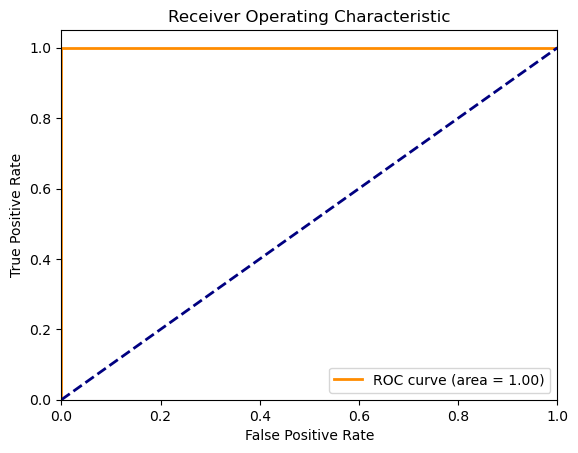

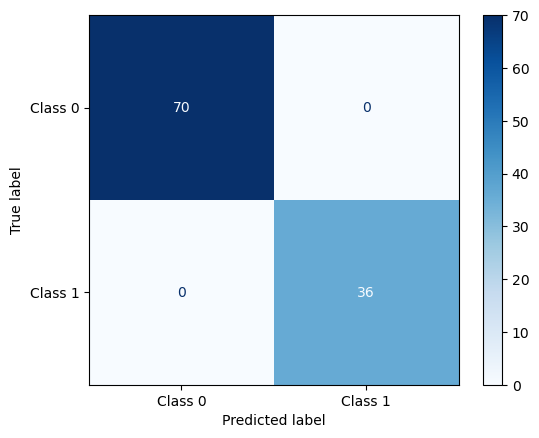

In [32]:
criterion = nn.CrossEntropyLoss() 
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("mps")


    model = model.to(device)

    total_acc_test = 0
    preds_test = []
    targets_test = []
    avg_test_loss = 0.
    
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            #print(f'test_label: {test_label}')
            mask = test_input['attention_mask'].squeeze(1).to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            #print(f'output : { output }')
            #print(f'output.argmax(dim=1) : { output.argmax(dim=1) }')
            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            loss = criterion(output, test_label) #BCELoss, 
            #print(f'LOSS: {loss}')
            avg_test_loss +=   loss.item() / len(test_dataloader)
            #print(f'Avg T LOSS: {avg_test_loss }')

            #probs_test = output.detach().cpu().numpy()
            probs_test =output.argmax(dim=1)
            #print(f'Prob_T: {probs_test}')
            preds_test += list(probs_test.cpu().flatten())
            #print(f'Pred_T: {preds_test}')
            targets_test += list(test_label.detach().cpu().numpy().flatten())         
            #print(f'Target_T:{targets_test}')

        precision, recall, f1, _ = precision_recall_fscore_support(targets_test, preds_test, average='binary')
        acc = accuracy_score(targets_test, preds_test)
        print(f'f1: {f1}')
        #pr_curve = PrecisionRecallCurve(num_classes=2)
        #precision, recall, thresholds = pr_curve(preds_test, targets_test)
        auroc_test = roc_auc_score(targets_test, preds_test)
        print(auroc_test )
        #print(targets_test, preds_test)
        #auprc_test = average_precision_score(targets_test, preds_test, average='micro')   
        #print(auprc_test)
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    print( precision, recall,  f1 )


        # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(targets_test, preds_test)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Compute confusion matrix
    cm = confusion_matrix(targets_test, preds_test)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

# evaluate(model, df_test)
    
evaluate(model, df_test)

In [ ]:
import matplotlib.pyplot as plt

In [33]:
x = np.arange(0,5) #config.n_epoch : 50

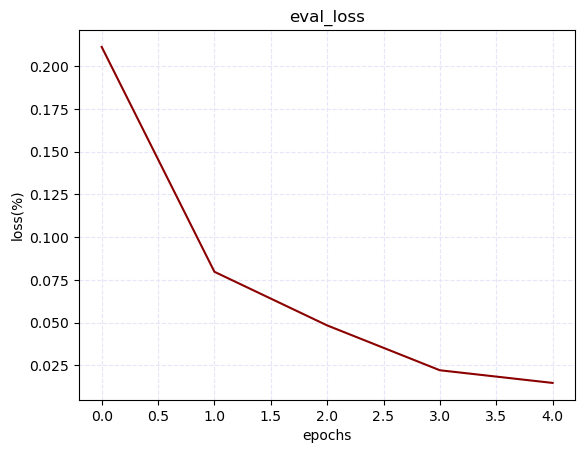

In [34]:
    # 도화지 생성
    fig = plt.figure()
    # 정확도 그래프 그리기
    plt.plot(x,eval_loss_log, label='eval_loss', color='darkred')
     # 축 이름
    plt.xlabel('epochs')
    plt.ylabel('loss(%)')
    plt.title('eval_loss')
    plt.grid(linestyle='--', color='lavender')
     # 그래프 표시
    plt.show()

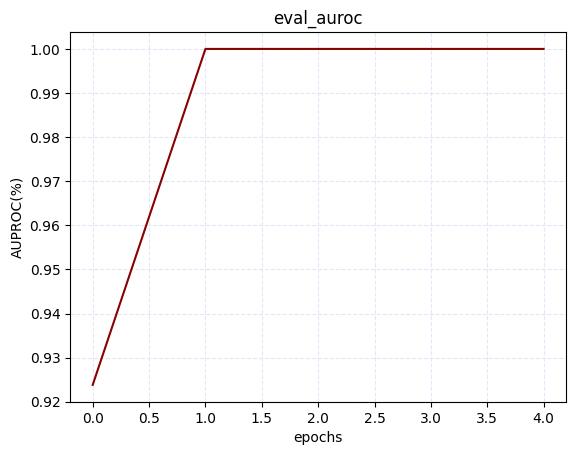

In [ ]:
# 도화지 생성
fig = plt.figure()
plt.plot(x, eval_auroc_log, label='eval_auroc', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('AUPROC(%)')
plt.title('eval_auroc')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()

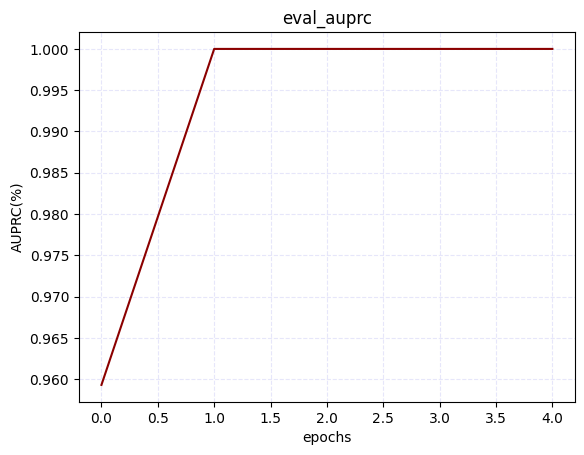

In [ ]:
# 도화지 생성
fig = plt.figure()
plt.plot(x, eval_auprc_log, label='eval_auprc', color='darkred')
# 축 이름
plt.xlabel('epochs')
plt.ylabel('AUPRC(%)')
plt.title('eval_auprc')
plt.grid(linestyle='--', color='lavender')
# 그래프 표시
plt.show()